In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgbm
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingclfressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
import optuna

import matplotlib.pyplot as plt
import seaborn as sns


import joblib
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

/home/arma/anaconda3/envs/teachopencadd/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
levels_up = 3
HDAC6= HERE.parents[levels_up-1]/'input'

In [3]:
df = pd.read_pickle(HDAC6/"HDAC6_2971compounds_1024B.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,molecular_weight,n_rot,n_heavy,n_hba,n_hbd,logp,num_ar,num_sa,num_alip,pchembl
0,CHEMBL3799183,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[1488606, 5343410, 8033062, 15183094, 1042149,...",382.072035,5.0,27.0,4.0,3.0,4.50360,3.0,0.0,0.0,6.82
1,CHEMBL3770936,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5976924, 3913535, 8033062, 2817337, 33707642,...",335.163377,3.0,25.0,4.0,2.0,2.79650,3.0,0.0,1.0,7.82
2,CHEMBL2337862,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...","[11028593, 3913535, 13317291, 17455853, 103354...",327.115381,4.0,23.0,7.0,1.0,2.61819,3.0,0.0,0.0,5.99
3,CHEMBL4088663,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[5976924, 4714340, 3732398, 4909488, 1081229, ...",307.095691,3.0,23.0,4.0,3.0,2.60610,3.0,0.0,0.0,6.58
4,CHEMBL2336043,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2987766, 7057043, 7998790, 6116087, 3203638, ...",507.273321,14.0,37.0,5.0,4.0,5.01780,3.0,0.0,0.0,6.18


In [4]:
df_labeled = pd.read_csv(HDAC6/"HDAC6_2971compounds_withTypes-Ki_newThreshold.csv", index_col=0)
df_labeled

,molecule_chembl_id,smiles,pActivity,label
0,CHEMBL4082520,CN1C(=O)C2CN(Cc3c2c2cc(OCc4ccccc4)ccc2n3Cc2ccc...,10.10,Single points
1,CHEMBL4098975,O=C(CCCCCCC(=O)Nc1ccc(NCCCn2cc(-c3ncnc4[nH]ccc...,9.85,hDAC6-selective
2,CHEMBL4100534,COc1ccc2c(c1)c1c(n2Cc2ccc(C(=O)NO)cc2)CN2CC1C(...,9.82,Single points
3,CHEMBL4101480,COc1ccc2c(c1)c1c(n2Cc2ccc(C(=O)NO)cc2)CN2CC1C(...,9.80,Single points
4,CHEMBL3912061,CS(=O)(=O)NCCc1cn(Cc2ccc(C(=O)NO)cc2)c2ccccc12,9.77,hDAC6-selective
...,...,...,...,...
2966,CHEMBL1798006,CC[C@H](C)[C@H](NC(=O)C1CCNCC1)C(=O)N1Cc2cc(OC...,6.77,Single points
2967,CHEMBL470843,O=C(/C=C/c1ccc(-c2cc(CN3CCOCC3)on2)cc1)NO,6.76,Semi-selective
2968,CHEMBL1798004,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1)C(=O)N1Cc2c...,6.72,Single points
2969,CHEMBL3215861,CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC,6.61,Dual-binder


In [5]:
df = pd.merge(df, df_labeled[['molecule_chembl_id',  'label']], on='molecule_chembl_id')

In [6]:
#df['Classes'] = np.where(df['label']== 'hDAC1-selective', 2)
df['Class'] = np.zeros(len(df))

df.loc[df[df.label == 'hDAC1-selective'].index, "Class"] = 1.0
df.loc[df[df.label == 'hDAC6-selective'].index, "Class"] = 2.0
df.loc[df[df.label == 'Dual-binder'].index, "Class"] = 3.0
df.loc[df[df.label == 'Non-binder'].index, "Class"] = 4.0
df.loc[df[df.label == 'Semi-selective'].index, "Class"] = 5.0
df.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,molecular_weight,n_rot,n_heavy,n_hba,n_hbd,logp,num_ar,num_sa,num_alip,pchembl,label,Class
0,CHEMBL3799183,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[1488606, 5343410, 8033062, 15183094, 1042149,...",382.072035,5.0,27.0,4.0,3.0,4.50360,3.0,0.0,0.0,6.82,Semi-selective,5.0
1,CHEMBL3770936,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5976924, 3913535, 8033062, 2817337, 33707642,...",335.163377,3.0,25.0,4.0,2.0,2.79650,3.0,0.0,1.0,7.82,Single points,0.0
2,CHEMBL2337862,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...","[11028593, 3913535, 13317291, 17455853, 103354...",327.115381,4.0,23.0,7.0,1.0,2.61819,3.0,0.0,0.0,5.99,Single points,0.0
3,CHEMBL4088663,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[5976924, 4714340, 3732398, 4909488, 1081229, ...",307.095691,3.0,23.0,4.0,3.0,2.60610,3.0,0.0,0.0,6.58,Single points,0.0


In [7]:
# Add column for selectivity
df["activity"] = np.zeros(len(df))

# Mark every molecule as selective if SelectivityWindow is >=2 or >=-2, 0 otherwise
df.loc[df[df.pchembl >= 6.6].index, "activity"] = 1.0

#By using Morgan fingerprints with radius of 3 and 1024 bits
indices =  np.array(df.index)
X = np.array(list((df['fp_Morgan3']))).astype(float)
#X.shape
Y =  df["activity"].values
Y_class = df['Class'].values

In [8]:
NUMS = 10
random_state= [146736, 1367, 209056, 1847464, 89563, 967034, 3689, 689547, 578929, 7458910]
X_tr_all = []
Y_tr_all = []
X_te_all = []
Y_te_all = []
Y_tr_class_all = []
Y_te_class_all = []
index_tr_all= []
index_te_all = []

for i in range(NUMS):
    X_tr, X_te, Y_tr, Y_te, Y_tr_class, Y_te_class, index_tr, index_te = train_test_split(X, Y, Y_class,indices, test_size=0.2, random_state=random_state[i], stratify=Y_class)
    X_tr_all.append(X_tr)
    Y_tr_all.append(Y_tr)
    X_te_all.append(X_te)
    Y_te_all.append(Y_te)
    Y_tr_class_all.append(Y_tr_class)
    Y_te_class_all.append(Y_te_class)
    index_tr_all.append(index_tr)
    index_te_all.append(index_te)
globals_dict = globals()
    
for i in range(0, len(index_te_all)):
    globals_dict[f"trainSet{i}"] = df.iloc[index_tr_all[i]]
    globals_dict[f"testSet{i}"] = df.iloc[index_te_all[i]]
    globals_dict[f"trainindex{i}"] = df.index[index_tr_all[i]]
    globals_dict[f"testindex{i}"] = df.index[index_te_all[i]]  
    globals_dict[f"X_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['activity'])).astype(float)
    
    globals_dict[f"Y_trainSet{i}_class"] = np.array(list(df.iloc[index_tr_all[i]]['Class'])).astype(float)
    globals_dict[f"X_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['activity'])).astype(float)
    
    globals_dict[f"Y_testSet{i}_class"] = np.array(list(df.iloc[index_te_all[i]]['Class'])).astype(float)
    

In [9]:
import sklearn.metrics
import math

def matrix_metrix(real_values,pred_values,beta):

    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    BalancedAccuracy = round( 0.5*(Recall+TNR),4)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)   
    F1_weighted = round(f1_score(real_values, pred_values, average="weighted"), 4)
    F1_micro = round(f1_score(real_values, pred_values, average="micro"), 4)
    F1_macro = round(f1_score(real_values, pred_values, average="macro"), 4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1

    mat_met = pd.DataFrame({
    'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos',
              'check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','BalancedAccuracy',
              'F1','F1_weighted','F1_micro', 'F1_macro', 'FBeta','MCC','BM','MK'],     
    'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,BalancedAccuracy,F1,F1_weighted,F1_micro, F1_macro, FBeta,MCC,BM,MK]})  
    return (mat_met)


## Random Forest 

In [10]:
%%time

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        rf_clf =  RandomForestClassifier(random_state=1121218, max_features = None, n_jobs=16,oob_score=True,
                                           max_samples=0.8, )
        rf_clf.fit(x_train, y_train)
        y_pred = rf_clf.predict(x_test)  
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)



mat_met_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
                    
print(mat_met_rf)

                 Metric  Value (average)  Value (std)
0                    TP       165.600000     8.579044
1                    TN        87.600000     7.290786
2                    FP        25.800000     3.457681
3                    FN        18.100000     3.348300
4              Accuracy         0.852244     0.017931
5             Precision         0.865140     0.017447
6           Sensitivity         0.901126     0.019911
7           Specificity         0.771950     0.031480
8              F1 score         0.882670     0.015935
9   F1 score (weighted)         0.851104     0.018064
10     F1 score (macro)         0.840947     0.018474
11    Balanced Accuracy         0.836539     0.018544
12                  MCC         0.683562     0.036839
13                  NPV         0.829120     0.025985
14              ROC_AUC         0.836539     0.018544
CPU times: user 2min 32s, sys: 352 ms, total: 2min 33s
Wall time: 11.2 s


In [11]:
import optuna  


def objective_rf_CV(trial, X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggestegorical("max_features", [None]),
    #oob_score = trial.suggestegorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    

    cv_scores = np.empty(10)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        rf = RandomForestClassifier(**param_grid, n_jobs=16, random_state=1121218, max_features = None, 
                                   oob_score=True,
                                   max_samples=0.8,) 
        
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        cv_scores[idx] = f1_score(y_test, y_pred,  average="macro")
      
    
    return np.mean(cv_scores)

In [12]:
def detailed_objective_rf_CV(trial,X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggestegorical("max_features", [None]),
    #oob_score = trial.suggestegorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    
    
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        rf = RandomForestClassifier(**param_grid, n_jobs=16, random_state=1121218, max_features = None, oob_score=True,
                                           max_samples=0.8,)
   
        #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test, y_pred)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)

    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)
    
  

In [13]:
#Execute optuna and set hyperparameters
study_rf = optuna.create_study(direction='maximize', study_name="RFclassifier")
func_rf_0 = lambda trial: objective_rf_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_rf.optimize(func_rf_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 10:14:50,873] A new study created in memory with name: RFclassifier
[I 2023-02-20 10:15:27,400] Trial 0 finished with value: 0.8283868292299704 and parameters: {'n_estimators': 447}. Best is trial 0 with value: 0.8283868292299704.
[I 2023-02-20 10:16:11,518] Trial 1 finished with value: 0.8265620151351859 and parameters: {'n_estimators': 538}. Best is trial 0 with value: 0.8283868292299704.
[I 2023-02-20 10:17:05,476] Trial 2 finished with value: 0.8284705675051219 and parameters: {'n_estimators': 666}. Best is trial 2 with value: 0.8284705675051219.
[I 2023-02-20 10:17:51,251] Trial 3 finished with value: 0.8274969782228313 and parameters: {'n_estimators': 574}. Best is trial 2 with value: 0.8284705675051219.
[I 2023-02-20 10:18:10,279] Trial 4 finished with value: 0.8298327570672244 and parameters: {'n_estimators': 228}. Best is trial 4 with value: 0.8298327570672244.
[I 2023-02-20 10:19:29,391] Trial 5 finished with value: 0.8288241082481702 and parameters: {'n_estimat

[I 2023-02-20 10:36:49,750] Trial 46 finished with value: 0.8305066781519935 and parameters: {'n_estimators': 170}. Best is trial 21 with value: 0.83306563990519.
[I 2023-02-20 10:37:16,883] Trial 47 finished with value: 0.8285447033827724 and parameters: {'n_estimators': 334}. Best is trial 21 with value: 0.83306563990519.
[I 2023-02-20 10:37:28,098] Trial 48 finished with value: 0.829372291759317 and parameters: {'n_estimators': 129}. Best is trial 21 with value: 0.83306563990519.
[I 2023-02-20 10:38:34,996] Trial 49 finished with value: 0.8296306215096283 and parameters: {'n_estimators': 839}. Best is trial 21 with value: 0.83306563990519.


	Number of trials: 50.0
	Best value (f1_score): 0.8331
	Best params:
		n_estimators: 162


In [14]:
optimized_rf_0 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
 
data_testing = pd.DataFrame()    
    
optimized_rf_0.fit(X_trainSet0, Y_trainSet0,)

#predict        
y_pred_rf_0 = optimized_rf_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_rf_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_rf_0)
Precision = precision_score(Y_testSet0, y_pred_rf_0)
Sensitivity = recall_score(Y_testSet0, y_pred_rf_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_rf_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_rf_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_rf_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_rf_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_rf_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_rf_0)
data_testing['y_test_idx0'] = testindex0
data_testing['y_test_Set0'] = Y_testSet0
data_testing['y_pred_Set0'] = y_pred_rf_0


mat_met_rf_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP), np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                           np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_rf_test)


                 Metric        Set0
0                    TP  336.000000
1                    TN  176.000000
2                    FP   48.000000
3                    FN   35.000000
4              Accuracy    0.860504
5             Precision    0.875000
6           Sensitivity    0.905660
7           Specificity    0.785700
8              F1 score    0.890066
9   F1 score (weighted)    0.859621
10     F1 score (macro)    0.849631
11    Balanced Accuracy    0.845687
12                  MCC    0.700193
13                  NPV    0.834100
14              ROC_AUC    0.845687


In [15]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_1 = lambda trial: objective_rf_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_rf.optimize(func_rf_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 10:38:59,346] Trial 50 finished with value: 0.837469330173817 and parameters: {'n_estimators': 278}. Best is trial 50 with value: 0.837469330173817.
[I 2023-02-20 10:39:19,533] Trial 51 finished with value: 0.8346875991610766 and parameters: {'n_estimators': 249}. Best is trial 50 with value: 0.837469330173817.
[I 2023-02-20 10:39:41,424] Trial 52 finished with value: 0.8361728054004803 and parameters: {'n_estimators': 267}. Best is trial 50 with value: 0.837469330173817.
[I 2023-02-20 10:40:04,163] Trial 53 finished with value: 0.8370014546948223 and parameters: {'n_estimators': 282}. Best is trial 50 with value: 0.837469330173817.
[I 2023-02-20 10:40:27,413] Trial 54 finished with value: 0.8370014546948223 and parameters: {'n_estimators': 281}. Best is trial 50 with value: 0.837469330173817.
[I 2023-02-20 10:40:50,417] Trial 55 finished with value: 0.836096498938168 and parameters: {'n_estimators': 290}. Best is trial 50 with value: 0.837469330173817.
[I 2023-02-20 10:4

[I 2023-02-20 11:10:28,513] Trial 97 finished with value: 0.8388354245814492 and parameters: {'n_estimators': 484}. Best is trial 91 with value: 0.8412273172483207.
[I 2023-02-20 11:10:58,362] Trial 98 finished with value: 0.8400032434902662 and parameters: {'n_estimators': 380}. Best is trial 91 with value: 0.8412273172483207.
[I 2023-02-20 11:11:29,715] Trial 99 finished with value: 0.8404951739690617 and parameters: {'n_estimators': 388}. Best is trial 91 with value: 0.8412273172483207.


	Number of trials: 100.0
	Best value (f1_score): 0.8412
	Best params:
		n_estimators: 494


In [16]:
optimized_rf_1 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_1.fit(X_trainSet1, Y_trainSet1,)

#predict        
y_pred_rf_1 = optimized_rf_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_rf_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_rf_1)
Precision = precision_score(Y_testSet1, y_pred_rf_1)
Sensitivity = recall_score(Y_testSet1, y_pred_rf_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_rf_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_rf_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_rf_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_rf_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_rf_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_rf_1)
data_testing['y_test_idx1'] = testindex1
data_testing['y_test_Set1'] = Y_testSet1
data_testing['y_pred_Set1'] = y_pred_rf_1


set1 = pd.DataFrame({ 'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set1'] =set1
print(mat_met_rf_test)


                 Metric        Set0        Set1
0                    TP  336.000000  336.000000
1                    TN  176.000000  170.000000
2                    FP   48.000000   64.000000
3                    FN   35.000000   25.000000
4              Accuracy    0.860504    0.850420
5             Precision    0.875000    0.840000
6           Sensitivity    0.905660    0.930748
7           Specificity    0.785700    0.726500
8              F1 score    0.890066    0.883049
9   F1 score (weighted)    0.859621    0.847454
10     F1 score (macro)    0.849631    0.837795
11    Balanced Accuracy    0.845687    0.828622
12                  MCC    0.700193    0.683976
13                  NPV    0.834100    0.871800
14              ROC_AUC    0.845687    0.828622


In [17]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_2 = lambda trial: objective_rf_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_rf.optimize(func_rf_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 11:12:05,758] Trial 100 finished with value: 0.838975555421128 and parameters: {'n_estimators': 380}. Best is trial 91 with value: 0.8412273172483207.
[I 2023-02-20 11:12:34,697] Trial 101 finished with value: 0.8399717142096682 and parameters: {'n_estimators': 349}. Best is trial 91 with value: 0.8412273172483207.
[I 2023-02-20 11:13:03,843] Trial 102 finished with value: 0.8412392582039265 and parameters: {'n_estimators': 334}. Best is trial 102 with value: 0.8412392582039265.
[I 2023-02-20 11:13:33,327] Trial 103 finished with value: 0.8398710908882325 and parameters: {'n_estimators': 350}. Best is trial 102 with value: 0.8412392582039265.
[I 2023-02-20 11:14:07,342] Trial 104 finished with value: 0.8392755182564707 and parameters: {'n_estimators': 396}. Best is trial 102 with value: 0.8412392582039265.
[I 2023-02-20 11:14:34,425] Trial 105 finished with value: 0.8374074170323234 and parameters: {'n_estimators': 322}. Best is trial 102 with value: 0.8412392582039265.
[

[I 2023-02-20 11:43:11,476] Trial 146 finished with value: 0.8383505684614304 and parameters: {'n_estimators': 564}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 11:43:54,649] Trial 147 finished with value: 0.8422962856480689 and parameters: {'n_estimators': 519}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 11:44:37,637] Trial 148 finished with value: 0.8409020723573486 and parameters: {'n_estimators': 517}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 11:45:16,210] Trial 149 finished with value: 0.8402489706980321 and parameters: {'n_estimators': 463}. Best is trial 138 with value: 0.8426167587438685.


	Number of trials: 150.0
	Best value (f1_score): 0.8426
	Best params:
		n_estimators: 521


In [18]:

optimized_rf_2 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_2.fit(X_trainSet2, Y_trainSet2,)

#predict        
y_pred_rf_2 = optimized_rf_2.predict(X_testSet2)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_rf_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_rf_2)
Precision = precision_score(Y_testSet2, y_pred_rf_2)
Sensitivity = recall_score(Y_testSet2, y_pred_rf_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_rf_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_rf_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_rf_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_rf_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_rf_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_rf_2)
data_testing['y_test_idx2'] = testindex2
data_testing['y_test_Set2'] = Y_testSet2
data_testing['y_pred_Set2'] = y_pred_rf_2

set2 = pd.DataFrame({'Set2':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set2'] =set2
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2
0                    TP  336.000000  336.000000  327.000000
1                    TN  176.000000  170.000000  166.000000
2                    FP   48.000000   64.000000   58.000000
3                    FN   35.000000   25.000000   44.000000
4              Accuracy    0.860504    0.850420    0.828571
5             Precision    0.875000    0.840000    0.849351
6           Sensitivity    0.905660    0.930748    0.881402
7           Specificity    0.785700    0.726500    0.741100
8              F1 score    0.890066    0.883049    0.865079
9   F1 score (weighted)    0.859621    0.847454    0.827394
10     F1 score (macro)    0.849631    0.837795    0.815028
11    Balanced Accuracy    0.845687    0.828622    0.811237
12                  MCC    0.700193    0.683976    0.631090
13                  NPV    0.834100    0.871800    0.790500
14              ROC_AUC    0.845687    0.828622    0.811237


In [19]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_3 = lambda trial: objective_rf_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_rf.optimize(func_rf_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 11:45:59,790] Trial 150 finished with value: 0.8288910167211127 and parameters: {'n_estimators': 481}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 11:46:40,753] Trial 151 finished with value: 0.831124535060687 and parameters: {'n_estimators': 501}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 11:47:23,273] Trial 152 finished with value: 0.8315276453965404 and parameters: {'n_estimators': 521}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 11:48:09,508] Trial 153 finished with value: 0.8292869676760523 and parameters: {'n_estimators': 562}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 11:48:48,644] Trial 154 finished with value: 0.8284706170308478 and parameters: {'n_estimators': 484}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 11:49:25,643] Trial 155 finished with value: 0.8294671179451534 and parameters: {'n_estimators': 449}. Best is trial 138 with value: 0.8426167587438685.

[I 2023-02-20 12:19:50,011] Trial 196 finished with value: 0.8305234685010656 and parameters: {'n_estimators': 528}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:20:36,635] Trial 197 finished with value: 0.8291621272141629 and parameters: {'n_estimators': 574}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:21:17,895] Trial 198 finished with value: 0.8297875907547982 and parameters: {'n_estimators': 504}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:22:02,854] Trial 199 finished with value: 0.8292359474762729 and parameters: {'n_estimators': 553}. Best is trial 138 with value: 0.8426167587438685.


	Number of trials: 200.0
	Best value (f1_score): 0.8426
	Best params:
		n_estimators: 521


In [20]:
optimized_rf_3 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_3.fit(X_trainSet3, Y_trainSet3,)

#predict        
y_pred_rf_3 = optimized_rf_3.predict(X_testSet3)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_rf_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_rf_3)
Precision = precision_score(Y_testSet3, y_pred_rf_3)
Sensitivity = recall_score(Y_testSet3, y_pred_rf_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_rf_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_rf_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_rf_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_rf_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_rf_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_rf_3)
data_testing['y_test_idx3'] = testindex3
data_testing['y_test_Set3'] = Y_testSet3
data_testing['y_pred_Set3'] = y_pred_rf_3


set3 = pd.DataFrame({'Set3':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set3'] =set3   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  336.000000  336.000000  327.000000  341.000000
1                    TN  176.000000  170.000000  166.000000  161.000000
2                    FP   48.000000   64.000000   58.000000   60.000000
3                    FN   35.000000   25.000000   44.000000   33.000000
4              Accuracy    0.860504    0.850420    0.828571    0.843697
5             Precision    0.875000    0.840000    0.849351    0.850374
6           Sensitivity    0.905660    0.930748    0.881402    0.911765
7           Specificity    0.785700    0.726500    0.741100    0.728500
8              F1 score    0.890066    0.883049    0.865079    0.880000
9   F1 score (weighted)    0.859621    0.847454    0.827394    0.841336
10     F1 score (macro)    0.849631    0.837795    0.815028    0.827952
11    Balanced Accuracy    0.845687    0.828622    0.811237    0.820136
12                  MCC    0.700193    0.683976    0.631090    0

In [21]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_4 = lambda trial: objective_rf_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_rf.optimize(func_rf_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 12:22:50,859] Trial 200 finished with value: 0.834966648436539 and parameters: {'n_estimators': 537}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:23:36,065] Trial 201 finished with value: 0.834966648436539 and parameters: {'n_estimators': 547}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:24:17,557] Trial 202 finished with value: 0.8370566239962441 and parameters: {'n_estimators': 522}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:24:58,256] Trial 203 finished with value: 0.8360062804526187 and parameters: {'n_estimators': 500}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:25:42,034] Trial 204 finished with value: 0.834966648436539 and parameters: {'n_estimators': 545}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:26:24,620] Trial 205 finished with value: 0.8365405473749293 and parameters: {'n_estimators': 520}. Best is trial 138 with value: 0.8426167587438685.
[

[I 2023-02-20 12:55:11,813] Trial 246 finished with value: 0.8351728457451542 and parameters: {'n_estimators': 466}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:55:58,057] Trial 247 finished with value: 0.8340831761694238 and parameters: {'n_estimators': 570}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:56:40,391] Trial 248 finished with value: 0.8360105605221637 and parameters: {'n_estimators': 527}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:57:20,722] Trial 249 finished with value: 0.835167961064404 and parameters: {'n_estimators': 493}. Best is trial 138 with value: 0.8426167587438685.


	Number of trials: 250.0
	Best value (f1_score): 0.8426
	Best params:
		n_estimators: 521


In [22]:
optimized_rf_4 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_4.fit(X_trainSet4, Y_trainSet4,)

#predict        
y_pred_rf_4 = optimized_rf_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_rf_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_rf_4)
Precision = precision_score(Y_testSet4, y_pred_rf_4)
Sensitivity = recall_score(Y_testSet4, y_pred_rf_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_rf_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_rf_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_rf_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_rf_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_rf_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_rf_4)
data_testing['y_test_idx4'] = testindex4
data_testing['y_test_Set4'] = Y_testSet4
data_testing['y_pred_Set4'] = y_pred_rf_4

set4 = pd.DataFrame({'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set4'] =set4   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  336.000000  336.000000  327.000000  341.000000   
1                    TN  176.000000  170.000000  166.000000  161.000000   
2                    FP   48.000000   64.000000   58.000000   60.000000   
3                    FN   35.000000   25.000000   44.000000   33.000000   
4              Accuracy    0.860504    0.850420    0.828571    0.843697   
5             Precision    0.875000    0.840000    0.849351    0.850374   
6           Sensitivity    0.905660    0.930748    0.881402    0.911765   
7           Specificity    0.785700    0.726500    0.741100    0.728500   
8              F1 score    0.890066    0.883049    0.865079    0.880000   
9   F1 score (weighted)    0.859621    0.847454    0.827394    0.841336   
10     F1 score (macro)    0.849631    0.837795    0.815028    0.827952   
11    Balanced Accuracy    0.845687    0.828622    0.811237    0.820136   
12                  MCC  

In [23]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_5 = lambda trial: objective_rf_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_rf.optimize(func_rf_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 12:58:08,638] Trial 250 finished with value: 0.820208539141588 and parameters: {'n_estimators': 546}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:58:48,574] Trial 251 finished with value: 0.8199570336764879 and parameters: {'n_estimators': 505}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 12:59:35,360] Trial 252 finished with value: 0.8215607228201863 and parameters: {'n_estimators': 595}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 13:00:16,935] Trial 253 finished with value: 0.8200927940606224 and parameters: {'n_estimators': 526}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 13:00:54,960] Trial 254 finished with value: 0.8223278500994027 and parameters: {'n_estimators': 480}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 13:01:37,864] Trial 255 finished with value: 0.8206019848820608 and parameters: {'n_estimators': 544}. Best is trial 138 with value: 0.8426167587438685.

[I 2023-02-20 13:28:59,184] Trial 296 finished with value: 0.821080612266209 and parameters: {'n_estimators': 535}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 13:29:20,435] Trial 297 finished with value: 0.8205332875171589 and parameters: {'n_estimators': 261}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 13:29:59,870] Trial 298 finished with value: 0.8208738453690403 and parameters: {'n_estimators': 501}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 13:30:41,248] Trial 299 finished with value: 0.8194090375427366 and parameters: {'n_estimators': 524}. Best is trial 138 with value: 0.8426167587438685.


	Number of trials: 300.0
	Best value (f1_score): 0.8426
	Best params:
		n_estimators: 521


In [24]:
optimized_rf_5 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_5.fit(X_trainSet5, Y_trainSet5,)

#predict        
y_pred_rf_5 = optimized_rf_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_rf_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_rf_5)
Precision = precision_score(Y_testSet5, y_pred_rf_5)
Sensitivity = recall_score(Y_testSet5, y_pred_rf_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_rf_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_rf_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_rf_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_rf_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_rf_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_rf_5)
data_testing['y_test_idx5'] = testindex5
data_testing['y_test_Set5'] = Y_testSet5
data_testing['y_pred_Set5'] = y_pred_rf_5


Set5 = pd.DataFrame({'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set5'] =Set5   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  336.000000  336.000000  327.000000  341.000000   
1                    TN  176.000000  170.000000  166.000000  161.000000   
2                    FP   48.000000   64.000000   58.000000   60.000000   
3                    FN   35.000000   25.000000   44.000000   33.000000   
4              Accuracy    0.860504    0.850420    0.828571    0.843697   
5             Precision    0.875000    0.840000    0.849351    0.850374   
6           Sensitivity    0.905660    0.930748    0.881402    0.911765   
7           Specificity    0.785700    0.726500    0.741100    0.728500   
8              F1 score    0.890066    0.883049    0.865079    0.880000   
9   F1 score (weighted)    0.859621    0.847454    0.827394    0.841336   
10     F1 score (macro)    0.849631    0.837795    0.815028    0.827952   
11    Balanced Accuracy    0.845687    0.828622    0.811237    0.820136   
12                  MCC  

In [25]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_6 = lambda trial: objective_rf_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_rf.optimize(func_rf_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 13:31:14,839] Trial 300 finished with value: 0.8284967375807692 and parameters: {'n_estimators': 363}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 13:31:48,594] Trial 301 finished with value: 0.8287472724763086 and parameters: {'n_estimators': 413}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 13:32:26,980] Trial 302 finished with value: 0.8304979418872138 and parameters: {'n_estimators': 483}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 13:33:13,255] Trial 303 finished with value: 0.8301639701850773 and parameters: {'n_estimators': 575}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 13:33:56,643] Trial 304 finished with value: 0.8300728042396678 and parameters: {'n_estimators': 553}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 13:34:39,702] Trial 305 finished with value: 0.8290817049581187 and parameters: {'n_estimators': 534}. Best is trial 138 with value: 0.8426167587438685

[I 2023-02-20 14:03:50,725] Trial 346 finished with value: 0.8287619005913521 and parameters: {'n_estimators': 506}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:04:33,418] Trial 347 finished with value: 0.8304010235225256 and parameters: {'n_estimators': 543}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:05:15,381] Trial 348 finished with value: 0.8291590842532255 and parameters: {'n_estimators': 521}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:05:54,322] Trial 349 finished with value: 0.8283516629948938 and parameters: {'n_estimators': 492}. Best is trial 138 with value: 0.8426167587438685.


	Number of trials: 350.0
	Best value (f1_score): 0.8426
	Best params:
		n_estimators: 521


In [26]:
optimized_rf_6 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_6.fit(X_trainSet6, Y_trainSet6,)

#predict        
y_pred_rf_6 = optimized_rf_6.predict(X_testSet6)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_rf_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_rf_6)
Precision = precision_score(Y_testSet6, y_pred_rf_6)
Sensitivity = recall_score(Y_testSet6, y_pred_rf_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_rf_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_rf_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_rf_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_rf_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_rf_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_rf_6)
data_testing['y_test_idx6'] = testindex6
data_testing['y_test_Set6'] = Y_testSet6
data_testing['y_pred_Set6'] = y_pred_rf_6


Set6 = pd.DataFrame({'Set6':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set6'] =Set6   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  336.000000  336.000000  327.000000  341.000000   
1                    TN  176.000000  170.000000  166.000000  161.000000   
2                    FP   48.000000   64.000000   58.000000   60.000000   
3                    FN   35.000000   25.000000   44.000000   33.000000   
4              Accuracy    0.860504    0.850420    0.828571    0.843697   
5             Precision    0.875000    0.840000    0.849351    0.850374   
6           Sensitivity    0.905660    0.930748    0.881402    0.911765   
7           Specificity    0.785700    0.726500    0.741100    0.728500   
8              F1 score    0.890066    0.883049    0.865079    0.880000   
9   F1 score (weighted)    0.859621    0.847454    0.827394    0.841336   
10     F1 score (macro)    0.849631    0.837795    0.815028    0.827952   
11    Balanced Accuracy    0.845687    0.828622    0.811237    0.820136   
12                  MCC  

In [27]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_7 = lambda trial: objective_rf_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_rf.optimize(func_rf_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 14:06:42,463] Trial 350 finished with value: 0.8328516505605096 and parameters: {'n_estimators': 533}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:07:28,715] Trial 351 finished with value: 0.8323338156899162 and parameters: {'n_estimators': 565}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:08:10,316] Trial 352 finished with value: 0.8319787004092323 and parameters: {'n_estimators': 507}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:08:48,543] Trial 353 finished with value: 0.8305863949428105 and parameters: {'n_estimators': 464}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:09:33,750] Trial 354 finished with value: 0.8327645207371077 and parameters: {'n_estimators': 550}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:10:16,578] Trial 355 finished with value: 0.8323914657431823 and parameters: {'n_estimators': 518}. Best is trial 138 with value: 0.8426167587438685

[I 2023-02-20 14:38:19,370] Trial 396 finished with value: 0.8323338156899162 and parameters: {'n_estimators': 546}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:39:02,062] Trial 397 finished with value: 0.8328516505605096 and parameters: {'n_estimators': 528}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:40:21,391] Trial 398 finished with value: 0.8323542257956837 and parameters: {'n_estimators': 1000}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:41:01,420] Trial 399 finished with value: 0.8324395483174214 and parameters: {'n_estimators': 497}. Best is trial 138 with value: 0.8426167587438685.


	Number of trials: 400.0
	Best value (f1_score): 0.8426
	Best params:
		n_estimators: 521


In [28]:
optimized_rf_7 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_7.fit(X_trainSet7, Y_trainSet7,)

#predict        
y_pred_rf_7 = optimized_rf_7.predict(X_testSet7)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_rf_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_rf_7)
Precision = precision_score(Y_testSet7, y_pred_rf_7)
Sensitivity = recall_score(Y_testSet7, y_pred_rf_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_rf_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_rf_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_rf_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_rf_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_rf_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_rf_7)
data_testing['y_test_idx7'] = testindex7
data_testing['y_test_Set7'] = Y_testSet7
data_testing['y_pred_Set7'] = y_pred_rf_7

Set7 = pd.DataFrame({'Set7':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set7'] =Set7   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  336.000000  336.000000  327.000000  341.000000   
1                    TN  176.000000  170.000000  166.000000  161.000000   
2                    FP   48.000000   64.000000   58.000000   60.000000   
3                    FN   35.000000   25.000000   44.000000   33.000000   
4              Accuracy    0.860504    0.850420    0.828571    0.843697   
5             Precision    0.875000    0.840000    0.849351    0.850374   
6           Sensitivity    0.905660    0.930748    0.881402    0.911765   
7           Specificity    0.785700    0.726500    0.741100    0.728500   
8              F1 score    0.890066    0.883049    0.865079    0.880000   
9   F1 score (weighted)    0.859621    0.847454    0.827394    0.841336   
10     F1 score (macro)    0.849631    0.837795    0.815028    0.827952   
11    Balanced Accuracy    0.845687    0.828622    0.811237    0.820136   
12                  MCC  

In [29]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_8 = lambda trial: objective_rf_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_rf.optimize(func_rf_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 14:41:43,000] Trial 400 finished with value: 0.8286219705907685 and parameters: {'n_estimators': 467}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:42:26,765] Trial 401 finished with value: 0.8278163338146374 and parameters: {'n_estimators': 562}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:43:07,345] Trial 402 finished with value: 0.8277500478838606 and parameters: {'n_estimators': 517}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:43:50,321] Trial 403 finished with value: 0.8291363002062516 and parameters: {'n_estimators': 536}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:44:30,477] Trial 404 finished with value: 0.8298925056512539 and parameters: {'n_estimators': 503}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 14:45:14,880] Trial 405 finished with value: 0.8273960836866703 and parameters: {'n_estimators': 550}. Best is trial 138 with value: 0.8426167587438685

[I 2023-02-20 15:12:03,165] Trial 446 finished with value: 0.8289688923897142 and parameters: {'n_estimators': 533}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 15:12:46,564] Trial 447 finished with value: 0.8278119174281254 and parameters: {'n_estimators': 548}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 15:13:27,003] Trial 448 finished with value: 0.829140034151922 and parameters: {'n_estimators': 514}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 15:13:56,635] Trial 449 finished with value: 0.8322253729378841 and parameters: {'n_estimators': 371}. Best is trial 138 with value: 0.8426167587438685.


	Number of trials: 450.0
	Best value (f1_score): 0.8426
	Best params:
		n_estimators: 521


In [30]:
optimized_rf_8 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_8.fit(X_trainSet8, Y_trainSet8,)

#predict        
y_pred_rf_8 = optimized_rf_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_rf_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_rf_8)
Precision = precision_score(Y_testSet8, y_pred_rf_8)
Sensitivity = recall_score(Y_testSet8, y_pred_rf_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_rf_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_rf_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_rf_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_rf_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_rf_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_rf_8)
data_testing['y_test_idx8'] = testindex8
data_testing['y_test_Set8'] = Y_testSet8
data_testing['y_pred_Set8'] = y_pred_rf_8

Set8 = pd.DataFrame({'Set8':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set8'] =Set8   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  336.000000  336.000000  327.000000  341.000000   
1                    TN  176.000000  170.000000  166.000000  161.000000   
2                    FP   48.000000   64.000000   58.000000   60.000000   
3                    FN   35.000000   25.000000   44.000000   33.000000   
4              Accuracy    0.860504    0.850420    0.828571    0.843697   
5             Precision    0.875000    0.840000    0.849351    0.850374   
6           Sensitivity    0.905660    0.930748    0.881402    0.911765   
7           Specificity    0.785700    0.726500    0.741100    0.728500   
8              F1 score    0.890066    0.883049    0.865079    0.880000   
9   F1 score (weighted)    0.859621    0.847454    0.827394    0.841336   
10     F1 score (macro)    0.849631    0.837795    0.815028    0.827952   
11    Balanced Accuracy    0.845687    0.828622    0.811237    0.820136   
12                  MCC  

In [31]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFclfressor_1")
func_rf_9 = lambda trial: objective_rf_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_rf.optimize(func_rf_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 15:14:38,731] Trial 450 finished with value: 0.8262040334880567 and parameters: {'n_estimators': 474}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 15:15:24,132] Trial 451 finished with value: 0.8260707502867171 and parameters: {'n_estimators': 575}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 15:15:59,028] Trial 452 finished with value: 0.8243950236048615 and parameters: {'n_estimators': 437}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 15:16:41,188] Trial 453 finished with value: 0.8253174848875571 and parameters: {'n_estimators': 529}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 15:17:20,654] Trial 454 finished with value: 0.8265982335965282 and parameters: {'n_estimators': 498}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 15:17:47,254] Trial 455 finished with value: 0.8263967650847632 and parameters: {'n_estimators': 329}. Best is trial 138 with value: 0.8426167587438685

[I 2023-02-20 15:46:17,023] Trial 496 finished with value: 0.8252617893283054 and parameters: {'n_estimators': 517}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 15:47:00,589] Trial 497 finished with value: 0.8260733689743649 and parameters: {'n_estimators': 546}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 15:47:46,268] Trial 498 finished with value: 0.8272962274208565 and parameters: {'n_estimators': 582}. Best is trial 138 with value: 0.8426167587438685.
[I 2023-02-20 15:48:24,963] Trial 499 finished with value: 0.8266115560076402 and parameters: {'n_estimators': 485}. Best is trial 138 with value: 0.8426167587438685.


	Number of trials: 500.0
	Best value (f1_score): 0.8426
	Best params:
		n_estimators: 521


In [32]:
optimized_rf_9 = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_9.fit(X_trainSet9, Y_trainSet9,)

#predict        
y_pred_rf_9 = optimized_rf_9.predict(X_testSet9)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_rf_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_rf_9)
Precision = precision_score(Y_testSet9, y_pred_rf_9)
Sensitivity = recall_score(Y_testSet9, y_pred_rf_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_rf_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_rf_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_rf_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_rf_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_rf_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_rf_9)
data_testing['y_test_idx9'] = testindex9
data_testing['y_test_Set9'] = Y_testSet9
data_testing['y_pred_Set9'] = y_pred_rf_9

Set9 = pd.DataFrame({'Set9':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })  

mat_met_rf_test['Set9'] =Set9   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  336.000000  336.000000  327.000000  341.000000   
1                    TN  176.000000  170.000000  166.000000  161.000000   
2                    FP   48.000000   64.000000   58.000000   60.000000   
3                    FN   35.000000   25.000000   44.000000   33.000000   
4              Accuracy    0.860504    0.850420    0.828571    0.843697   
5             Precision    0.875000    0.840000    0.849351    0.850374   
6           Sensitivity    0.905660    0.930748    0.881402    0.911765   
7           Specificity    0.785700    0.726500    0.741100    0.728500   
8              F1 score    0.890066    0.883049    0.865079    0.880000   
9   F1 score (weighted)    0.859621    0.847454    0.827394    0.841336   
10     F1 score (macro)    0.849631    0.837795    0.815028    0.827952   
11    Balanced Accuracy    0.845687    0.828622    0.811237    0.820136   
12                  MCC  

In [33]:
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (f1_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (f1_score): 0.8426
	Best params:
		n_estimators: 521


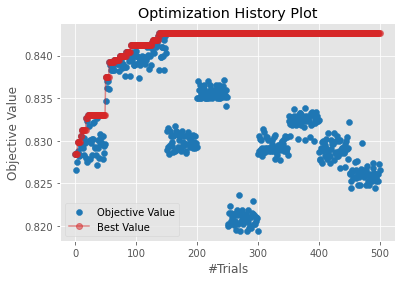

In [34]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_rf);

In [35]:
detailed_objective_rf_CV(study_rf.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,165.900000,8.171087
1,TN,87.300000,6.667500
2,FP,26.100000,3.107339
3,FN,17.800000,3.794733
4,Accuracy,0.852244,0.014942
5,Precision,0.863984,0.015618
6,Sensitivity,0.902899,0.021359
7,Specificity,0.769500,0.027348
8,F1 score,0.882861,0.013962
9,F1 score (weighted),0.851033,0.014893


In [36]:
mat_met_rf_test['ave'] = mat_met_rf_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_rf_test['std'] = mat_met_rf_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_rf_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,TP,336.000000,336.000000,327.000000,341.000000,339.000000,343.000000,332.000000,344.000000,344.000000,349.000000,339.100000,6.505553
1,TN,176.000000,170.000000,166.000000,161.000000,159.000000,170.000000,177.000000,174.000000,167.000000,160.000000,168.000000,6.565905
2,FP,48.000000,64.000000,58.000000,60.000000,66.000000,55.000000,55.000000,47.000000,60.000000,49.000000,56.200000,6.629899
3,FN,35.000000,25.000000,44.000000,33.000000,31.000000,27.000000,31.000000,30.000000,24.000000,37.000000,31.700000,5.982382
4,Accuracy,0.860504,0.850420,0.828571,0.843697,0.836975,0.862185,0.855462,0.870588,0.858824,0.855462,0.852269,0.012638
5,Precision,0.875000,0.840000,0.849351,0.850374,0.837037,0.861809,0.857881,0.879795,0.851485,0.876884,0.857962,0.015180
6,Sensitivity,0.905660,0.930748,0.881402,0.911765,0.916216,0.927027,0.914601,0.919786,0.934783,0.904145,0.914613,0.015461
7,Specificity,0.785700,0.726500,0.741100,0.728500,0.706700,0.755600,0.762900,0.787300,0.735700,0.765600,0.749560,0.026411
8,F1 score,0.890066,0.883049,0.865079,0.880000,0.874839,0.893229,0.885333,0.899346,0.891192,0.890306,0.885244,0.009967
9,F1 score (weighted),0.859621,0.847454,0.827394,0.841336,0.833781,0.860125,0.853833,0.869438,0.856036,0.854432,0.850345,0.012902


In [37]:
#change to fit into these X values 

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)



Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )
        optimizedCV_rf.fit(X_train,
                          y_train, 
                          
                  )
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
   
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_rf)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
    
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_rf))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_rf))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_rf))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_rf))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_rf, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_rf, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_rf))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_rf))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_rf))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_run0.sort_values(by='y_test_idx0', inplace=True)
rf_run0.reset_index(inplace=True, drop=True)
rf_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_run1.sort_values(by='y_test_idx1', inplace=True)
rf_run1.reset_index(inplace=True, drop=True)
rf_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_run2.sort_values(by='y_test_idx2', inplace=True)
rf_run2.reset_index(inplace=True, drop=True)
rf_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_run3.sort_values(by='y_test_idx3', inplace=True)
rf_run3.reset_index(inplace=True, drop=True)
rf_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_run4.sort_values(by='y_test_idx4', inplace=True)
rf_run4.reset_index(inplace=True, drop=True)
rf_5preds = pd.concat([rf_run0, rf_run1, rf_run2, rf_run3, rf_run4], axis=1)
rf_5preds = rf_5preds[['y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds['y_pred_rf_ave'] = rf_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds['y_pred_rf_std'] = rf_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
rf_5preds

,y_test_idx0,y_test0,y_pred_rf0,y_pred_rf1,y_pred_rf2,y_pred_rf3,y_pred_rf4,y_pred_rf_ave,y_pred_rf_std
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2966,2966,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2967,2967,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2968,2968,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2969,2969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
rf_5preds.to_csv('rf_5test_CV_result.csv')
mat_met_optimized_rf.to_csv('mat_met_rf_opt.csv')

In [39]:
#cross valide using this optimized RF 
rf_baseline_CVscore = cross_val_score(rf_clf, X, Y, cv=10, scoring="f1_macro")
#rf_opt_testSet_score = cross_val_score(optimized_rf, X, Y, cv=10, scoring="f1_macro")
rf_opt_CVscore = cross_val_score(optimizedCV_rf, X, Y, cv=10, scoring="f1_macro")
print("RF baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_baseline_CVscore), np.std(rf_baseline_CVscore, ddof=1)))
#print("RF optimized model (tested on Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (rf_opt_testSet_score.mean(), rf_opt_testSet_score.std()))
print("RF optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_opt_CVscore), np.std(rf_opt_CVscore, ddof=1)))

RF baseline model f1_score 0.8454 with a standard deviation of 0.0282
RF optimized model f1_score 0.8444 with a standard deviation of 0.0240


In [40]:
import joblib
joblib.dump(rf_clf, "./rf_clf.joblib")
#joblib.dump(optimized_rf, "./optimized_rf.joblib") # fitted to whole training set with last random_state selected
joblib.dump(optimizedCV_rf, "./optimizedCV_rf_clf.joblib")

['./optimizedCV_rf_clf.joblib']

## LGBMclassifier

In [41]:
%%time

TP=np.empty(10)
TN = np.empty(10)
FP= np.empty(10)
FN= np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W=np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        
        lgbm_clf = lgbm.LGBMClassifier(
        objective="binary",
        random_state=1121218,
        #n_estimators=150,
        boosting_type ="gbdt",  # default histogram binning of LGBM,
        n_jobs=16,
        #min_child_samples = 15,
        subsample=0.8, # also called bagging_fraction
        subsample_freq=10,
     
           )


        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_clf.fit(
                    X_train,
                    y_train,
                    eval_set=eval_set,
                    eval_metric="logloss",
                    #early_stopping_rounds=150,
                    verbose=False,
                    )

        y_pred = lgbm_clf.predict(X_test) 
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
print(mat_met_lgbm)

                 Metric  Value (average)  Value (std)
0                    TP       163.700000     8.564137
1                    TN        87.200000     6.142746
2                    FP        26.200000     3.326660
3                    FN        20.000000     4.109609
4              Accuracy         0.844500     0.020837
5             Precision         0.861749     0.018749
6           Sensitivity         0.890857     0.023506
7           Specificity         0.768930     0.026838
8              F1 score         0.875964     0.018886
9   F1 score (weighted)         0.843598     0.020791
10     F1 score (macro)         0.833259     0.020788
11    Balanced Accuracy         0.829891     0.020223
12                  MCC         0.667688     0.041543
13                  NPV         0.813970     0.031333
14              ROC_AUC         0.829891     0.020223
CPU times: user 33.2 s, sys: 95.9 ms, total: 33.3 s
Wall time: 2.21 s


In [42]:
import optuna  

def objective_lgbm_CV(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggestegorical("bagging_freq", [1]),
        }
  
    
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMClassifier(objective="binary", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=16,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
        cv_scores[idx] = f1_score(y_test, y_pred, average="macro")
       
        
    return np.mean(cv_scores)

In [43]:
#this is basically inner set parameters
def detailed_objective_lgbm_cv(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggestegorical("bagging_freq", [1]),
        
    }
    
    
  
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M =np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMClassifier(objective="binary", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=16,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        
        y_pred = lgbm_model.predict(X_test)
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    print(mat_met)

In [44]:
#Execute optuna and set hyperparameters
study_lgbm = optuna.create_study(direction='maximize', study_name="LGBMClassifier")
func_lgbm_0 = lambda trial: objective_lgbm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_lgbm.optimize(func_lgbm_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 15:55:00,611] A new study created in memory with name: LGBMClassifier
[I 2023-02-20 15:55:01,838] Trial 0 finished with value: 0.8128469329089295 and parameters: {'n_estimators': 464, 'learning_rate': 0.18399659282122405, 'max_depth': 5, 'max_bin': 269, 'num_leaves': 409}. Best is trial 0 with value: 0.8128469329089295.
[I 2023-02-20 15:55:04,309] Trial 1 finished with value: 0.8160608278594896 and parameters: {'n_estimators': 811, 'learning_rate': 0.05814872884196103, 'max_depth': 9, 'max_bin': 193, 'num_leaves': 304}. Best is trial 1 with value: 0.8160608278594896.
[I 2023-02-20 15:55:06,073] Trial 2 finished with value: 0.8154424250807011 and parameters: {'n_estimators': 636, 'learning_rate': 0.0788071718003575, 'max_depth': 7, 'max_bin': 213, 'num_leaves': 594}. Best is trial 1 with value: 0.8160608278594896.
[I 2023-02-20 15:55:08,137] Trial 3 finished with value: 0.8157212895665273 and parameters: {'n_estimators': 749, 'learning_rate': 0.08656724180836663, 'max_dept

[I 2023-02-20 15:56:03,947] Trial 31 finished with value: 0.8133020129968784 and parameters: {'n_estimators': 758, 'learning_rate': 0.19428987556433186, 'max_depth': 11, 'max_bin': 273, 'num_leaves': 37}. Best is trial 13 with value: 0.8244776377402715.
[I 2023-02-20 15:56:05,432] Trial 32 finished with value: 0.8248888660514749 and parameters: {'n_estimators': 827, 'learning_rate': 0.1784117612902918, 'max_depth': 12, 'max_bin': 300, 'num_leaves': 253}. Best is trial 32 with value: 0.8248888660514749.
[I 2023-02-20 15:56:06,915] Trial 33 finished with value: 0.8175827058951489 and parameters: {'n_estimators': 796, 'learning_rate': 0.18047230418703825, 'max_depth': 12, 'max_bin': 298, 'num_leaves': 245}. Best is trial 32 with value: 0.8248888660514749.
[I 2023-02-20 15:56:08,879] Trial 34 finished with value: 0.8210473182269012 and parameters: {'n_estimators': 831, 'learning_rate': 0.13267116634679266, 'max_depth': 12, 'max_bin': 288, 'num_leaves': 305}. Best is trial 32 with value: 0.

	Number of trials: 50.0
	Best value (f1_score): 0.8249
	Best params:
		n_estimators: 827
		learning_rate: 0.1784117612902918
		max_depth: 12
		max_bin: 300
		num_leaves: 253


In [45]:
optimized_lgbm_0 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
                                         
    
eval_set = [(X_testSet0, Y_testSet0)]
optimized_lgbm_0.fit(X_trainSet0,
                Y_trainSet0,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_0 = optimized_lgbm_0.predict(X_testSet0)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_lgbm_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_lgbm_0)
Precision = precision_score(Y_testSet0, y_pred_lgbm_0)
Sensitivity = recall_score(Y_testSet0, y_pred_lgbm_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_lgbm_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_lgbm_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_lgbm_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_lgbm_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_lgbm_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_lgbm_0)


mat_met_lgbm_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_lgbm_test)



                 Metric        Set0
0                    TP  333.000000
1                    TN  175.000000
2                    FP   49.000000
3                    FN   38.000000
4              Accuracy    0.853782
5             Precision    0.871728
6           Sensitivity    0.897574
7           Specificity    0.781200
8              F1 score    0.884462
9   F1 score (weighted)    0.853009
10     F1 score (macro)    0.842689
11    Balanced Accuracy    0.839412
12                  MCC    0.686036
13                  NPV    0.821600
14              ROC_AUC    0.839412


In [46]:
#Execute optuna and set hyperparameters

func_lgbm_1 = lambda trial: objective_lgbm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_lgbm.optimize(func_lgbm_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 15:56:33,670] Trial 50 finished with value: 0.8309476814924903 and parameters: {'n_estimators': 642, 'learning_rate': 0.14019807606018655, 'max_depth': 12, 'max_bin': 238, 'num_leaves': 631}. Best is trial 50 with value: 0.8309476814924903.
[I 2023-02-20 15:56:35,754] Trial 51 finished with value: 0.8292844864012505 and parameters: {'n_estimators': 596, 'learning_rate': 0.14282419232206836, 'max_depth': 12, 'max_bin': 240, 'num_leaves': 663}. Best is trial 50 with value: 0.8309476814924903.
[I 2023-02-20 15:56:37,592] Trial 52 finished with value: 0.8270475179446249 and parameters: {'n_estimators': 635, 'learning_rate': 0.16375927859501582, 'max_depth': 12, 'max_bin': 234, 'num_leaves': 693}. Best is trial 50 with value: 0.8309476814924903.
[I 2023-02-20 15:56:39,446] Trial 53 finished with value: 0.833324492554716 and parameters: {'n_estimators': 623, 'learning_rate': 0.16193547547571907, 'max_depth': 12, 'max_bin': 233, 'num_leaves': 715}. Best is trial 53 with value: 0

[I 2023-02-20 15:57:28,997] Trial 81 finished with value: 0.8172041379570046 and parameters: {'n_estimators': 663, 'learning_rate': 0.19987343916975425, 'max_depth': 10, 'max_bin': 150, 'num_leaves': 704}. Best is trial 55 with value: 0.8367740868647484.
[I 2023-02-20 15:57:30,512] Trial 82 finished with value: 0.8255975578272823 and parameters: {'n_estimators': 561, 'learning_rate': 0.19412504678023715, 'max_depth': 10, 'max_bin': 171, 'num_leaves': 678}. Best is trial 55 with value: 0.8367740868647484.
[I 2023-02-20 15:57:32,176] Trial 83 finished with value: 0.8289999074584069 and parameters: {'n_estimators': 508, 'learning_rate': 0.18593564162976342, 'max_depth': 12, 'max_bin': 179, 'num_leaves': 650}. Best is trial 55 with value: 0.8367740868647484.
[I 2023-02-20 15:57:33,857] Trial 84 finished with value: 0.8229008380565235 and parameters: {'n_estimators': 776, 'learning_rate': 0.19410148733875496, 'max_depth': 11, 'max_bin': 223, 'num_leaves': 616}. Best is trial 55 with value: 

	Number of trials: 100.0
	Best value (f1_score): 0.8368
	Best params:
		n_estimators: 608
		learning_rate: 0.16096545002740337
		max_depth: 11
		max_bin: 218
		num_leaves: 683


In [47]:
optimized_lgbm_1 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_lgbm_1.fit(X_trainSet1,
                Y_trainSet1,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_1 = optimized_lgbm_1.predict(X_testSet1)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_lgbm_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_lgbm_1)
Precision = precision_score(Y_testSet1, y_pred_lgbm_1)
Sensitivity = recall_score(Y_testSet1, y_pred_lgbm_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_lgbm_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_lgbm_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_lgbm_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_lgbm_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_lgbm_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_lgbm_1)


set1 = pd.DataFrame({ 'Set1':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set1'] =set1
print(mat_met_lgbm_test)


                 Metric        Set0        Set1
0                    TP  333.000000  327.000000
1                    TN  175.000000  166.000000
2                    FP   49.000000   68.000000
3                    FN   38.000000   34.000000
4              Accuracy    0.853782    0.828571
5             Precision    0.871728    0.827848
6           Sensitivity    0.897574    0.905817
7           Specificity    0.781200    0.709400
8              F1 score    0.884462    0.865079
9   F1 score (weighted)    0.853009    0.825711
10     F1 score (macro)    0.842689    0.815028
11    Balanced Accuracy    0.839412    0.807609
12                  MCC    0.686036    0.636177
13                  NPV    0.821600    0.830000
14              ROC_AUC    0.839412    0.807609


In [48]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_2 = lambda trial: objective_lgbm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_lgbm.optimize(func_lgbm_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 15:58:12,820] Trial 100 finished with value: 0.8338981254898836 and parameters: {'n_estimators': 705, 'learning_rate': 0.1601338029680051, 'max_depth': 12, 'max_bin': 227, 'num_leaves': 624}. Best is trial 55 with value: 0.8367740868647484.
[I 2023-02-20 15:58:14,780] Trial 101 finished with value: 0.8317055116054257 and parameters: {'n_estimators': 740, 'learning_rate': 0.1591876102181212, 'max_depth': 12, 'max_bin': 228, 'num_leaves': 623}. Best is trial 55 with value: 0.8367740868647484.
[I 2023-02-20 15:58:16,769] Trial 102 finished with value: 0.8347636529800125 and parameters: {'n_estimators': 765, 'learning_rate': 0.15295618475816705, 'max_depth': 12, 'max_bin': 249, 'num_leaves': 570}. Best is trial 55 with value: 0.8367740868647484.
[I 2023-02-20 15:58:18,652] Trial 103 finished with value: 0.8323105882306047 and parameters: {'n_estimators': 766, 'learning_rate': 0.1528879720573002, 'max_depth': 12, 'max_bin': 247, 'num_leaves': 605}. Best is trial 55 with value:

[I 2023-02-20 15:59:39,816] Trial 131 finished with value: 0.8406238312783867 and parameters: {'n_estimators': 890, 'learning_rate': 0.06038374821185475, 'max_depth': 12, 'max_bin': 215, 'num_leaves': 442}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 15:59:42,486] Trial 132 finished with value: 0.8389797343113056 and parameters: {'n_estimators': 859, 'learning_rate': 0.056403389761628564, 'max_depth': 12, 'max_bin': 209, 'num_leaves': 471}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 15:59:45,423] Trial 133 finished with value: 0.8391071591640978 and parameters: {'n_estimators': 880, 'learning_rate': 0.062350324987675315, 'max_depth': 12, 'max_bin': 215, 'num_leaves': 400}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 15:59:48,102] Trial 134 finished with value: 0.8421918775658561 and parameters: {'n_estimators': 884, 'learning_rate': 0.0733784382410855, 'max_depth': 12, 'max_bin': 203, 'num_leaves': 447}. Best is trial 113 wit

	Number of trials: 150.0
	Best value (f1_score): 0.8483
	Best params:
		n_estimators: 817
		learning_rate: 0.051638143204308144
		max_depth: 12
		max_bin: 211
		num_leaves: 491


In [49]:
optimized_lgbm_2 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet2, Y_testSet2)]
optimized_lgbm_2.fit(X_trainSet2,
                Y_trainSet2,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_2 = optimized_lgbm_2.predict(X_testSet2)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_lgbm_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_lgbm_2)
Precision = precision_score(Y_testSet2, y_pred_lgbm_2)
Sensitivity = recall_score(Y_testSet2, y_pred_lgbm_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_lgbm_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_lgbm_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_lgbm_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_lgbm_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_lgbm_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_lgbm_2)


Set2 = pd.DataFrame({ 'Set2':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set2'] = Set2
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2
0                    TP  333.000000  327.000000  320.000000
1                    TN  175.000000  166.000000  165.000000
2                    FP   49.000000   68.000000   59.000000
3                    FN   38.000000   34.000000   51.000000
4              Accuracy    0.853782    0.828571    0.815126
5             Precision    0.871728    0.827848    0.844327
6           Sensitivity    0.897574    0.905817    0.862534
7           Specificity    0.781200    0.709400    0.736600
8              F1 score    0.884462    0.865079    0.853333
9   F1 score (weighted)    0.853009    0.825711    0.814431
10     F1 score (macro)    0.842689    0.815028    0.801667
11    Balanced Accuracy    0.839412    0.807609    0.799570
12                  MCC    0.686036    0.636177    0.603661
13                  NPV    0.821600    0.830000    0.763900
14              ROC_AUC    0.839412    0.807609    0.799570


In [50]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_3 = lambda trial: objective_lgbm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_lgbm.optimize(func_lgbm_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:00:30,449] Trial 150 finished with value: 0.8280012709492285 and parameters: {'n_estimators': 829, 'learning_rate': 0.08329724082688882, 'max_depth': 12, 'max_bin': 209, 'num_leaves': 473}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:00:33,003] Trial 151 finished with value: 0.8245664530815716 and parameters: {'n_estimators': 883, 'learning_rate': 0.06959223233743105, 'max_depth': 12, 'max_bin': 201, 'num_leaves': 426}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:00:35,618] Trial 152 finished with value: 0.8241073202636281 and parameters: {'n_estimators': 900, 'learning_rate': 0.07237642734261178, 'max_depth': 12, 'max_bin': 203, 'num_leaves': 454}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:00:37,944] Trial 153 finished with value: 0.824075851583955 and parameters: {'n_estimators': 798, 'learning_rate': 0.09154973870284216, 'max_depth': 12, 'max_bin': 196, 'num_leaves': 464}. Best is trial 113 with 

[I 2023-02-20 16:01:58,594] Trial 181 finished with value: 0.8265198442918177 and parameters: {'n_estimators': 897, 'learning_rate': 0.05810626617042359, 'max_depth': 12, 'max_bin': 215, 'num_leaves': 449}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:02:01,804] Trial 182 finished with value: 0.8254448172909704 and parameters: {'n_estimators': 884, 'learning_rate': 0.06139569938312157, 'max_depth': 12, 'max_bin': 206, 'num_leaves': 441}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:02:04,662] Trial 183 finished with value: 0.8322563947008639 and parameters: {'n_estimators': 900, 'learning_rate': 0.06862762591302396, 'max_depth': 12, 'max_bin': 213, 'num_leaves': 540}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:02:07,042] Trial 184 finished with value: 0.8230115979206936 and parameters: {'n_estimators': 869, 'learning_rate': 0.07886460598933623, 'max_depth': 12, 'max_bin': 200, 'num_leaves': 465}. Best is trial 113 with

	Number of trials: 200.0
	Best value (f1_score): 0.8483
	Best params:
		n_estimators: 817
		learning_rate: 0.051638143204308144
		max_depth: 12
		max_bin: 211
		num_leaves: 491


In [51]:
optimized_lgbm_3 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet3, Y_testSet3)]
optimized_lgbm_3.fit(X_trainSet3,
                Y_trainSet3,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_3 = optimized_lgbm_3.predict(X_testSet3)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_lgbm_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_lgbm_3)
Precision = precision_score(Y_testSet3, y_pred_lgbm_3)
Sensitivity = recall_score(Y_testSet3, y_pred_lgbm_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_lgbm_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_lgbm_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_lgbm_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_lgbm_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_lgbm_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_lgbm_3)


Set3 = pd.DataFrame({ 'Set3':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set3'] = Set3
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  333.000000  327.000000  320.000000  332.000000
1                    TN  175.000000  166.000000  165.000000  165.000000
2                    FP   49.000000   68.000000   59.000000   56.000000
3                    FN   38.000000   34.000000   51.000000   42.000000
4              Accuracy    0.853782    0.828571    0.815126    0.835294
5             Precision    0.871728    0.827848    0.844327    0.855670
6           Sensitivity    0.897574    0.905817    0.862534    0.887701
7           Specificity    0.781200    0.709400    0.736600    0.746600
8              F1 score    0.884462    0.865079    0.853333    0.871391
9   F1 score (weighted)    0.853009    0.825711    0.814431    0.834113
10     F1 score (macro)    0.842689    0.815028    0.801667    0.821210
11    Balanced Accuracy    0.839412    0.807609    0.799570    0.817153
12                  MCC    0.686036    0.636177    0.603661    0

In [52]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_4 = lambda trial: objective_lgbm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_lgbm.optimize(func_lgbm_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:02:51,993] Trial 200 finished with value: 0.8297022933921021 and parameters: {'n_estimators': 852, 'learning_rate': 0.05709331182899308, 'max_depth': 12, 'max_bin': 211, 'num_leaves': 450}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:02:54,468] Trial 201 finished with value: 0.8225628647300587 and parameters: {'n_estimators': 886, 'learning_rate': 0.06065953515868323, 'max_depth': 12, 'max_bin': 216, 'num_leaves': 434}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:02:57,043] Trial 202 finished with value: 0.8340727201954781 and parameters: {'n_estimators': 884, 'learning_rate': 0.07213173037300394, 'max_depth': 12, 'max_bin': 222, 'num_leaves': 446}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:02:59,652] Trial 203 finished with value: 0.8302674669249368 and parameters: {'n_estimators': 869, 'learning_rate': 0.06349811641887776, 'max_depth': 12, 'max_bin': 214, 'num_leaves': 421}. Best is trial 113 with

[I 2023-02-20 16:04:12,594] Trial 231 finished with value: 0.8328632495984518 and parameters: {'n_estimators': 882, 'learning_rate': 0.06258704126200429, 'max_depth': 12, 'max_bin': 215, 'num_leaves': 431}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:04:15,209] Trial 232 finished with value: 0.8241319360212367 and parameters: {'n_estimators': 900, 'learning_rate': 0.06463716829820326, 'max_depth': 12, 'max_bin': 211, 'num_leaves': 551}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:04:18,459] Trial 233 finished with value: 0.8220868229088054 and parameters: {'n_estimators': 884, 'learning_rate': 0.044100131705040534, 'max_depth': 12, 'max_bin': 221, 'num_leaves': 420}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:04:20,630] Trial 234 finished with value: 0.817798107701676 and parameters: {'n_estimators': 868, 'learning_rate': 0.05451636082976407, 'max_depth': 4, 'max_bin': 215, 'num_leaves': 438}. Best is trial 113 with 

	Number of trials: 250.0
	Best value (f1_score): 0.8483
	Best params:
		n_estimators: 817
		learning_rate: 0.051638143204308144
		max_depth: 12
		max_bin: 211
		num_leaves: 491


In [53]:
optimized_lgbm_4 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet4, Y_testSet4)]
optimized_lgbm_4.fit(X_trainSet4,
                Y_trainSet4,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_4 = optimized_lgbm_4.predict(X_testSet4)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_lgbm_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_lgbm_4)
Precision = precision_score(Y_testSet4, y_pred_lgbm_4)
Sensitivity = recall_score(Y_testSet4, y_pred_lgbm_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_lgbm_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_lgbm_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_lgbm_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_lgbm_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_lgbm_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_lgbm_4)


Set4 = pd.DataFrame({ 'Set4':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set4'] = Set4
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  333.000000  327.000000  320.000000  332.000000   
1                    TN  175.000000  166.000000  165.000000  165.000000   
2                    FP   49.000000   68.000000   59.000000   56.000000   
3                    FN   38.000000   34.000000   51.000000   42.000000   
4              Accuracy    0.853782    0.828571    0.815126    0.835294   
5             Precision    0.871728    0.827848    0.844327    0.855670   
6           Sensitivity    0.897574    0.905817    0.862534    0.887701   
7           Specificity    0.781200    0.709400    0.736600    0.746600   
8              F1 score    0.884462    0.865079    0.853333    0.871391   
9   F1 score (weighted)    0.853009    0.825711    0.814431    0.834113   
10     F1 score (macro)    0.842689    0.815028    0.801667    0.821210   
11    Balanced Accuracy    0.839412    0.807609    0.799570    0.817153   
12                  MCC  

In [54]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_5 = lambda trial: objective_lgbm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_lgbm.optimize(func_lgbm_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:05:04,768] Trial 250 finished with value: 0.8160357781695442 and parameters: {'n_estimators': 899, 'learning_rate': 0.05143650922117319, 'max_depth': 12, 'max_bin': 215, 'num_leaves': 388}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:05:07,169] Trial 251 finished with value: 0.8154063412059103 and parameters: {'n_estimators': 856, 'learning_rate': 0.07782700646250278, 'max_depth': 12, 'max_bin': 208, 'num_leaves': 416}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:05:09,847] Trial 252 finished with value: 0.8139699114343948 and parameters: {'n_estimators': 879, 'learning_rate': 0.06201050742453476, 'max_depth': 12, 'max_bin': 202, 'num_leaves': 366}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:05:12,676] Trial 253 finished with value: 0.8146052547467016 and parameters: {'n_estimators': 841, 'learning_rate': 0.056654426897229285, 'max_depth': 11, 'max_bin': 198, 'num_leaves': 444}. Best is trial 113 wit

[I 2023-02-20 16:06:23,058] Trial 281 finished with value: 0.8155301266573172 and parameters: {'n_estimators': 845, 'learning_rate': 0.05085741467906276, 'max_depth': 7, 'max_bin': 206, 'num_leaves': 443}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:06:25,403] Trial 282 finished with value: 0.8124261057109722 and parameters: {'n_estimators': 873, 'learning_rate': 0.07660391133718031, 'max_depth': 12, 'max_bin': 194, 'num_leaves': 426}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:06:27,987] Trial 283 finished with value: 0.8129882908958596 and parameters: {'n_estimators': 856, 'learning_rate': 0.05730698723323397, 'max_depth': 12, 'max_bin': 210, 'num_leaves': 481}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:06:30,311] Trial 284 finished with value: 0.8125272749535087 and parameters: {'n_estimators': 883, 'learning_rate': 0.0664506819493623, 'max_depth': 12, 'max_bin': 204, 'num_leaves': 355}. Best is trial 113 with v

	Number of trials: 300.0
	Best value (f1_score): 0.8483
	Best params:
		n_estimators: 817
		learning_rate: 0.051638143204308144
		max_depth: 12
		max_bin: 211
		num_leaves: 491


In [55]:
optimized_lgbm_5 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet5, Y_testSet5)]
optimized_lgbm_5.fit(X_trainSet5,
                Y_trainSet5,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_5 = optimized_lgbm_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_lgbm_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_lgbm_5)
Precision = precision_score(Y_testSet5, y_pred_lgbm_5)
Sensitivity = recall_score(Y_testSet5, y_pred_lgbm_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_lgbm_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_lgbm_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_lgbm_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_lgbm_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_lgbm_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_lgbm_5)


Set5 = pd.DataFrame({ 'Set5':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set5'] = Set5
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  333.000000  327.000000  320.000000  332.000000   
1                    TN  175.000000  166.000000  165.000000  165.000000   
2                    FP   49.000000   68.000000   59.000000   56.000000   
3                    FN   38.000000   34.000000   51.000000   42.000000   
4              Accuracy    0.853782    0.828571    0.815126    0.835294   
5             Precision    0.871728    0.827848    0.844327    0.855670   
6           Sensitivity    0.897574    0.905817    0.862534    0.887701   
7           Specificity    0.781200    0.709400    0.736600    0.746600   
8              F1 score    0.884462    0.865079    0.853333    0.871391   
9   F1 score (weighted)    0.853009    0.825711    0.814431    0.834113   
10     F1 score (macro)    0.842689    0.815028    0.801667    0.821210   
11    Balanced Accuracy    0.839412    0.807609    0.799570    0.817153   
12                  MCC  

In [56]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_6 = lambda trial: objective_lgbm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_lgbm.optimize(func_lgbm_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.6f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:07:09,454] Trial 300 finished with value: 0.8181279437502846 and parameters: {'n_estimators': 864, 'learning_rate': 0.06262313885980557, 'max_depth': 12, 'max_bin': 216, 'num_leaves': 439}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:07:11,755] Trial 301 finished with value: 0.8147009386192264 and parameters: {'n_estimators': 844, 'learning_rate': 0.07547999790681284, 'max_depth': 12, 'max_bin': 205, 'num_leaves': 462}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:07:14,466] Trial 302 finished with value: 0.8190675763920388 and parameters: {'n_estimators': 875, 'learning_rate': 0.05327695901260655, 'max_depth': 11, 'max_bin': 213, 'num_leaves': 425}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:07:17,076] Trial 303 finished with value: 0.8190629676027024 and parameters: {'n_estimators': 900, 'learning_rate': 0.06670349231754451, 'max_depth': 12, 'max_bin': 210, 'num_leaves': 447}. Best is trial 113 with

[I 2023-02-20 16:08:35,512] Trial 331 finished with value: 0.8232412227670123 and parameters: {'n_estimators': 784, 'learning_rate': 0.06592085649195926, 'max_depth': 11, 'max_bin': 204, 'num_leaves': 467}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:08:37,872] Trial 332 finished with value: 0.8235350566935299 and parameters: {'n_estimators': 875, 'learning_rate': 0.07173362652178786, 'max_depth': 12, 'max_bin': 188, 'num_leaves': 364}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:08:40,264] Trial 333 finished with value: 0.8184155981440417 and parameters: {'n_estimators': 885, 'learning_rate': 0.08333491010478458, 'max_depth': 12, 'max_bin': 224, 'num_leaves': 420}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:08:43,214] Trial 334 finished with value: 0.8238851828102038 and parameters: {'n_estimators': 832, 'learning_rate': 0.05907666071745443, 'max_depth': 12, 'max_bin': 210, 'num_leaves': 407}. Best is trial 113 with

	Number of trials: 350.0
	Best value (f1_score): 0.848338
	Best params:
		n_estimators: 817
		learning_rate: 0.051638143204308144
		max_depth: 12
		max_bin: 211
		num_leaves: 491


In [57]:
optimized_lgbm_6 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet6, Y_testSet6)]
optimized_lgbm_6.fit(X_trainSet6,
                Y_trainSet6,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_6 = optimized_lgbm_6.predict(X_testSet6)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_lgbm_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_lgbm_6)
Precision = precision_score(Y_testSet6, y_pred_lgbm_6)
Sensitivity = recall_score(Y_testSet6, y_pred_lgbm_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_lgbm_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_lgbm_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_lgbm_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_lgbm_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_lgbm_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_lgbm_6)


Set6 = pd.DataFrame({ 'Set6':[ np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set6'] = Set6
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  333.000000  327.000000  320.000000  332.000000   
1                    TN  175.000000  166.000000  165.000000  165.000000   
2                    FP   49.000000   68.000000   59.000000   56.000000   
3                    FN   38.000000   34.000000   51.000000   42.000000   
4              Accuracy    0.853782    0.828571    0.815126    0.835294   
5             Precision    0.871728    0.827848    0.844327    0.855670   
6           Sensitivity    0.897574    0.905817    0.862534    0.887701   
7           Specificity    0.781200    0.709400    0.736600    0.746600   
8              F1 score    0.884462    0.865079    0.853333    0.871391   
9   F1 score (weighted)    0.853009    0.825711    0.814431    0.834113   
10     F1 score (macro)    0.842689    0.815028    0.801667    0.821210   
11    Balanced Accuracy    0.839412    0.807609    0.799570    0.817153   
12                  MCC  

In [58]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_7 = lambda trial: objective_lgbm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_lgbm.optimize(func_lgbm_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.7f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:09:27,877] Trial 350 finished with value: 0.818162324526074 and parameters: {'n_estimators': 717, 'learning_rate': 0.052015492626806235, 'max_depth': 12, 'max_bin': 198, 'num_leaves': 430}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:09:30,599] Trial 351 finished with value: 0.8162283644911617 and parameters: {'n_estimators': 858, 'learning_rate': 0.06514720370530541, 'max_depth': 12, 'max_bin': 204, 'num_leaves': 396}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:09:33,717] Trial 352 finished with value: 0.8181280618846578 and parameters: {'n_estimators': 887, 'learning_rate': 0.05810619110545241, 'max_depth': 12, 'max_bin': 217, 'num_leaves': 476}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:09:36,749] Trial 353 finished with value: 0.8182316827967939 and parameters: {'n_estimators': 845, 'learning_rate': 0.0737131432966234, 'max_depth': 12, 'max_bin': 207, 'num_leaves': 448}. Best is trial 113 with 

[I 2023-02-20 16:10:54,685] Trial 381 finished with value: 0.8261517202103553 and parameters: {'n_estimators': 885, 'learning_rate': 0.08744095239502114, 'max_depth': 12, 'max_bin': 193, 'num_leaves': 462}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:10:57,583] Trial 382 finished with value: 0.8189519749310117 and parameters: {'n_estimators': 854, 'learning_rate': 0.05645513959879336, 'max_depth': 12, 'max_bin': 220, 'num_leaves': 403}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:11:00,416] Trial 383 finished with value: 0.8189292308666369 and parameters: {'n_estimators': 833, 'learning_rate': 0.07511550475618799, 'max_depth': 12, 'max_bin': 209, 'num_leaves': 508}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:11:03,394] Trial 384 finished with value: 0.8181431125314169 and parameters: {'n_estimators': 900, 'learning_rate': 0.06399139522524422, 'max_depth': 12, 'max_bin': 215, 'num_leaves': 418}. Best is trial 113 with

	Number of trials: 400.0
	Best value (f1_score): 0.8483381
	Best params:
		n_estimators: 817
		learning_rate: 0.051638143204308144
		max_depth: 12
		max_bin: 211
		num_leaves: 491


In [59]:
optimized_lgbm_7 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet7, Y_testSet7)]
optimized_lgbm_7.fit(X_trainSet7,
                Y_trainSet7,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_7 = optimized_lgbm_7.predict(X_testSet7)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_lgbm_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_lgbm_7)
Precision = precision_score(Y_testSet7, y_pred_lgbm_7)
Sensitivity = recall_score(Y_testSet7, y_pred_lgbm_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_lgbm_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_lgbm_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_lgbm_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_lgbm_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_lgbm_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_lgbm_7)


Set7 = pd.DataFrame({ 'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set7'] = Set7
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  333.000000  327.000000  320.000000  332.000000   
1                    TN  175.000000  166.000000  165.000000  165.000000   
2                    FP   49.000000   68.000000   59.000000   56.000000   
3                    FN   38.000000   34.000000   51.000000   42.000000   
4              Accuracy    0.853782    0.828571    0.815126    0.835294   
5             Precision    0.871728    0.827848    0.844327    0.855670   
6           Sensitivity    0.897574    0.905817    0.862534    0.887701   
7           Specificity    0.781200    0.709400    0.736600    0.746600   
8              F1 score    0.884462    0.865079    0.853333    0.871391   
9   F1 score (weighted)    0.853009    0.825711    0.814431    0.834113   
10     F1 score (macro)    0.842689    0.815028    0.801667    0.821210   
11    Balanced Accuracy    0.839412    0.807609    0.799570    0.817153   
12                  MCC  

In [60]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_8 = lambda trial: objective_lgbm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_lgbm.optimize(func_lgbm_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:11:46,216] Trial 400 finished with value: 0.829980288185044 and parameters: {'n_estimators': 885, 'learning_rate': 0.0775681066216226, 'max_depth': 12, 'max_bin': 218, 'num_leaves': 451}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:11:49,146] Trial 401 finished with value: 0.8248061921456911 and parameters: {'n_estimators': 873, 'learning_rate': 0.0689306923851994, 'max_depth': 12, 'max_bin': 210, 'num_leaves': 494}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:11:52,290] Trial 402 finished with value: 0.8266372757940935 and parameters: {'n_estimators': 861, 'learning_rate': 0.05461843821161467, 'max_depth': 12, 'max_bin': 167, 'num_leaves': 476}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:11:55,524] Trial 403 finished with value: 0.83115741451254 and parameters: {'n_estimators': 795, 'learning_rate': 0.06264024167821139, 'max_depth': 12, 'max_bin': 190, 'num_leaves': 430}. Best is trial 113 with valu

[I 2023-02-20 16:13:22,243] Trial 431 finished with value: 0.8324881253996415 and parameters: {'n_estimators': 900, 'learning_rate': 0.07509480391001157, 'max_depth': 12, 'max_bin': 206, 'num_leaves': 454}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:13:25,480] Trial 432 finished with value: 0.8349435323583393 and parameters: {'n_estimators': 848, 'learning_rate': 0.06460870948677172, 'max_depth': 12, 'max_bin': 211, 'num_leaves': 480}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:13:28,929] Trial 433 finished with value: 0.8332158429876071 and parameters: {'n_estimators': 872, 'learning_rate': 0.053154872972291316, 'max_depth': 12, 'max_bin': 215, 'num_leaves': 411}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:13:31,883] Trial 434 finished with value: 0.8282035861348274 and parameters: {'n_estimators': 828, 'learning_rate': 0.059393752159721445, 'max_depth': 12, 'max_bin': 221, 'num_leaves': 434}. Best is trial 113 wi

	Number of trials: 450.0
	Best value (f1_score): 0.84833806
	Best params:
		n_estimators: 817
		learning_rate: 0.051638143204308144
		max_depth: 12
		max_bin: 211
		num_leaves: 491


In [61]:
optimized_lgbm_8 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet8, Y_testSet8)]
optimized_lgbm_8.fit(X_trainSet8,
                Y_trainSet8,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_8 = optimized_lgbm_8.predict(X_testSet8)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_lgbm_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_lgbm_8)
Precision = precision_score(Y_testSet8, y_pred_lgbm_8)
Sensitivity = recall_score(Y_testSet8, y_pred_lgbm_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_lgbm_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_lgbm_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_lgbm_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_lgbm_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_lgbm_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_lgbm_8)


Set8 = pd.DataFrame({ 'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set8'] = Set8
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  333.000000  327.000000  320.000000  332.000000   
1                    TN  175.000000  166.000000  165.000000  165.000000   
2                    FP   49.000000   68.000000   59.000000   56.000000   
3                    FN   38.000000   34.000000   51.000000   42.000000   
4              Accuracy    0.853782    0.828571    0.815126    0.835294   
5             Precision    0.871728    0.827848    0.844327    0.855670   
6           Sensitivity    0.897574    0.905817    0.862534    0.887701   
7           Specificity    0.781200    0.709400    0.736600    0.746600   
8              F1 score    0.884462    0.865079    0.853333    0.871391   
9   F1 score (weighted)    0.853009    0.825711    0.814431    0.834113   
10     F1 score (macro)    0.842689    0.815028    0.801667    0.821210   
11    Balanced Accuracy    0.839412    0.807609    0.799570    0.817153   
12                  MCC  

In [62]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="LGBMClassifier_1")
func_lgbm_9 = lambda trial: objective_lgbm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_lgbm.optimize(func_lgbm_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (f1_score): {study_lgbm.best_value:.9f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:14:15,294] Trial 450 finished with value: 0.8220486858751631 and parameters: {'n_estimators': 838, 'learning_rate': 0.06494632091675356, 'max_depth': 8, 'max_bin': 211, 'num_leaves': 458}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:14:18,526] Trial 451 finished with value: 0.8179752743237041 and parameters: {'n_estimators': 863, 'learning_rate': 0.04982130821980466, 'max_depth': 12, 'max_bin': 203, 'num_leaves': 446}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:14:21,079] Trial 452 finished with value: 0.8216063994169763 and parameters: {'n_estimators': 882, 'learning_rate': 0.06068290684362414, 'max_depth': 12, 'max_bin': 206, 'num_leaves': 420}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:14:22,729] Trial 453 finished with value: 0.804548621426094 and parameters: {'n_estimators': 848, 'learning_rate': 0.06749304459224753, 'max_depth': 3, 'max_bin': 214, 'num_leaves': 486}. Best is trial 113 with va

[I 2023-02-20 16:15:39,029] Trial 481 finished with value: 0.823848221029656 and parameters: {'n_estimators': 884, 'learning_rate': 0.057756756149648605, 'max_depth': 12, 'max_bin': 209, 'num_leaves': 403}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:15:41,199] Trial 482 finished with value: 0.8222684838963424 and parameters: {'n_estimators': 846, 'learning_rate': 0.08393294234520542, 'max_depth': 11, 'max_bin': 190, 'num_leaves': 433}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:15:43,421] Trial 483 finished with value: 0.8185653131796716 and parameters: {'n_estimators': 865, 'learning_rate': 0.07606262892000905, 'max_depth': 12, 'max_bin': 198, 'num_leaves': 466}. Best is trial 113 with value: 0.8483380594061133.
[I 2023-02-20 16:15:46,080] Trial 484 finished with value: 0.8240594666974715 and parameters: {'n_estimators': 827, 'learning_rate': 0.06733688218287442, 'max_depth': 12, 'max_bin': 203, 'num_leaves': 423}. Best is trial 113 with

	Number of trials: 500.0
	Best value (f1_score): 0.848338059
	Best params:
		n_estimators: 817
		learning_rate: 0.051638143204308144
		max_depth: 12
		max_bin: 211
		num_leaves: 491


In [63]:
optimized_lgbm_9 = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet9, Y_testSet9)]
optimized_lgbm_9.fit(X_trainSet9,
                Y_trainSet9,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_9 = optimized_lgbm_9.predict(X_testSet9)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_lgbm_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_lgbm_9)
Precision = precision_score(Y_testSet9, y_pred_lgbm_9)
Sensitivity = recall_score(Y_testSet9, y_pred_lgbm_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_lgbm_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_lgbm_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_lgbm_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_lgbm_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_lgbm_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_lgbm_9)


Set9 = pd.DataFrame({ 'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set9'] = Set9
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  333.000000  327.000000  320.000000  332.000000   
1                    TN  175.000000  166.000000  165.000000  165.000000   
2                    FP   49.000000   68.000000   59.000000   56.000000   
3                    FN   38.000000   34.000000   51.000000   42.000000   
4              Accuracy    0.853782    0.828571    0.815126    0.835294   
5             Precision    0.871728    0.827848    0.844327    0.855670   
6           Sensitivity    0.897574    0.905817    0.862534    0.887701   
7           Specificity    0.781200    0.709400    0.736600    0.746600   
8              F1 score    0.884462    0.865079    0.853333    0.871391   
9   F1 score (weighted)    0.853009    0.825711    0.814431    0.834113   
10     F1 score (macro)    0.842689    0.815028    0.801667    0.821210   
11    Balanced Accuracy    0.839412    0.807609    0.799570    0.817153   
12                  MCC  

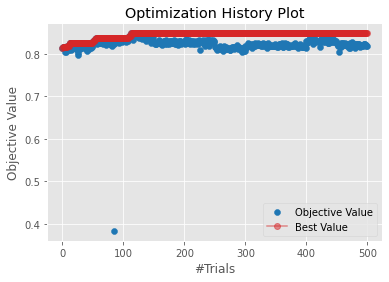

In [64]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_lgbm);

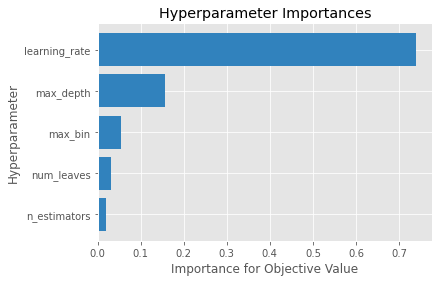

In [65]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study_lgbm);

In [66]:
detailed_objective_lgbm_cv(study_lgbm.best_trial, X, Y, Y_class)

                 Metric  Value (average)  Value (std)
0                    TP       165.700000     7.846443
1                    TN        87.200000     7.083627
2                    FP        26.200000     2.936362
3                    FN        18.000000     3.231787
4              Accuracy         0.851230     0.013703
5             Precision         0.863424     0.014346
6           Sensitivity         0.901822     0.018415
7           Specificity         0.768380     0.028162
8              F1 score         0.882089     0.012513
9   F1 score (weighted)         0.850016     0.013779
10     F1 score (macro)         0.839671     0.014505
11    Balanced Accuracy         0.835099     0.014691
12                  MCC         0.681257     0.028806
13                  NPV         0.829140     0.025158
14              ROC_AUC         0.835099     0.014691


In [67]:
mat_met_lgbm_test['ave'] = mat_met_lgbm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_lgbm_test['std'] = mat_met_lgbm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_lgbm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,TP,333.000000,327.000000,320.000000,332.000000,342.000000,339.000000,327.000000,334.000000,333.000000,347.000000,333.400000,7.848567
1,TN,175.000000,166.000000,165.000000,165.000000,160.000000,176.000000,171.000000,175.000000,166.000000,162.000000,168.100000,5.743595
2,FP,49.000000,68.000000,59.000000,56.000000,65.000000,49.000000,61.000000,46.000000,61.000000,47.000000,56.100000,7.908505
3,FN,38.000000,34.000000,51.000000,42.000000,28.000000,31.000000,36.000000,40.000000,35.000000,39.000000,37.400000,6.363088
4,Accuracy,0.853782,0.828571,0.815126,0.835294,0.843697,0.865546,0.836975,0.855462,0.838655,0.855462,0.842857,0.015038
5,Precision,0.871728,0.827848,0.844327,0.855670,0.840295,0.873711,0.842784,0.878947,0.845178,0.880711,0.856120,0.018754
6,Sensitivity,0.897574,0.905817,0.862534,0.887701,0.924324,0.916216,0.900826,0.893048,0.904891,0.898964,0.899190,0.016723
7,Specificity,0.781200,0.709400,0.736600,0.746600,0.711100,0.782200,0.737100,0.791900,0.731300,0.775100,0.750250,0.030302
8,F1 score,0.884462,0.865079,0.853333,0.871391,0.880309,0.894459,0.870839,0.885942,0.874016,0.889744,0.876957,0.012447
9,F1 score (weighted),0.853009,0.825711,0.814431,0.834113,0.840418,0.864342,0.835046,0.855043,0.836507,0.854793,0.841341,0.015342


In [68]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_lgbm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = lgbm.LGBMClassifier(objective="binary", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_lgbm.fit(X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="binary_logloss",     
                early_stopping_rounds=50,
                verbose = False,
                )
                          
                  
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_lgbm)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
       
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_lgbm))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_lgbm))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_lgbm))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_lgbm))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_lgbm, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_lgbm, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_lgbm))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_lgbm))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_lgbm))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_run0.reset_index(inplace=True, drop=True)
lgbm_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_run1.reset_index(inplace=True, drop=True)
lgbm_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_run2.reset_index(inplace=True, drop=True)
lgbm_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_run3.reset_index(inplace=True, drop=True)
lgbm_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_run4.reset_index(inplace=True, drop=True)
lgbm_5preds = pd.concat([lgbm_run0, lgbm_run1, lgbm_run2, lgbm_run3, lgbm_run4], axis=1)
lgbm_5preds = lgbm_5preds[['y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds['y_pred_lgbm_ave'] = lgbm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds['y_pred_lgbm_std'] = lgbm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
lgbm_5preds

,y_test_idx0,y_test0,y_pred_lgbm0,y_pred_lgbm1,y_pred_lgbm2,y_pred_lgbm3,y_pred_lgbm4,y_pred_lgbm_ave,y_pred_lgbm_std
0,0,1.0,1.0,0.0,1.0,1.0,1.0,0.8,0.400000
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
4,4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...
2966,2966,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
2967,2967,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
2968,2968,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
2969,2969,1.0,1.0,0.0,1.0,0.0,1.0,0.6,0.489898


In [69]:
mat_met_optimized_lgbm.to_csv('mat_met_lgbm_opt.csv')
lgbm_5preds.to_csv('lgbm_5test_CV_result.csv')

In [70]:
#cross valide using this optimized LightGBM 
fit_params={'early_stopping_rounds': 50, 
        'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
            'verbose':False,
           }
#cross valide using this optimized LightGBM 
lgbm_baseline_CVscore = cross_val_score(lgbm_clf, X, Y, cv=10, scoring="f1_macro")
#f1_cv_lgbm_opt_testSet = cross_val_score(optimized_lgbm, X, Y, cv=10, scoring="f1_macro")
f1_cv_lgbm_opt = cross_val_score(optimizedCV_lgbm, X, Y, cv=10, scoring="f1_macro", fit_params=fit_params)
print("LightGBM baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(lgbm_baseline_CVscore), np.std(lgbm_baseline_CVscore, ddof=1)))
#print("LightGBM optimized model (tested on Y_te)f1_score %0.4f with a standard deviation of %0.4f" % (f1_cv_lgbm_opt_testSet.mean(), f1_cv_lgbm_opt_testSet.std()))
print("LightGBM optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(f1_cv_lgbm_opt), np.std(f1_cv_lgbm_opt, ddof=1)))

LightGBM baseline model f1_score 0.8347 with a standard deviation of 0.0242
LightGBM optimized model f1_score 0.8389 with a standard deviation of 0.0214


In [71]:
joblib.dump(lgbm_clf, "./lgbm_clf.joblib")
#joblib.dump(optimized_lgbm, "./optimized_lgbm.joblib")
joblib.dump(optimizedCV_lgbm, "./optimizedCV_lgbm_clf.joblib") 
#loaded_rf = joblib.load("./optimized_rf.joblib")

['./optimizedCV_lgbm_clf.joblib']

## XGBoost

In [72]:
%%time


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=1121218,
    #n_estimators=10000,  
    tree_method="hist",  # enable histogram binning in XGB
    subsample=0.8, 
    n_jobs=16,
    )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_clf.fit(X_train,
                y_train,
    
    eval_set=eval_set,
    eval_metric="logloss",
    early_stopping_rounds=50,
    verbose=False,  # Disable logs
               )

    y_pred = xgb_clf.predict(X_test) 
    
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test, y_pred)
    Precision[idx] = precision_score(y_test, y_pred)
    Sensitivity[idx] = recall_score(y_test, y_pred)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test, y_pred)
    f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
    f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
    MCC[idx] = matthews_corrcoef(y_test, y_pred)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    TP       164.200000     8.966605
1                    TN        86.000000     7.717225
2                    FP        27.400000     4.993329
3                    FN        19.500000     5.542763
4              Accuracy         0.842145     0.027572
5             Precision         0.857047     0.024609
6           Sensitivity         0.893658     0.030436
7           Specificity         0.758040     0.044164
8              F1 score         0.874737     0.023095
9   F1 score (weighted)         0.840897     0.027610
10     F1 score (macro)         0.830024     0.029181
11    Balanced Accuracy         0.825851     0.028877
12                  MCC         0.662291     0.058339
13                  NPV         0.816130     0.045606
14              ROC_AUC         0.825851     0.028877
CPU times: user 29.1 s, sys: 40 ms, total: 29.1 s
Wall time: 1.92 s


In [73]:
def objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    cv_scores=np.empty(10)
    #y_comb=pd.DataFrame()
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=16, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="logloss",    
            early_stopping_rounds=50,
            verbose=False)
    
        y_pred = xgb_model.predict(X_test)
        cv_scores[idx] = f1_score(y_test, y_pred, average="macro")
            
    return np.mean(cv_scores)

In [74]:
def detailed_objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=16, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="logloss",    
            early_stopping_rounds=50,
            verbose=False)
        
        y_pred = xgb_model.predict(X_test)
        
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test, y_pred)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)

    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)   

In [75]:
#Execute optuna and set hyperparameters
study_xgb = optuna.create_study(direction='maximize', study_name="XGBClassifier")
func_xgb_0 = lambda trial: objective_xgb_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_xgb.optimize(func_xgb_0, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:17:24,839] A new study created in memory with name: XGBClassifier
[I 2023-02-20 16:17:29,129] Trial 0 finished with value: 0.8067180765963563 and parameters: {'n_estimators': 191, 'eta': 0.028140490593225966, 'max_depth': 7, 'alpha': 0.31120000000000003, 'lambda': 25.702880836288813, 'max_bin': 496}. Best is trial 0 with value: 0.8067180765963563.
[I 2023-02-20 16:17:39,768] Trial 1 finished with value: 0.8280489208151878 and parameters: {'n_estimators': 679, 'eta': 0.038780834065647286, 'max_depth': 9, 'alpha': 0.44220000000000004, 'lambda': 14.795654371655333, 'max_bin': 251}. Best is trial 1 with value: 0.8280489208151878.
[I 2023-02-20 16:17:49,028] Trial 2 finished with value: 0.8288080672012985 and parameters: {'n_estimators': 381, 'eta': 0.05476739217368376, 'max_depth': 12, 'alpha': 0.22660000000000002, 'lambda': 38.34961203674462, 'max_bin': 304}. Best is trial 2 with value: 0.8288080672012985.
[I 2023-02-20 16:18:00,009] Trial 3 finished with value: 0.8183481

[I 2023-02-20 16:21:03,127] Trial 29 finished with value: 0.818241390747055 and parameters: {'n_estimators': 656, 'eta': 0.03537898247725962, 'max_depth': 5, 'alpha': 0.1971, 'lambda': 21.933951812760426, 'max_bin': 441}. Best is trial 15 with value: 0.83302449792732.
[I 2023-02-20 16:21:11,816] Trial 30 finished with value: 0.8270683957612844 and parameters: {'n_estimators': 842, 'eta': 0.05206235598972771, 'max_depth': 7, 'alpha': 0.29860000000000003, 'lambda': 12.371920148612517, 'max_bin': 495}. Best is trial 15 with value: 0.83302449792732.
[I 2023-02-20 16:21:17,752] Trial 31 finished with value: 0.8321737677874026 and parameters: {'n_estimators': 711, 'eta': 0.07063579323175939, 'max_depth': 10, 'alpha': 0.39430000000000004, 'lambda': 7.591296896097035, 'max_bin': 451}. Best is trial 15 with value: 0.83302449792732.
[I 2023-02-20 16:21:23,852] Trial 32 finished with value: 0.826955425715717 and parameters: {'n_estimators': 706, 'eta': 0.0670431516191481, 'max_depth': 11, 'alpha'

	Number of trials: 50.0
	Best value (f1_score): 0.8336
	Best params:
		n_estimators: 793
		eta: 0.05773545670449077
		max_depth: 10
		alpha: 0.2707
		lambda: 3.7905719704649736
		max_bin: 408


In [76]:
#Create an instance with tuned hyperparameters

optimized_xgb_0 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    #learn
eval_set = [(X_testSet0, Y_testSet0)]

optimized_xgb_0.fit(X_trainSet0,Y_trainSet0, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

   
y_pred_xgb_0 = optimized_xgb_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_xgb_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_xgb_0)
Precision = precision_score(Y_testSet0, y_pred_xgb_0)
Sensitivity = recall_score(Y_testSet0, y_pred_xgb_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_xgb_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_xgb_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_xgb_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_xgb_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_xgb_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_xgb_0)
    

mat_met_xgb_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_xgb_test)


                 Metric        Set0
0                    TP  335.000000
1                    TN  175.000000
2                    FP   49.000000
3                    FN   36.000000
4              Accuracy    0.857143
5             Precision    0.872396
6           Sensitivity    0.902965
7           Specificity    0.781200
8              F1 score    0.887417
9   F1 score (weighted)    0.856238
10     F1 score (macro)    0.846007
11    Balanced Accuracy    0.842107
12                  MCC    0.692942
13                  NPV    0.829400
14              ROC_AUC    0.842107


In [77]:
#Execute optuna and set hyperparameters

func_xgb_1 = lambda trial: objective_xgb_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_xgb.optimize(func_xgb_1, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:23:32,102] Trial 50 finished with value: 0.8337445265986982 and parameters: {'n_estimators': 739, 'eta': 0.07254967908733163, 'max_depth': 11, 'alpha': 0.1998, 'lambda': 15.444338695379454, 'max_bin': 258}. Best is trial 50 with value: 0.8337445265986982.
[I 2023-02-20 16:23:39,182] Trial 51 finished with value: 0.8323364204419293 and parameters: {'n_estimators': 741, 'eta': 0.07179388369004094, 'max_depth': 11, 'alpha': 0.186, 'lambda': 15.657911105810765, 'max_bin': 255}. Best is trial 50 with value: 0.8337445265986982.
[I 2023-02-20 16:23:45,885] Trial 52 finished with value: 0.8348282925347196 and parameters: {'n_estimators': 746, 'eta': 0.07364768215394632, 'max_depth': 12, 'alpha': 0.1822, 'lambda': 15.21727872169691, 'max_bin': 250}. Best is trial 52 with value: 0.8348282925347196.
[I 2023-02-20 16:23:52,055] Trial 53 finished with value: 0.8337465793890331 and parameters: {'n_estimators': 670, 'eta': 0.0820184711779485, 'max_depth': 12, 'alpha': 0.0641, 'lambda

[I 2023-02-20 16:26:35,402] Trial 79 finished with value: 0.832031209461596 and parameters: {'n_estimators': 607, 'eta': 0.07844929628242395, 'max_depth': 11, 'alpha': 0.2149, 'lambda': 14.392433853546299, 'max_bin': 266}. Best is trial 58 with value: 0.8364659119780098.
[I 2023-02-20 16:26:42,496] Trial 80 finished with value: 0.8343089606172814 and parameters: {'n_estimators': 696, 'eta': 0.08087318153001752, 'max_depth': 12, 'alpha': 0.16590000000000002, 'lambda': 22.90505299552212, 'max_bin': 250}. Best is trial 58 with value: 0.8364659119780098.
[I 2023-02-20 16:26:48,703] Trial 81 finished with value: 0.831461317032376 and parameters: {'n_estimators': 696, 'eta': 0.08558915959395488, 'max_depth': 12, 'alpha': 0.1641, 'lambda': 23.108294467412716, 'max_bin': 250}. Best is trial 58 with value: 0.8364659119780098.
[I 2023-02-20 16:26:55,296] Trial 82 finished with value: 0.8321137986053856 and parameters: {'n_estimators': 579, 'eta': 0.08123043051966314, 'max_depth': 12, 'alpha': 0.

	Number of trials: 100.0
	Best value (f1_score): 0.8365
	Best params:
		n_estimators: 648
		eta: 0.09944137812730486
		max_depth: 12
		alpha: 0.0429
		lambda: 17.46791001309951
		max_bin: 324


In [78]:
optimized_xgb_1 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_xgb_1.fit(X_trainSet1,Y_trainSet1, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_1 = optimized_xgb_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_xgb_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_xgb_1)
Precision = precision_score(Y_testSet1, y_pred_xgb_1)
Sensitivity = recall_score(Y_testSet1, y_pred_xgb_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_xgb_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_xgb_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_xgb_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_xgb_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_xgb_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_xgb_1)


set1 = pd.DataFrame({ 'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set1'] =set1
print(mat_met_xgb_test)


                 Metric        Set0        Set1
0                    TP  335.000000  338.000000
1                    TN  175.000000  166.000000
2                    FP   49.000000   68.000000
3                    FN   36.000000   23.000000
4              Accuracy    0.857143    0.847059
5             Precision    0.872396    0.832512
6           Sensitivity    0.902965    0.936288
7           Specificity    0.781200    0.709400
8              F1 score    0.887417    0.881356
9   F1 score (weighted)    0.856238    0.843410
10     F1 score (macro)    0.846007    0.833113
11    Balanced Accuracy    0.842107    0.822845
12                  MCC    0.692942    0.677472
13                  NPV    0.829400    0.878300
14              ROC_AUC    0.842107    0.822845


In [79]:
#Execute optuna and set hyperparameters
func_xgb_2 = lambda trial: objective_xgb_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_xgb.optimize(func_xgb_2, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:28:48,891] Trial 100 finished with value: 0.8465060225018014 and parameters: {'n_estimators': 823, 'eta': 0.09979824828479529, 'max_depth': 11, 'alpha': 0.2462, 'lambda': 31.25792079291824, 'max_bin': 366}. Best is trial 100 with value: 0.8465060225018014.
[I 2023-02-20 16:28:55,507] Trial 101 finished with value: 0.8444117669937123 and parameters: {'n_estimators': 812, 'eta': 0.09919444710692936, 'max_depth': 12, 'alpha': 0.2363, 'lambda': 36.340247953005886, 'max_bin': 349}. Best is trial 100 with value: 0.8465060225018014.
[I 2023-02-20 16:29:01,835] Trial 102 finished with value: 0.8417523736419369 and parameters: {'n_estimators': 875, 'eta': 0.0996038711392165, 'max_depth': 11, 'alpha': 0.2454, 'lambda': 35.79219020689391, 'max_bin': 363}. Best is trial 100 with value: 0.8465060225018014.
[I 2023-02-20 16:29:08,544] Trial 103 finished with value: 0.8431790267764162 and parameters: {'n_estimators': 810, 'eta': 0.09696673622189153, 'max_depth': 11, 'alpha': 0.2515, 

[I 2023-02-20 16:32:30,964] Trial 129 finished with value: 0.841866424767764 and parameters: {'n_estimators': 855, 'eta': 0.09701949792703493, 'max_depth': 10, 'alpha': 0.3635, 'lambda': 33.21746913702682, 'max_bin': 394}. Best is trial 124 with value: 0.8466250622978458.
[I 2023-02-20 16:32:37,478] Trial 130 finished with value: 0.8443145966021776 and parameters: {'n_estimators': 858, 'eta': 0.09187159686827594, 'max_depth': 11, 'alpha': 0.3699, 'lambda': 31.23639784247885, 'max_bin': 396}. Best is trial 124 with value: 0.8466250622978458.
[I 2023-02-20 16:32:44,030] Trial 131 finished with value: 0.8438953907445266 and parameters: {'n_estimators': 860, 'eta': 0.09441153273104833, 'max_depth': 11, 'alpha': 0.3667, 'lambda': 30.904553341145725, 'max_bin': 360}. Best is trial 124 with value: 0.8466250622978458.
[I 2023-02-20 16:32:50,743] Trial 132 finished with value: 0.8410132303904693 and parameters: {'n_estimators': 776, 'eta': 0.09142818854380548, 'max_depth': 11, 'alpha': 0.394400

	Number of trials: 150.0
	Best value (f1_score): 0.8467
	Best params:
		n_estimators: 800
		eta: 0.09523263614439825
		max_depth: 11
		alpha: 0.47040000000000004
		lambda: 31.295709075795422
		max_bin: 345


In [80]:
optimized_xgb_2 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet2, Y_testSet2)]
optimized_xgb_2.fit(X_trainSet2,Y_trainSet2, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_2 = optimized_xgb_2.predict(X_testSet2)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_xgb_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_xgb_2)
Precision = precision_score(Y_testSet2, y_pred_xgb_2)
Sensitivity = recall_score(Y_testSet2, y_pred_xgb_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_xgb_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_xgb_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_xgb_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_xgb_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_xgb_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_xgb_2)


Set2 = pd.DataFrame({ 'Set2':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set2'] =Set2
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2
0                    TP  335.000000  338.000000  320.000000
1                    TN  175.000000  166.000000  175.000000
2                    FP   49.000000   68.000000   49.000000
3                    FN   36.000000   23.000000   51.000000
4              Accuracy    0.857143    0.847059    0.831933
5             Precision    0.872396    0.832512    0.867209
6           Sensitivity    0.902965    0.936288    0.862534
7           Specificity    0.781200    0.709400    0.781200
8              F1 score    0.887417    0.881356    0.864865
9   F1 score (weighted)    0.856238    0.843410    0.832079
10     F1 score (macro)    0.846007    0.833113    0.821321
11    Balanced Accuracy    0.842107    0.822845    0.821892
12                  MCC    0.692942    0.677472    0.642663
13                  NPV    0.829400    0.878300    0.774300
14              ROC_AUC    0.842107    0.822845    0.821892


In [81]:
#Execute optuna and set hyperparameters
func_xgb_3 = lambda trial: objective_xgb_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_xgb.optimize(func_xgb_3, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:35:03,802] Trial 150 finished with value: 0.8343796811684621 and parameters: {'n_estimators': 776, 'eta': 0.09980100230702509, 'max_depth': 11, 'alpha': 0.7571, 'lambda': 33.16171557552811, 'max_bin': 376}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:35:10,316] Trial 151 finished with value: 0.8344961466940306 and parameters: {'n_estimators': 840, 'eta': 0.09991222781230953, 'max_depth': 11, 'alpha': 0.7829, 'lambda': 31.882966941777344, 'max_bin': 354}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:35:16,419] Trial 152 finished with value: 0.8338932857552379 and parameters: {'n_estimators': 863, 'eta': 0.09750705173718062, 'max_depth': 11, 'alpha': 0.541, 'lambda': 29.3565252691507, 'max_bin': 342}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:35:22,283] Trial 153 finished with value: 0.8294140110677288 and parameters: {'n_estimators': 887, 'eta': 0.09364116440822827, 'max_depth': 11, 'alpha': 0.5805, '

[I 2023-02-20 16:38:46,516] Trial 179 finished with value: 0.8330073626506362 and parameters: {'n_estimators': 899, 'eta': 0.08593516612459254, 'max_depth': 11, 'alpha': 0.4209, 'lambda': 38.51127669375342, 'max_bin': 338}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:38:53,070] Trial 180 finished with value: 0.8313774058458842 and parameters: {'n_estimators': 900, 'eta': 0.08963082984146516, 'max_depth': 10, 'alpha': 0.6982, 'lambda': 32.103514145295456, 'max_bin': 358}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:38:58,826] Trial 181 finished with value: 0.8310685077706621 and parameters: {'n_estimators': 828, 'eta': 0.09456274491682629, 'max_depth': 9, 'alpha': 0.7344, 'lambda': 30.06787404248494, 'max_bin': 360}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:39:05,015] Trial 182 finished with value: 0.8361878213481383 and parameters: {'n_estimators': 832, 'eta': 0.09819430475278254, 'max_depth': 10, 'alpha': 0.7064, 

	Number of trials: 200.0
	Best value (f1_score): 0.8467
	Best params:
		n_estimators: 800
		eta: 0.09523263614439825
		max_depth: 11
		alpha: 0.47040000000000004
		lambda: 31.295709075795422
		max_bin: 345


In [82]:
optimized_xgb_3 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet3, Y_testSet3)]
optimized_xgb_3.fit(X_trainSet3,Y_trainSet3, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_3 = optimized_xgb_3.predict(X_testSet3)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_xgb_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_xgb_3)
Precision = precision_score(Y_testSet3, y_pred_xgb_3)
Sensitivity = recall_score(Y_testSet3, y_pred_xgb_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_xgb_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_xgb_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_xgb_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_xgb_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_xgb_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_xgb_3)


Set3 = pd.DataFrame({ 'Set3':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set3'] =Set3
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  335.000000  338.000000  320.000000  346.000000
1                    TN  175.000000  166.000000  175.000000  162.000000
2                    FP   49.000000   68.000000   49.000000   59.000000
3                    FN   36.000000   23.000000   51.000000   28.000000
4              Accuracy    0.857143    0.847059    0.831933    0.853782
5             Precision    0.872396    0.832512    0.867209    0.854321
6           Sensitivity    0.902965    0.936288    0.862534    0.925134
7           Specificity    0.781200    0.709400    0.781200    0.733000
8              F1 score    0.887417    0.881356    0.864865    0.888318
9   F1 score (weighted)    0.856238    0.843410    0.832079    0.851177
10     F1 score (macro)    0.846007    0.833113    0.821321    0.838320
11    Balanced Accuracy    0.842107    0.822845    0.821892    0.829083
12                  MCC    0.692942    0.677472    0.642663    0

In [83]:
#Execute optuna and set hyperparameters
func_xgb_4 = lambda trial: objective_xgb_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_xgb.optimize(func_xgb_4, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:41:15,711] Trial 200 finished with value: 0.8272587913384444 and parameters: {'n_estimators': 829, 'eta': 0.09223570008511958, 'max_depth': 11, 'alpha': 0.2848, 'lambda': 30.29634774989512, 'max_bin': 365}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:41:21,778] Trial 201 finished with value: 0.8292641889829712 and parameters: {'n_estimators': 879, 'eta': 0.09847607065563564, 'max_depth': 11, 'alpha': 0.2626, 'lambda': 36.9597390085256, 'max_bin': 371}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:41:27,969] Trial 202 finished with value: 0.8301877916721357 and parameters: {'n_estimators': 860, 'eta': 0.09764396052257097, 'max_depth': 11, 'alpha': 0.2058, 'lambda': 36.315423457297264, 'max_bin': 354}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:41:34,271] Trial 203 finished with value: 0.8297910009646955 and parameters: {'n_estimators': 888, 'eta': 0.09986854963787065, 'max_depth': 11, 'alpha': 0.5194, 

[I 2023-02-20 16:44:23,577] Trial 229 finished with value: 0.8312896727599158 and parameters: {'n_estimators': 772, 'eta': 0.09821742278381843, 'max_depth': 11, 'alpha': 0.7861, 'lambda': 32.58827114419487, 'max_bin': 357}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:44:29,378] Trial 230 finished with value: 0.8310413383152344 and parameters: {'n_estimators': 795, 'eta': 0.0939782370630402, 'max_depth': 11, 'alpha': 0.4228, 'lambda': 36.89301137233637, 'max_bin': 345}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:44:35,376] Trial 231 finished with value: 0.8290480187676985 and parameters: {'n_estimators': 839, 'eta': 0.09691527971914354, 'max_depth': 10, 'alpha': 0.33540000000000003, 'lambda': 35.60486202806809, 'max_bin': 393}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:44:41,614] Trial 232 finished with value: 0.830326805471084 and parameters: {'n_estimators': 851, 'eta': 0.09997484795440219, 'max_depth': 10, 'alpha

	Number of trials: 250.0
	Best value (f1_score): 0.8467
	Best params:
		n_estimators: 800
		eta: 0.09523263614439825
		max_depth: 11
		alpha: 0.47040000000000004
		lambda: 31.295709075795422
		max_bin: 345


In [84]:
optimized_xgb_4 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet4, Y_testSet4)]
optimized_xgb_4.fit(X_trainSet4,Y_trainSet4, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_4 = optimized_xgb_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_xgb_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_xgb_4)
Precision = precision_score(Y_testSet4, y_pred_xgb_4)
Sensitivity = recall_score(Y_testSet4, y_pred_xgb_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_xgb_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_xgb_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_xgb_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_xgb_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_xgb_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_xgb_4)


Set4 = pd.DataFrame({ 'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set4'] =Set4
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  335.000000  338.000000  320.000000  346.000000   
1                    TN  175.000000  166.000000  175.000000  162.000000   
2                    FP   49.000000   68.000000   49.000000   59.000000   
3                    FN   36.000000   23.000000   51.000000   28.000000   
4              Accuracy    0.857143    0.847059    0.831933    0.853782   
5             Precision    0.872396    0.832512    0.867209    0.854321   
6           Sensitivity    0.902965    0.936288    0.862534    0.925134   
7           Specificity    0.781200    0.709400    0.781200    0.733000   
8              F1 score    0.887417    0.881356    0.864865    0.888318   
9   F1 score (weighted)    0.856238    0.843410    0.832079    0.851177   
10     F1 score (macro)    0.846007    0.833113    0.821321    0.838320   
11    Balanced Accuracy    0.842107    0.822845    0.821892    0.829083   
12                  MCC  

In [85]:
#Execute optuna and set hyperparameters
func_xgb_5 = lambda trial: objective_xgb_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_xgb.optimize(func_xgb_5, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:46:54,842] Trial 250 finished with value: 0.820671619086777 and parameters: {'n_estimators': 900, 'eta': 0.09638848654036582, 'max_depth': 11, 'alpha': 0.3017, 'lambda': 34.144241362670215, 'max_bin': 372}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:47:01,085] Trial 251 finished with value: 0.819514832323328 and parameters: {'n_estimators': 801, 'eta': 0.09996286928683298, 'max_depth': 10, 'alpha': 0.2766, 'lambda': 30.995044442500383, 'max_bin': 360}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:47:07,812] Trial 252 finished with value: 0.821492912146921 and parameters: {'n_estimators': 848, 'eta': 0.09253607814105583, 'max_depth': 11, 'alpha': 0.4852, 'lambda': 32.92815452855123, 'max_bin': 347}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:47:14,780] Trial 253 finished with value: 0.8204964610284813 and parameters: {'n_estimators': 832, 'eta': 0.09522756897781645, 'max_depth': 11, 'alpha': 0.3568, '

[I 2023-02-20 16:50:22,704] Trial 279 finished with value: 0.8225363742288746 and parameters: {'n_estimators': 833, 'eta': 0.09438812946266935, 'max_depth': 8, 'alpha': 0.5721, 'lambda': 37.64185035741051, 'max_bin': 371}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:50:29,343] Trial 280 finished with value: 0.8248935683592595 and parameters: {'n_estimators': 863, 'eta': 0.09234346782965297, 'max_depth': 11, 'alpha': 0.3256, 'lambda': 32.525424764349296, 'max_bin': 363}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:50:35,572] Trial 281 finished with value: 0.8179805186084185 and parameters: {'n_estimators': 847, 'eta': 0.09691793170876242, 'max_depth': 7, 'alpha': 0.4974, 'lambda': 35.70543527089283, 'max_bin': 347}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:50:40,431] Trial 282 finished with value: 0.8202377941109044 and parameters: {'n_estimators': 196, 'eta': 0.08961817523380974, 'max_depth': 11, 'alpha': 0.3883000

	Number of trials: 300.0
	Best value (f1_score): 0.8467
	Best params:
		n_estimators: 800
		eta: 0.09523263614439825
		max_depth: 11
		alpha: 0.47040000000000004
		lambda: 31.295709075795422
		max_bin: 345


In [86]:
optimized_xgb_5 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet5, Y_testSet5)]
optimized_xgb_5.fit(X_trainSet5,Y_trainSet5, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_5 = optimized_xgb_5.predict(X_testSet5)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_xgb_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_xgb_5)
Precision = precision_score(Y_testSet5, y_pred_xgb_5)
Sensitivity = recall_score(Y_testSet5, y_pred_xgb_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_xgb_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_xgb_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_xgb_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_xgb_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_xgb_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_xgb_5)


Set5 = pd.DataFrame({ 'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set5'] =Set5
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  335.000000  338.000000  320.000000  346.000000   
1                    TN  175.000000  166.000000  175.000000  162.000000   
2                    FP   49.000000   68.000000   49.000000   59.000000   
3                    FN   36.000000   23.000000   51.000000   28.000000   
4              Accuracy    0.857143    0.847059    0.831933    0.853782   
5             Precision    0.872396    0.832512    0.867209    0.854321   
6           Sensitivity    0.902965    0.936288    0.862534    0.925134   
7           Specificity    0.781200    0.709400    0.781200    0.733000   
8              F1 score    0.887417    0.881356    0.864865    0.888318   
9   F1 score (weighted)    0.856238    0.843410    0.832079    0.851177   
10     F1 score (macro)    0.846007    0.833113    0.821321    0.838320   
11    Balanced Accuracy    0.842107    0.822845    0.821892    0.829083   
12                  MCC  

In [87]:
#Execute optuna and set hyperparameters
func_xgb_6 = lambda trial: objective_xgb_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_xgb.optimize(func_xgb_6, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:53:01,153] Trial 300 finished with value: 0.8266477321257613 and parameters: {'n_estimators': 426, 'eta': 0.09507097407135663, 'max_depth': 9, 'alpha': 0.3447, 'lambda': 35.047204754204046, 'max_bin': 360}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:53:08,345] Trial 301 finished with value: 0.832201913586462 and parameters: {'n_estimators': 868, 'eta': 0.09789230851764086, 'max_depth': 11, 'alpha': 0.2913, 'lambda': 36.116095679416034, 'max_bin': 369}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:53:16,435] Trial 302 finished with value: 0.8286482708808608 and parameters: {'n_estimators': 834, 'eta': 0.09255285174470945, 'max_depth': 11, 'alpha': 0.3755, 'lambda': 38.26416431181994, 'max_bin': 400}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:53:23,229] Trial 303 finished with value: 0.8260285132728844 and parameters: {'n_estimators': 882, 'eta': 0.09624616333513128, 'max_depth': 11, 'alpha': 0.2489, 

[I 2023-02-20 16:56:31,106] Trial 329 finished with value: 0.8257479020445091 and parameters: {'n_estimators': 765, 'eta': 0.09656492863153505, 'max_depth': 5, 'alpha': 0.5505, 'lambda': 33.31554046840927, 'max_bin': 363}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:56:37,189] Trial 330 finished with value: 0.8296721052582805 and parameters: {'n_estimators': 888, 'eta': 0.09821879167489626, 'max_depth': 11, 'alpha': 0.6346, 'lambda': 29.201790061212925, 'max_bin': 349}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:56:44,489] Trial 331 finished with value: 0.8242480481708393 and parameters: {'n_estimators': 863, 'eta': 0.09514735963891291, 'max_depth': 6, 'alpha': 0.2129, 'lambda': 37.97845226117055, 'max_bin': 356}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:56:51,706] Trial 332 finished with value: 0.8254305288570066 and parameters: {'n_estimators': 803, 'eta': 0.09289421353721297, 'max_depth': 11, 'alpha': 0.3006000

	Number of trials: 350.0
	Best value (f1_score): 0.8467
	Best params:
		n_estimators: 800
		eta: 0.09523263614439825
		max_depth: 11
		alpha: 0.47040000000000004
		lambda: 31.295709075795422
		max_bin: 345


In [88]:
optimized_xgb_6 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet6, Y_testSet6)]
optimized_xgb_6.fit(X_trainSet6,Y_trainSet6, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_6 = optimized_xgb_6.predict(X_testSet6)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_xgb_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_xgb_6)
Precision = precision_score(Y_testSet6, y_pred_xgb_6)
Sensitivity = recall_score(Y_testSet6, y_pred_xgb_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_xgb_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_xgb_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_xgb_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_xgb_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_xgb_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_xgb_6)


Set6 = pd.DataFrame({ 'Set6':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set6'] =Set6
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  335.000000  338.000000  320.000000  346.000000   
1                    TN  175.000000  166.000000  175.000000  162.000000   
2                    FP   49.000000   68.000000   49.000000   59.000000   
3                    FN   36.000000   23.000000   51.000000   28.000000   
4              Accuracy    0.857143    0.847059    0.831933    0.853782   
5             Precision    0.872396    0.832512    0.867209    0.854321   
6           Sensitivity    0.902965    0.936288    0.862534    0.925134   
7           Specificity    0.781200    0.709400    0.781200    0.733000   
8              F1 score    0.887417    0.881356    0.864865    0.888318   
9   F1 score (weighted)    0.856238    0.843410    0.832079    0.851177   
10     F1 score (macro)    0.846007    0.833113    0.821321    0.838320   
11    Balanced Accuracy    0.842107    0.822845    0.821892    0.829083   
12                  MCC  

In [89]:
#Execute optuna and set hyperparameters
func_xgb_7 = lambda trial: objective_xgb_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_xgb.optimize(func_xgb_7, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 16:59:05,516] Trial 350 finished with value: 0.8294687712284959 and parameters: {'n_estimators': 822, 'eta': 0.09861297498151934, 'max_depth': 10, 'alpha': 0.36610000000000004, 'lambda': 37.16891293909341, 'max_bin': 354}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:59:11,951] Trial 351 finished with value: 0.8326388269910755 and parameters: {'n_estimators': 886, 'eta': 0.0942951812222532, 'max_depth': 11, 'alpha': 0.3, 'lambda': 31.34355473702704, 'max_bin': 366}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:59:18,912] Trial 352 finished with value: 0.8297844116980299 and parameters: {'n_estimators': 856, 'eta': 0.09197260605255997, 'max_depth': 11, 'alpha': 0.22540000000000002, 'lambda': 35.44236229007555, 'max_bin': 346}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 16:59:28,358] Trial 353 finished with value: 0.8284689865810329 and parameters: {'n_estimators': 899, 'eta': 0.05375250365671595, 'max_depth':

[I 2023-02-20 17:02:21,309] Trial 379 finished with value: 0.8270100608225628 and parameters: {'n_estimators': 780, 'eta': 0.09993466155017139, 'max_depth': 10, 'alpha': 0.2285, 'lambda': 34.88717164299278, 'max_bin': 349}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:02:27,160] Trial 380 finished with value: 0.8287433188393303 and parameters: {'n_estimators': 883, 'eta': 0.09796773702046249, 'max_depth': 12, 'alpha': 0.35050000000000003, 'lambda': 25.821976839518335, 'max_bin': 368}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:02:34,398] Trial 381 finished with value: 0.8341537025278237 and parameters: {'n_estimators': 857, 'eta': 0.0902755371972982, 'max_depth': 11, 'alpha': 0.4307, 'lambda': 33.797714986192744, 'max_bin': 381}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:02:41,130] Trial 382 finished with value: 0.8266981235160371 and parameters: {'n_estimators': 815, 'eta': 0.09583451511444402, 'max_depth': 11, 'al

	Number of trials: 400.0
	Best value (f1_score): 0.8467
	Best params:
		n_estimators: 800
		eta: 0.09523263614439825
		max_depth: 11
		alpha: 0.47040000000000004
		lambda: 31.295709075795422
		max_bin: 345


In [90]:
optimized_xgb_7 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet7, Y_testSet7)]
optimized_xgb_7.fit(X_trainSet7,Y_trainSet7, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_7 = optimized_xgb_7.predict(X_testSet7)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_xgb_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_xgb_7)
Precision = precision_score(Y_testSet7, y_pred_xgb_7)
Sensitivity = recall_score(Y_testSet7, y_pred_xgb_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_xgb_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_xgb_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_xgb_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_xgb_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_xgb_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_xgb_7)


Set7 = pd.DataFrame({ 'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set7'] =Set7
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  335.000000  338.000000  320.000000  346.000000   
1                    TN  175.000000  166.000000  175.000000  162.000000   
2                    FP   49.000000   68.000000   49.000000   59.000000   
3                    FN   36.000000   23.000000   51.000000   28.000000   
4              Accuracy    0.857143    0.847059    0.831933    0.853782   
5             Precision    0.872396    0.832512    0.867209    0.854321   
6           Sensitivity    0.902965    0.936288    0.862534    0.925134   
7           Specificity    0.781200    0.709400    0.781200    0.733000   
8              F1 score    0.887417    0.881356    0.864865    0.888318   
9   F1 score (weighted)    0.856238    0.843410    0.832079    0.851177   
10     F1 score (macro)    0.846007    0.833113    0.821321    0.838320   
11    Balanced Accuracy    0.842107    0.822845    0.821892    0.829083   
12                  MCC  

In [91]:
#Execute optuna and set hyperparameters
func_xgb_8 = lambda trial: objective_xgb_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_xgb.optimize(func_xgb_8, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:04:43,011] Trial 400 finished with value: 0.8305780359246041 and parameters: {'n_estimators': 844, 'eta': 0.09767324388168877, 'max_depth': 11, 'alpha': 0.387, 'lambda': 27.411903573967443, 'max_bin': 500}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:04:50,594] Trial 401 finished with value: 0.8257649152474951 and parameters: {'n_estimators': 807, 'eta': 0.09457494325957619, 'max_depth': 11, 'alpha': 0.2856, 'lambda': 32.50764081071091, 'max_bin': 378}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:04:58,198] Trial 402 finished with value: 0.8244618728096246 and parameters: {'n_estimators': 826, 'eta': 0.09634825180356425, 'max_depth': 12, 'alpha': 0.24230000000000002, 'lambda': 37.58637685250378, 'max_bin': 355}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:05:05,308] Trial 403 finished with value: 0.8270112719618712 and parameters: {'n_estimators': 884, 'eta': 0.09799524799344907, 'max_depth': 10, 'alp

[I 2023-02-20 17:08:10,700] Trial 429 finished with value: 0.8218059745730193 and parameters: {'n_estimators': 830, 'eta': 0.09991783746358532, 'max_depth': 9, 'alpha': 0.2656, 'lambda': 36.42871777860438, 'max_bin': 363}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:08:17,735] Trial 430 finished with value: 0.8272109996900554 and parameters: {'n_estimators': 869, 'eta': 0.09705610864500057, 'max_depth': 11, 'alpha': 0.3191, 'lambda': 38.67459909560096, 'max_bin': 384}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:08:24,711] Trial 431 finished with value: 0.8234022966049064 and parameters: {'n_estimators': 761, 'eta': 0.0913172915520364, 'max_depth': 10, 'alpha': 0.3733, 'lambda': 30.40799118026352, 'max_bin': 353}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:08:31,627] Trial 432 finished with value: 0.8223055079182817 and parameters: {'n_estimators': 462, 'eta': 0.09449328795683132, 'max_depth': 11, 'alpha': 0.42800000

	Number of trials: 450.0
	Best value (f1_score): 0.8467
	Best params:
		n_estimators: 800
		eta: 0.09523263614439825
		max_depth: 11
		alpha: 0.47040000000000004
		lambda: 31.295709075795422
		max_bin: 345


In [92]:
optimized_xgb_8 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet8, Y_testSet8)]
optimized_xgb_8.fit(X_trainSet8,Y_trainSet8, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_8 = optimized_xgb_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_xgb_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_xgb_8)
Precision = precision_score(Y_testSet8, y_pred_xgb_8)
Sensitivity = recall_score(Y_testSet8, y_pred_xgb_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_xgb_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_xgb_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_xgb_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_xgb_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_xgb_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_xgb_8)


Set8 = pd.DataFrame({ 'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set8'] =Set8
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  335.000000  338.000000  320.000000  346.000000   
1                    TN  175.000000  166.000000  175.000000  162.000000   
2                    FP   49.000000   68.000000   49.000000   59.000000   
3                    FN   36.000000   23.000000   51.000000   28.000000   
4              Accuracy    0.857143    0.847059    0.831933    0.853782   
5             Precision    0.872396    0.832512    0.867209    0.854321   
6           Sensitivity    0.902965    0.936288    0.862534    0.925134   
7           Specificity    0.781200    0.709400    0.781200    0.733000   
8              F1 score    0.887417    0.881356    0.864865    0.888318   
9   F1 score (weighted)    0.856238    0.843410    0.832079    0.851177   
10     F1 score (macro)    0.846007    0.833113    0.821321    0.838320   
11    Balanced Accuracy    0.842107    0.822845    0.821892    0.829083   
12                  MCC  

In [93]:
#Execute optuna and set hyperparameters
func_xgb_9 = lambda trial: objective_xgb_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_xgb.optimize(func_xgb_9, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (f1_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:10:49,585] Trial 450 finished with value: 0.823822804579495 and parameters: {'n_estimators': 849, 'eta': 0.0910374311952486, 'max_depth': 11, 'alpha': 0.5752, 'lambda': 31.063066793161603, 'max_bin': 346}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:10:55,880] Trial 451 finished with value: 0.824667603283212 and parameters: {'n_estimators': 806, 'eta': 0.09998178276748991, 'max_depth': 11, 'alpha': 0.3435, 'lambda': 33.312053491325436, 'max_bin': 377}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:10:59,950] Trial 452 finished with value: 0.8316823214928247 and parameters: {'n_estimators': 827, 'eta': 0.0977409330657724, 'max_depth': 11, 'alpha': 0.3015, 'lambda': 5.24342650887098, 'max_bin': 389}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:11:07,315] Trial 453 finished with value: 0.8237900018918813 and parameters: {'n_estimators': 869, 'eta': 0.09393631947986446, 'max_depth': 11, 'alpha': 0.5068, 'la

[I 2023-02-20 17:14:15,316] Trial 479 finished with value: 0.8276089526839823 and parameters: {'n_estimators': 848, 'eta': 0.09813742212638642, 'max_depth': 11, 'alpha': 0.5217, 'lambda': 31.95213923594425, 'max_bin': 348}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:14:21,569] Trial 480 finished with value: 0.826695730953625 and parameters: {'n_estimators': 867, 'eta': 0.09089466018245988, 'max_depth': 10, 'alpha': 0.4218, 'lambda': 30.580444528050762, 'max_bin': 372}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:14:28,327] Trial 481 finished with value: 0.8244575441427413 and parameters: {'n_estimators': 578, 'eta': 0.09996313078971057, 'max_depth': 11, 'alpha': 0.2381, 'lambda': 33.12578480346974, 'max_bin': 364}. Best is trial 134 with value: 0.8466591551930043.
[I 2023-02-20 17:14:35,050] Trial 482 finished with value: 0.826028023266745 and parameters: {'n_estimators': 807, 'eta': 0.09673734628494084, 'max_depth': 11, 'alpha': 0.2962, '

	Number of trials: 500.0
	Best value (f1_score): 0.8467
	Best params:
		n_estimators: 800
		eta: 0.09523263614439825
		max_depth: 11
		alpha: 0.47040000000000004
		lambda: 31.295709075795422
		max_bin: 345


In [94]:
optimized_xgb_9 = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet9, Y_testSet9)]
optimized_xgb_9.fit(X_trainSet9,Y_trainSet9, 
                          eval_set=eval_set,
                          eval_metric=["logloss"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_9 = optimized_xgb_9.predict(X_testSet9)


#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_xgb_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_xgb_9)
Precision = precision_score(Y_testSet9, y_pred_xgb_9)
Sensitivity = recall_score(Y_testSet9, y_pred_xgb_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_xgb_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_xgb_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_xgb_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_xgb_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_xgb_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_xgb_9)


Set9 = pd.DataFrame({ 'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set9'] =Set9
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  335.000000  338.000000  320.000000  346.000000   
1                    TN  175.000000  166.000000  175.000000  162.000000   
2                    FP   49.000000   68.000000   49.000000   59.000000   
3                    FN   36.000000   23.000000   51.000000   28.000000   
4              Accuracy    0.857143    0.847059    0.831933    0.853782   
5             Precision    0.872396    0.832512    0.867209    0.854321   
6           Sensitivity    0.902965    0.936288    0.862534    0.925134   
7           Specificity    0.781200    0.709400    0.781200    0.733000   
8              F1 score    0.887417    0.881356    0.864865    0.888318   
9   F1 score (weighted)    0.856238    0.843410    0.832079    0.851177   
10     F1 score (macro)    0.846007    0.833113    0.821321    0.838320   
11    Balanced Accuracy    0.842107    0.822845    0.821892    0.829083   
12                  MCC  

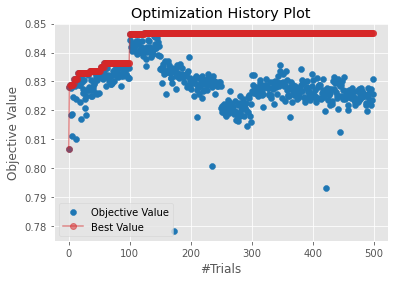

In [95]:
plot_optimization_history(study_xgb);

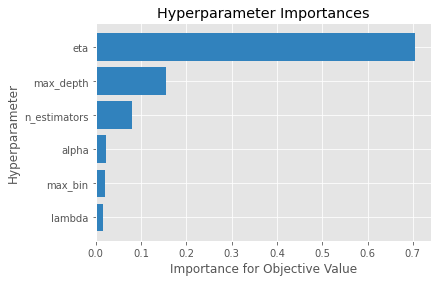

In [96]:
plot_param_importances(study_xgb);

In [97]:
detailed_objective_xgb_CV(study_xgb.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,165.100000,8.646772
1,TN,88.000000,6.289321
2,FP,25.400000,3.627059
3,FN,18.600000,4.325634
4,Accuracy,0.851914,0.023701
5,Precision,0.866378,0.020484
6,Sensitivity,0.898484,0.024362
7,Specificity,0.776000,0.028963
8,F1 score,0.882063,0.020658
9,F1 score (weighted),0.850982,0.023700


In [98]:
mat_met_xgb_test['ave'] = mat_met_xgb_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_xgb_test['std'] = mat_met_xgb_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_xgb_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,TP,335.000000,338.000000,320.000000,346.000000,344.000000,339.000000,322.000000,337.000000,335.000000,347.000000,336.300000,9.141481
1,TN,175.000000,166.000000,175.000000,162.000000,161.000000,172.000000,179.000000,178.000000,165.000000,162.000000,169.500000,7.043516
2,FP,49.000000,68.000000,49.000000,59.000000,64.000000,53.000000,53.000000,43.000000,62.000000,47.000000,54.700000,8.179242
3,FN,36.000000,23.000000,51.000000,28.000000,26.000000,31.000000,41.000000,37.000000,33.000000,39.000000,34.500000,8.195527
4,Accuracy,0.857143,0.847059,0.831933,0.853782,0.848739,0.858824,0.842017,0.865546,0.840336,0.855462,0.850084,0.010047
5,Precision,0.872396,0.832512,0.867209,0.854321,0.843137,0.864796,0.858667,0.886842,0.843829,0.880711,0.860442,0.017358
6,Sensitivity,0.902965,0.936288,0.862534,0.925134,0.929730,0.916216,0.887052,0.901070,0.910326,0.898964,0.907028,0.021834
7,Specificity,0.781200,0.709400,0.781200,0.733000,0.715600,0.764400,0.771600,0.805400,0.726900,0.775100,0.756380,0.032604
8,F1 score,0.887417,0.881356,0.864865,0.888318,0.884319,0.889764,0.872629,0.893899,0.875817,0.889744,0.882813,0.009128
9,F1 score (weighted),0.856238,0.843410,0.832079,0.851177,0.845458,0.857233,0.841204,0.865156,0.837915,0.854793,0.848466,0.010168


In [99]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_xgb=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = xgb.XGBClassifier(objective="binary:logistic",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_xgb.fit(X_train,y_train, 
            eval_set=eval_set,
            eval_metric=["logloss"],
            early_stopping_rounds=50,
            verbose= False,
                  )
                          
                  
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_xgb)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_xgb))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_xgb))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_xgb))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_xgb))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_xgb, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_xgb, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_xgb))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_xgb))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_xgb))
        
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_run0.reset_index(inplace=True, drop=True)
xgb_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_run1.reset_index(inplace=True, drop=True)
xgb_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_run2.reset_index(inplace=True, drop=True)
xgb_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_run3.reset_index(inplace=True, drop=True)
xgb_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_run4.reset_index(inplace=True, drop=True)
xgb_5preds = pd.concat([xgb_run0, xgb_run1, xgb_run2, xgb_run3, xgb_run4], axis=1)
xgb_5preds = xgb_5preds[['y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds['y_pred_xgb_ave'] = xgb_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds['y_pred_xgb_std'] = xgb_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
xgb_5preds

,y_test_idx0,y_test0,y_pred_xgb0,y_pred_xgb1,y_pred_xgb2,y_pred_xgb3,y_pred_xgb4,y_pred_xgb_ave,y_pred_xgb_std
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2966,2966,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2967,2967,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2968,2968,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2969,2969,1.0,1.0,0.0,0.0,0.0,0.0,0.2,0.4


In [100]:
mat_met_optimized_xgb.to_csv('mat_met_xgb_opt.csv')
xgb_5preds.to_csv('xgb_5test_CV_result.csv')

In [101]:
#cross valide using this optimized XGBoost 
fit_params = {'early_stopping_rounds': 50, 
            'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
              'verbose' : False,
             }

xgb_baseline_CVscore = cross_val_score(xgb_clf, X, Y, cv=10, scoring="f1_macro", )
#cv_xgb_opt_testSet = cross_val_score(optimized_xgb, X, Y, cv=10, scoring="f1_macro", fit_params = fit_params)
cv_xgb_opt = cross_val_score(optimizedCV_xgb, X, Y, cv=10, scoring="f1_macro", fit_params = fit_params)
print("XGBoost baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(xgb_baseline_CVscore), np.std(xgb_baseline_CVscore, ddof=1)))
#print("XGBoost optimized model (tested with Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (cv_xgb_opt_testSet.mean(), cv_xgb_opt_testSet.std()))
print("XGBoost optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_xgb_opt), np.std(cv_xgb_opt, ddof=1)))

[17:17:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [102]:
joblib.dump(xgb_clf, "./xgb_clf.joblib")
#joblib.dump(optimized_xgb, "./optimized_xgb.joblib")
joblib.dump(optimizedCV_xgb, "./optimizedCV_xgb_clf.joblib")


['./optimizedCV_xgb_clf.joblib']

## KNeighbors (KNN)

In [103]:
%%time


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    knn_clf = KNeighborsClassifier()
    
    knn_clf.fit(X_train,y_train)

    y_pred = knn_clf.predict(X_test) 
    
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test, y_pred)
    Precision[idx] = precision_score(y_test, y_pred)
    Sensitivity[idx] = recall_score(y_test, y_pred)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test, y_pred)
    f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
    f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
    MCC[idx] = matthews_corrcoef(y_test, y_pred)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    TP       165.400000     8.140434
1                    TN        80.500000     8.922506
2                    FP        32.900000     4.458450
3                    FN        18.300000     2.263233
4              Accuracy         0.827678     0.017518
5             Precision         0.834342     0.018525
6           Sensitivity         0.900050     0.014459
7           Specificity         0.708560     0.044901
8              F1 score         0.865845     0.013552
9   F1 score (weighted)         0.824855     0.018398
10     F1 score (macro)         0.811578     0.020611
11    Balanced Accuracy         0.804300     0.021952
12                  MCC         0.628236     0.039357
13                  NPV         0.814270     0.020775
14              ROC_AUC         0.804300     0.021952
CPU times: user 8.97 s, sys: 0 ns, total: 8.97 s
Wall time: 8.96 s


In [104]:
def objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 5, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        
    }
    
   
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsClassifier(**param_grid, n_jobs=16)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
    
    
        cv_scores[idx] = f1_score(y_test, y_pred, average='macro')
       
        
    return np.mean(cv_scores)

In [105]:
def detailed_objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 1, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggestegorical("device_type", ['gpu']),      
    }
    
  
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsClassifier(**param_grid, n_jobs=16)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
    

In [106]:
#Execute optuna and set hyperparameters
study_knn = optuna.create_study(direction='maximize', study_name="KNNClassifier")
func_knn_0 = lambda trial: objective_knn_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_knn.optimize(func_knn_0, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:18:18,444] A new study created in memory with name: KNNClassifier
[I 2023-02-20 17:18:19,816] Trial 0 finished with value: 0.7974945900679993 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 73}. Best is trial 0 with value: 0.7974945900679993.
[I 2023-02-20 17:18:21,183] Trial 1 finished with value: 0.805034416781886 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 97}. Best is trial 1 with value: 0.805034416781886.
[I 2023-02-20 17:18:22,572] Trial 2 finished with value: 0.8005900267291267 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 99}. Best is trial 1 with value: 0.805034416781886.
[I 2023-02-20 17:18:24,650] Trial 3 finished with value: 0.7945560427118943 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 29}. Best is trial 1 with value: 0.805034416781886.
[I 2023-02-20 17:18:26,733] 

[I 2023-02-20 17:19:15,069] Trial 35 finished with value: 0.7919497252938619 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 47}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:19:16,406] Trial 36 finished with value: 0.8082462907159634 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 78}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:19:17,805] Trial 37 finished with value: 0.7872666459161636 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 67}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:19:19,455] Trial 38 finished with value: 0.8094966100438808 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 54}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:19:21,161] Trial 39 finished with value: 0.7938873763167307 and parameters: {'n_neigh

	Number of trials: 50.0
	Best value (f1_score): 0.8171
	Best params:
		n_neighbors: 16
		weights: distance
		metric: manhattan
		leaf_size: 57


In [107]:
#Create an instance with tuned hyperparameters

optimized_knn_0 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_0.fit(X_trainSet0,Y_trainSet0, )

# predict
y_pred_knn_0 = optimized_knn_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_knn_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_knn_0)
Precision = precision_score(Y_testSet0, y_pred_knn_0)
Sensitivity = recall_score(Y_testSet0, y_pred_knn_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_knn_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_knn_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_knn_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_knn_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_knn_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_knn_0)
    

mat_met_knn_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_knn_test)


                 Metric        Set0
0                    TP  321.000000
1                    TN  174.000000
2                    FP   50.000000
3                    FN   50.000000
4              Accuracy    0.831933
5             Precision    0.865229
6           Sensitivity    0.865229
7           Specificity    0.776800
8              F1 score    0.865229
9   F1 score (weighted)    0.831933
10     F1 score (macro)    0.821007
11    Balanced Accuracy    0.821007
12                  MCC    0.642015
13                  NPV    0.776800
14              ROC_AUC    0.821007


In [108]:
#Execute optuna and set hyperparameters

func_knn_1 = lambda trial: objective_knn_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_knn.optimize(func_knn_1, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:19:38,950] Trial 50 finished with value: 0.8129330522661855 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 27}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:19:40,561] Trial 51 finished with value: 0.8080947426939386 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 56}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:19:42,190] Trial 52 finished with value: 0.8059709099249159 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 49}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:19:43,813] Trial 53 finished with value: 0.8060953920008934 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 62}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:19:45,476] Trial 54 finished with value: 0.8080947426939386 and parameters: {'n_nei

[I 2023-02-20 17:20:34,070] Trial 85 finished with value: 0.8062347327833583 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 92}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:20:35,733] Trial 86 finished with value: 0.8055793448363275 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 55}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:20:37,121] Trial 87 finished with value: 0.780693304580163 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 68}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:20:38,457] Trial 88 finished with value: 0.810451372244481 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 74}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:20:40,516] Trial 89 finished with value: 0.7925506766176074 and parameters: {'n_neighb

	Number of trials: 100.0
	Best value (f1_score): 0.8171
	Best params:
		n_neighbors: 16
		weights: distance
		metric: manhattan
		leaf_size: 57


In [109]:
#Create an instance with tuned hyperparameters

optimized_knn_1 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_1.fit(X_trainSet1,Y_trainSet1, )

# predict
y_pred_knn_1 = optimized_knn_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_knn_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_knn_1)
Precision = precision_score(Y_testSet1, y_pred_knn_1)
Sensitivity = recall_score(Y_testSet1, y_pred_knn_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_knn_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_knn_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_knn_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_knn_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_knn_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_knn_1)
    

set1 = pd.DataFrame({'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set1'] = set1
print(mat_met_knn_test)


                 Metric        Set0        Set1
0                    TP  321.000000  337.000000
1                    TN  174.000000  161.000000
2                    FP   50.000000   73.000000
3                    FN   50.000000   24.000000
4              Accuracy    0.831933    0.836975
5             Precision    0.865229    0.821951
6           Sensitivity    0.865229    0.933518
7           Specificity    0.776800    0.688000
8              F1 score    0.865229    0.874189
9   F1 score (weighted)    0.831933    0.832623
10     F1 score (macro)    0.821007    0.821343
11    Balanced Accuracy    0.821007    0.810776
12                  MCC    0.642015    0.655936
13                  NPV    0.776800    0.870300
14              ROC_AUC    0.821007    0.810776


In [110]:
#Execute optuna and set hyperparameters

func_knn_2 = lambda trial: objective_knn_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_knn.optimize(func_knn_2, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:20:56,323] Trial 100 finished with value: 0.7921481097919947 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 65}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:20:57,563] Trial 101 finished with value: 0.8166006433295848 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 79}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:20:58,816] Trial 102 finished with value: 0.8162156389882071 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 88}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:21:00,076] Trial 103 finished with value: 0.8109633582551112 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 87}. Best is trial 5 with value: 0.8171233411162863.
[I 2023-02-20 17:21:01,339] Trial 104 finished with value: 0.8162156389882071 and parameters: {'n

[I 2023-02-20 17:21:45,858] Trial 135 finished with value: 0.8162156389882071 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 75}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:21:47,136] Trial 136 finished with value: 0.8212919235819719 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 70}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:21:48,492] Trial 137 finished with value: 0.7945163590385306 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 71}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:21:49,817] Trial 138 finished with value: 0.8160706189122277 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 69}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:21:51,186] Trial 139 finished with value: 0.8089370286675411 and paramet

	Number of trials: 150.0
	Best value (f1_score): 0.8213
	Best params:
		n_neighbors: 13
		weights: distance
		metric: manhattan
		leaf_size: 67


In [111]:
#Create an instance with tuned hyperparameters

optimized_knn_2 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_2.fit(X_trainSet2,Y_trainSet2, )
#predict
y_pred_knn_2 = optimized_knn_2.predict(X_testSet2)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_knn_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_knn_2)
Precision = precision_score(Y_testSet2, y_pred_knn_2)
Sensitivity = recall_score(Y_testSet2, y_pred_knn_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_knn_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_knn_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_knn_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_knn_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_knn_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_knn_2)
    

Set2 = pd.DataFrame({'Set2':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set2'] = Set2
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2
0                    TP  321.000000  337.000000  324.000000
1                    TN  174.000000  161.000000  167.000000
2                    FP   50.000000   73.000000   57.000000
3                    FN   50.000000   24.000000   47.000000
4              Accuracy    0.831933    0.836975    0.825210
5             Precision    0.865229    0.821951    0.850394
6           Sensitivity    0.865229    0.933518    0.873315
7           Specificity    0.776800    0.688000    0.745500
8              F1 score    0.865229    0.874189    0.861702
9   F1 score (weighted)    0.831933    0.832623    0.824377
10     F1 score (macro)    0.821007    0.821343    0.812130
11    Balanced Accuracy    0.821007    0.810776    0.809426
12                  MCC    0.642015    0.655936    0.624781
13                  NPV    0.776800    0.870300    0.780400
14              ROC_AUC    0.821007    0.810776    0.809426


In [112]:
#Execute optuna and set hyperparameters

func_knn_3 = lambda trial: objective_knn_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_knn.optimize(func_knn_3, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:22:06,690] Trial 150 finished with value: 0.8043047559617935 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 70}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:22:08,167] Trial 151 finished with value: 0.8074086271873682 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 65}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:22:09,394] Trial 152 finished with value: 0.8080017699962475 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 73}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:22:10,667] Trial 153 finished with value: 0.8103042933652679 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 68}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:22:12,131] Trial 154 finished with value: 0.8068203088213934 and parame

[I 2023-02-20 17:22:53,940] Trial 184 finished with value: 0.8074086271873682 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 59}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:22:55,145] Trial 185 finished with value: 0.8080017699962475 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 77}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:22:56,615] Trial 186 finished with value: 0.8082608126472846 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 64}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:22:58,122] Trial 187 finished with value: 0.8097292606103348 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 55}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:22:59,640] Trial 188 finished with value: 0.7912196304796998 and parame

	Number of trials: 200.0
	Best value (f1_score): 0.8213
	Best params:
		n_neighbors: 13
		weights: distance
		metric: manhattan
		leaf_size: 67


In [113]:
#Create an instance with tuned hyperparameters

optimized_knn_3 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_3.fit(X_trainSet3,Y_trainSet3, )

# predict
y_pred_knn_3 = optimized_knn_3.predict(X_testSet3)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_knn_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_knn_3)
Precision = precision_score(Y_testSet3, y_pred_knn_3)
Sensitivity = recall_score(Y_testSet3, y_pred_knn_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_knn_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_knn_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_knn_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_knn_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_knn_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_knn_3)
    

Set3 = pd.DataFrame({'Set3':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set3'] = Set3
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  321.000000  337.000000  324.000000  336.000000
1                    TN  174.000000  161.000000  167.000000  165.000000
2                    FP   50.000000   73.000000   57.000000   56.000000
3                    FN   50.000000   24.000000   47.000000   38.000000
4              Accuracy    0.831933    0.836975    0.825210    0.842017
5             Precision    0.865229    0.821951    0.850394    0.857143
6           Sensitivity    0.865229    0.933518    0.873315    0.898396
7           Specificity    0.776800    0.688000    0.745500    0.746600
8              F1 score    0.865229    0.874189    0.861702    0.877285
9   F1 score (weighted)    0.831933    0.832623    0.824377    0.840520
10     F1 score (macro)    0.821007    0.821343    0.812130    0.827793
11    Balanced Accuracy    0.821007    0.810776    0.809426    0.822501
12                  MCC    0.642015    0.655936    0.624781    0

In [114]:
#Execute optuna and set hyperparameters

func_knn_4 = lambda trial: objective_knn_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_knn.optimize(func_knn_4, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:23:16,845] Trial 200 finished with value: 0.8135433485447774 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 66}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:23:18,461] Trial 201 finished with value: 0.8165986144259303 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 62}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:23:20,095] Trial 202 finished with value: 0.8165986144259303 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 63}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:23:21,427] Trial 203 finished with value: 0.816642359997358 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 67}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:23:23,086] Trial 204 finished with value: 0.8165986144259303 and paramet

[I 2023-02-20 17:24:08,394] Trial 235 finished with value: 0.8193022098753154 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 74}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:24:09,679] Trial 236 finished with value: 0.8175867993033625 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 76}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:24:11,000] Trial 237 finished with value: 0.816642359997358 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 79}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:24:12,268] Trial 238 finished with value: 0.8162663104534641 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 74}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:24:13,553] Trial 239 finished with value: 0.8175867993033625 and paramet

	Number of trials: 250.0
	Best value (f1_score): 0.8213
	Best params:
		n_neighbors: 13
		weights: distance
		metric: manhattan
		leaf_size: 67


In [115]:
#Create an instance with tuned hyperparameters

optimized_knn_4 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_4.fit(X_trainSet4,Y_trainSet4, )

# predict
y_pred_knn_4 = optimized_knn_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_knn_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_knn_4)
Precision = precision_score(Y_testSet4, y_pred_knn_4)
Sensitivity = recall_score(Y_testSet4, y_pred_knn_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_knn_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_knn_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_knn_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_knn_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_knn_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_knn_4)
    

Set4 = pd.DataFrame({'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set4'] = Set4
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  321.000000  337.000000  324.000000  336.000000   
1                    TN  174.000000  161.000000  167.000000  165.000000   
2                    FP   50.000000   73.000000   57.000000   56.000000   
3                    FN   50.000000   24.000000   47.000000   38.000000   
4              Accuracy    0.831933    0.836975    0.825210    0.842017   
5             Precision    0.865229    0.821951    0.850394    0.857143   
6           Sensitivity    0.865229    0.933518    0.873315    0.898396   
7           Specificity    0.776800    0.688000    0.745500    0.746600   
8              F1 score    0.865229    0.874189    0.861702    0.877285   
9   F1 score (weighted)    0.831933    0.832623    0.824377    0.840520   
10     F1 score (macro)    0.821007    0.821343    0.812130    0.827793   
11    Balanced Accuracy    0.821007    0.810776    0.809426    0.822501   
12                  MCC  

In [116]:
#Execute optuna and set hyperparameters

func_knn_5 = lambda trial: objective_knn_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_knn.optimize(func_knn_5, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:24:28,736] Trial 250 finished with value: 0.805727893864782 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 71}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:24:30,269] Trial 251 finished with value: 0.8049594506204212 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 63}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:24:31,845] Trial 252 finished with value: 0.8028189712486684 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 66}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:24:33,147] Trial 253 finished with value: 0.805727893864782 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 70}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:24:34,462] Trial 254 finished with value: 0.7955249691221893 and paramete

[I 2023-02-20 17:25:21,934] Trial 285 finished with value: 0.8083305012319775 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 66}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:25:23,236] Trial 286 finished with value: 0.8035427650301156 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 72}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:25:24,920] Trial 287 finished with value: 0.8030834544589004 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 64}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:25:26,308] Trial 288 finished with value: 0.805727893864782 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 68}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:25:27,971] Trial 289 finished with value: 0.8049594506204212 and paramet

	Number of trials: 300.0
	Best value (f1_score): 0.8213
	Best params:
		n_neighbors: 13
		weights: distance
		metric: manhattan
		leaf_size: 67


In [117]:
#Create an instance with tuned hyperparameters

optimized_knn_5 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_5.fit(X_trainSet5,Y_trainSet5, )

# predict
y_pred_knn_5 = optimized_knn_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_knn_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_knn_5)
Precision = precision_score(Y_testSet5, y_pred_knn_5)
Sensitivity = recall_score(Y_testSet5, y_pred_knn_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_knn_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_knn_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_knn_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_knn_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_knn_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_knn_5)
    

Set5 = pd.DataFrame({'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set5'] = Set5
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  321.000000  337.000000  324.000000  336.000000   
1                    TN  174.000000  161.000000  167.000000  165.000000   
2                    FP   50.000000   73.000000   57.000000   56.000000   
3                    FN   50.000000   24.000000   47.000000   38.000000   
4              Accuracy    0.831933    0.836975    0.825210    0.842017   
5             Precision    0.865229    0.821951    0.850394    0.857143   
6           Sensitivity    0.865229    0.933518    0.873315    0.898396   
7           Specificity    0.776800    0.688000    0.745500    0.746600   
8              F1 score    0.865229    0.874189    0.861702    0.877285   
9   F1 score (weighted)    0.831933    0.832623    0.824377    0.840520   
10     F1 score (macro)    0.821007    0.821343    0.812130    0.827793   
11    Balanced Accuracy    0.821007    0.810776    0.809426    0.822501   
12                  MCC  

In [118]:
#Execute optuna and set hyperparameters

func_knn_6 = lambda trial: objective_knn_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_knn.optimize(func_knn_6, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:25:45,007] Trial 300 finished with value: 0.8063990760175981 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 75}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:25:46,654] Trial 301 finished with value: 0.8108628346461204 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 64}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:25:48,035] Trial 302 finished with value: 0.8092790570387693 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 73}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:25:49,430] Trial 303 finished with value: 0.8113374597003855 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 67}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:25:50,787] Trial 304 finished with value: 0.8092790570387693 and parame

[I 2023-02-20 17:26:37,965] Trial 335 finished with value: 0.8076784512331528 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 59}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:26:39,342] Trial 336 finished with value: 0.8092790570387693 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 74}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:26:40,727] Trial 337 finished with value: 0.8049222022318127 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 76}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:26:42,381] Trial 338 finished with value: 0.8108628346461204 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 63}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:26:43,676] Trial 339 finished with value: 0.8063990760175981 and parame

	Number of trials: 350.0
	Best value (f1_score): 0.8213
	Best params:
		n_neighbors: 13
		weights: distance
		metric: manhattan
		leaf_size: 67


In [119]:
#Create an instance with tuned hyperparameters

optimized_knn_6 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_6.fit(X_trainSet6,Y_trainSet6, )

# predict
y_pred_knn_6 = optimized_knn_6.predict(X_testSet6)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_knn_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_knn_6)
Precision = precision_score(Y_testSet6, y_pred_knn_6)
Sensitivity = recall_score(Y_testSet6, y_pred_knn_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_knn_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_knn_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_knn_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_knn_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_knn_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_knn_6)
    

Set6 = pd.DataFrame({'Set6':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set6'] = Set6
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  321.000000  337.000000  324.000000  336.000000   
1                    TN  174.000000  161.000000  167.000000  165.000000   
2                    FP   50.000000   73.000000   57.000000   56.000000   
3                    FN   50.000000   24.000000   47.000000   38.000000   
4              Accuracy    0.831933    0.836975    0.825210    0.842017   
5             Precision    0.865229    0.821951    0.850394    0.857143   
6           Sensitivity    0.865229    0.933518    0.873315    0.898396   
7           Specificity    0.776800    0.688000    0.745500    0.746600   
8              F1 score    0.865229    0.874189    0.861702    0.877285   
9   F1 score (weighted)    0.831933    0.832623    0.824377    0.840520   
10     F1 score (macro)    0.821007    0.821343    0.812130    0.827793   
11    Balanced Accuracy    0.821007    0.810776    0.809426    0.822501   
12                  MCC  

In [120]:
#Execute optuna and set hyperparameters

func_knn_7 = lambda trial: objective_knn_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_knn.optimize(func_knn_7, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:27:00,255] Trial 350 finished with value: 0.8161067947700813 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 64}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:27:01,520] Trial 351 finished with value: 0.8123117359982419 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 69}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:27:03,026] Trial 352 finished with value: 0.8161067947700813 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 66}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:27:04,370] Trial 353 finished with value: 0.8161055219035485 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 72}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:27:05,628] Trial 354 finished with value: 0.812427914707148 and paramet

[I 2023-02-20 17:27:50,502] Trial 385 finished with value: 0.8161067947700813 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 64}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:27:51,985] Trial 386 finished with value: 0.8067872164444859 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 65}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:27:53,464] Trial 387 finished with value: 0.8161067947700813 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 63}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:27:54,978] Trial 388 finished with value: 0.7969990751116269 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 66}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:27:56,429] Trial 389 finished with value: 0.8161067947700813 and paramet

	Number of trials: 400.0
	Best value (f1_score): 0.8213
	Best params:
		n_neighbors: 13
		weights: distance
		metric: manhattan
		leaf_size: 67


In [121]:
#Create an instance with tuned hyperparameters

optimized_knn_7 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_7.fit(X_trainSet7,Y_trainSet7, )

# predict
y_pred_knn_7 = optimized_knn_7.predict(X_testSet7)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_knn_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_knn_7)
Precision = precision_score(Y_testSet7, y_pred_knn_7)
Sensitivity = recall_score(Y_testSet7, y_pred_knn_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_knn_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_knn_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_knn_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_knn_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_knn_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_knn_7)
    

Set7 = pd.DataFrame({'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set7'] = Set7
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  321.000000  337.000000  324.000000  336.000000   
1                    TN  174.000000  161.000000  167.000000  165.000000   
2                    FP   50.000000   73.000000   57.000000   56.000000   
3                    FN   50.000000   24.000000   47.000000   38.000000   
4              Accuracy    0.831933    0.836975    0.825210    0.842017   
5             Precision    0.865229    0.821951    0.850394    0.857143   
6           Sensitivity    0.865229    0.933518    0.873315    0.898396   
7           Specificity    0.776800    0.688000    0.745500    0.746600   
8              F1 score    0.865229    0.874189    0.861702    0.877285   
9   F1 score (weighted)    0.831933    0.832623    0.824377    0.840520   
10     F1 score (macro)    0.821007    0.821343    0.812130    0.827793   
11    Balanced Accuracy    0.821007    0.810776    0.809426    0.822501   
12                  MCC  

In [122]:
#Execute optuna and set hyperparameters

func_knn_8 = lambda trial: objective_knn_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_knn.optimize(func_knn_8, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:28:12,669] Trial 400 finished with value: 0.8101595096060914 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 67}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:28:14,048] Trial 401 finished with value: 0.8063114248016742 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 69}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:28:15,733] Trial 402 finished with value: 0.8081773162185927 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 58}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:28:17,415] Trial 403 finished with value: 0.8081064259189088 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 65}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:28:19,052] Trial 404 finished with value: 0.8157906467193333 and parame

[I 2023-02-20 17:29:07,853] Trial 435 finished with value: 0.8081773162185927 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 53}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:29:09,392] Trial 436 finished with value: 0.8157906467193333 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 56}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:29:10,773] Trial 437 finished with value: 0.8091400245181648 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 70}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:29:12,445] Trial 438 finished with value: 0.8063858065362846 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 61}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:29:14,113] Trial 439 finished with value: 0.8081773162185927 and paramet

	Number of trials: 450.0
	Best value (f1_score): 0.8213
	Best params:
		n_neighbors: 13
		weights: distance
		metric: manhattan
		leaf_size: 67


In [123]:
#Create an instance with tuned hyperparameters

optimized_knn_8 =  KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_8.fit(X_trainSet8,Y_trainSet8, )

# predict
y_pred_knn_8 = optimized_knn_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_knn_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_knn_8)
Precision = precision_score(Y_testSet8, y_pred_knn_8)
Sensitivity = recall_score(Y_testSet8, y_pred_knn_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_knn_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_knn_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_knn_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_knn_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_knn_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_knn_8)
    

Set8 = pd.DataFrame({'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set8'] = Set8
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  321.000000  337.000000  324.000000  336.000000   
1                    TN  174.000000  161.000000  167.000000  165.000000   
2                    FP   50.000000   73.000000   57.000000   56.000000   
3                    FN   50.000000   24.000000   47.000000   38.000000   
4              Accuracy    0.831933    0.836975    0.825210    0.842017   
5             Precision    0.865229    0.821951    0.850394    0.857143   
6           Sensitivity    0.865229    0.933518    0.873315    0.898396   
7           Specificity    0.776800    0.688000    0.745500    0.746600   
8              F1 score    0.865229    0.874189    0.861702    0.877285   
9   F1 score (weighted)    0.831933    0.832623    0.824377    0.840520   
10     F1 score (macro)    0.821007    0.821343    0.812130    0.827793   
11    Balanced Accuracy    0.821007    0.810776    0.809426    0.822501   
12                  MCC  

In [124]:
#Execute optuna and set hyperparameters

func_knn_9 = lambda trial: objective_knn_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_knn.optimize(func_knn_9, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (f1_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:29:31,014] Trial 450 finished with value: 0.8173649322635332 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 55}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:29:32,505] Trial 451 finished with value: 0.8166409109897703 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 64}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:29:33,726] Trial 452 finished with value: 0.8143202824453109 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 67}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:29:35,031] Trial 453 finished with value: 0.812471544803223 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 71}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:29:36,515] Trial 454 finished with value: 0.8190838771121683 and paramet

[I 2023-02-20 17:30:20,392] Trial 485 finished with value: 0.8190838771121683 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 50}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:30:21,890] Trial 486 finished with value: 0.8190838771121683 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 57}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:30:23,341] Trial 487 finished with value: 0.8190838771121683 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 64}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:30:24,627] Trial 488 finished with value: 0.8141733168017039 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 68}. Best is trial 129 with value: 0.8212919235819719.
[I 2023-02-20 17:30:25,934] Trial 489 finished with value: 0.814437570919158 and paramet

	Number of trials: 500.0
	Best value (f1_score): 0.8213
	Best params:
		n_neighbors: 13
		weights: distance
		metric: manhattan
		leaf_size: 67


In [125]:
#Create an instance with tuned hyperparameters

optimized_knn_9 = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_9.fit(X_trainSet9,Y_trainSet9, )

# predict
y_pred_knn_9 = optimized_knn_9.predict(X_testSet9)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_knn_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_knn_9)
Precision = precision_score(Y_testSet9, y_pred_knn_9)
Sensitivity = recall_score(Y_testSet9, y_pred_knn_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_knn_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_knn_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_knn_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_knn_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_knn_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_knn_9)
    

Set9 = pd.DataFrame({'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set9'] = Set9
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  321.000000  337.000000  324.000000  336.000000   
1                    TN  174.000000  161.000000  167.000000  165.000000   
2                    FP   50.000000   73.000000   57.000000   56.000000   
3                    FN   50.000000   24.000000   47.000000   38.000000   
4              Accuracy    0.831933    0.836975    0.825210    0.842017   
5             Precision    0.865229    0.821951    0.850394    0.857143   
6           Sensitivity    0.865229    0.933518    0.873315    0.898396   
7           Specificity    0.776800    0.688000    0.745500    0.746600   
8              F1 score    0.865229    0.874189    0.861702    0.877285   
9   F1 score (weighted)    0.831933    0.832623    0.824377    0.840520   
10     F1 score (macro)    0.821007    0.821343    0.812130    0.827793   
11    Balanced Accuracy    0.821007    0.810776    0.809426    0.822501   
12                  MCC  

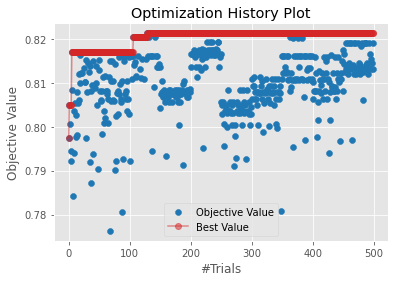

In [126]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_knn);

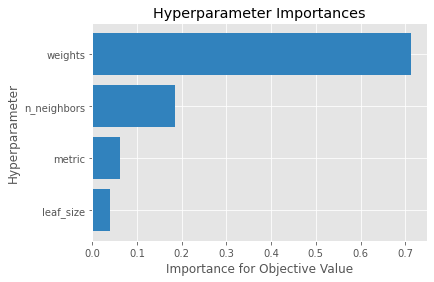

In [127]:

plot_param_importances(study_knn);

In [128]:
detailed_objective_knn_CV(study_knn.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,163.000000,7.731609
1,TN,83.400000,7.260242
2,FP,30.000000,2.788867
3,FN,20.700000,3.497618
4,Accuracy,0.829355,0.012725
5,Precision,0.844553,0.012933
6,Sensitivity,0.887157,0.020254
7,Specificity,0.734660,0.027849
8,F1 score,0.865185,0.011899
9,F1 score (weighted),0.827758,0.012702


In [129]:
mat_met_knn_test['ave'] = mat_met_knn_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_knn_test['std'] = mat_met_knn_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_knn_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,TP,321.000000,337.000000,324.000000,336.000000,339.000000,330.000000,333.000000,338.000000,331.000000,348.000000,333.700000,7.775317
1,TN,174.000000,161.000000,167.000000,165.000000,164.000000,161.000000,174.000000,162.000000,150.000000,156.000000,163.400000,7.366591
2,FP,50.000000,73.000000,57.000000,56.000000,61.000000,64.000000,58.000000,59.000000,77.000000,53.000000,60.800000,8.482662
3,FN,50.000000,24.000000,47.000000,38.000000,31.000000,40.000000,30.000000,36.000000,37.000000,38.000000,37.100000,7.709302
4,Accuracy,0.831933,0.836975,0.825210,0.842017,0.845378,0.825210,0.852101,0.840336,0.808403,0.847059,0.835462,0.013053
5,Precision,0.865229,0.821951,0.850394,0.857143,0.847500,0.837563,0.851662,0.851385,0.811275,0.867830,0.846193,0.017976
6,Sensitivity,0.865229,0.933518,0.873315,0.898396,0.916216,0.891892,0.917355,0.903743,0.899457,0.901554,0.900068,0.020259
7,Specificity,0.776800,0.688000,0.745500,0.746600,0.728900,0.715600,0.750000,0.733000,0.660800,0.746400,0.729160,0.033563
8,F1 score,0.865229,0.874189,0.861702,0.877285,0.880519,0.863874,0.883289,0.876783,0.853093,0.884371,0.872034,0.010457
9,F1 score (weighted),0.831933,0.832623,0.824377,0.840520,0.842868,0.823032,0.850098,0.838335,0.804086,0.845670,0.833354,0.013520


In [130]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_knn=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = KNeighborsClassifier(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )


        #learn
        
        optimizedCV_knn.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_knn)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_knn))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_knn))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_knn))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_knn))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_knn, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_knn, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_knn))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_knn))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_knn))
        
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_run0.sort_values(by='y_test_idx0', inplace=True)
knn_run0.reset_index(inplace=True, drop=True)
knn_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_run1.sort_values(by='y_test_idx1', inplace=True)
knn_run1.reset_index(inplace=True, drop=True)
knn_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_run2.sort_values(by='y_test_idx2', inplace=True)
knn_run2.reset_index(inplace=True, drop=True)
knn_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_run3.sort_values(by='y_test_idx3', inplace=True)
knn_run3.reset_index(inplace=True, drop=True)
knn_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_run4.sort_values(by='y_test_idx4', inplace=True)
knn_run4.reset_index(inplace=True, drop=True)
knn_5preds = pd.concat([knn_run0, knn_run1, knn_run2, knn_run3, knn_run4], axis=1)
knn_5preds = knn_5preds[['y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds['y_pred_knn_ave'] = knn_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds['y_pred_knn_std'] = knn_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
knn_5preds

,y_test_idx0,y_test0,y_pred_knn0,y_pred_knn1,y_pred_knn2,y_pred_knn3,y_pred_knn4,y_pred_knn_ave,y_pred_knn_std
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
4,4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...
2966,2966,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
2967,2967,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
2968,2968,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
2969,2969,1.0,1.0,0.0,1.0,1.0,0.0,0.6,0.489898


In [131]:
mat_met_optimized_knn.to_csv('mat_met_knn_opt.csv')
knn_5preds.to_csv('knn_5test_CV_result.csv')

In [132]:
#cross valide using this optimized KNN 
knn_baseline_CVscore = cross_val_score(knn_clf, X, Y, cv=10, scoring="f1_macro")
#cv_knn_opt_testSet = cross_val_score(optimized_knn, X, Y, cv=10, scoring="f1_macro")
cv_knn_opt = cross_val_score(optimizedCV_knn, X, Y, cv=10, scoring="f1_macro")
print("KNN baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(knn_baseline_CVscore), np.std(knn_baseline_CVscore, ddof=1)))
#print("KNN optimized model (tested on Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (cv_knn_opt_testSet.mean(), cv_knn_opt_testSet.std()))
print("KNN optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_knn_opt), np.std(cv_knn_opt, ddof=1)))

KNN baseline model f1_score 0.8107 with a standard deviation of 0.0306
KNN optimized model f1_score 0.8224 with a standard deviation of 0.0273


In [133]:
joblib.dump(knn_clf, "./knn_clf.joblib")
#joblib.dump(optimized_knn, "./optimized_knn.joblib")
joblib.dump(optimizedCV_knn, "./optimizedCV_knn_clf.joblib")
#loaded_rf = joblib.load("./optimized_rf.joblib")

['./optimizedCV_knn_clf.joblib']

## Support Vector 

In [134]:
%%time


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    svm_clf = SVC()
    
    svm_clf.fit(X_train, y_train, )

    y_pred = svm_clf.predict(X_test) 
   
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test, y_pred)
    Precision[idx] = precision_score(y_test, y_pred)
    Sensitivity[idx] = recall_score(y_test, y_pred)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test, y_pred)
    f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
    f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
    MCC[idx] = matthews_corrcoef(y_test, y_pred)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    TP       165.800000     8.093893
1                    TN        85.300000     6.000926
2                    FP        28.100000     3.247221
3                    FN        17.900000     3.725289
4              Accuracy         0.845170     0.013838
5             Precision         0.854949     0.016387
6           Sensitivity         0.902357     0.020730
7           Specificity         0.752150     0.025653
8              F1 score         0.877850     0.013504
9   F1 score (weighted)         0.843590     0.013733
10     F1 score (macro)         0.832656     0.013187
11    Balanced Accuracy         0.827256     0.012672
12                  MCC         0.668273     0.026500
13                  NPV         0.827510     0.029490
14              ROC_AUC         0.827256     0.012672
CPU times: user 37.1 s, sys: 0 ns, total: 37.1 s
Wall time: 37.1 s


In [135]:
def objective_svm_CV(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggestegorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggestegorical("device_type", ['gpu'])
        
    }
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVC(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
    
    
        cv_scores[idx] = f1_score(y_test, y_pred, average='macro')
       
        
    return np.mean(cv_scores)


In [136]:
def detailed_objective_svm_cv(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggestegorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggestegorical("device_type", ['gpu']),
        
    }
    
  
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVC(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
        
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test, y_pred)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test, y_pred)
        Precision[idx] = precision_score(y_test, y_pred)
        Sensitivity[idx] = recall_score(y_test, y_pred)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test, y_pred)
        f1_scores_W[idx] = f1_score(y_test, y_pred, average="weighted")
        f1_scores_M[idx] = f1_score(y_test, y_pred, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test, y_pred)
        MCC[idx] = matthews_corrcoef(y_test, y_pred)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test, y_pred)


    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
   

In [137]:
#Execute optuna and set hyperparameters
study_svm = optuna.create_study(direction='maximize', study_name="SVM_classifier")
func_svm_0 = lambda trial: objective_svm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_svm.optimize(func_svm_0, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:31:47,005] A new study created in memory with name: SVM_classifier
[I 2023-02-20 17:32:22,165] Trial 0 finished with value: 0.4538268466761636 and parameters: {'C': 4.0, 'gamma': 0.25}. Best is trial 0 with value: 0.4538268466761636.
[I 2023-02-20 17:32:52,291] Trial 1 finished with value: 0.38141973614934377 and parameters: {'C': 0.125, 'gamma': 6.103515625e-05}. Best is trial 0 with value: 0.4538268466761636.
[I 2023-02-20 17:33:27,329] Trial 2 finished with value: 0.4398772108379528 and parameters: {'C': 128.0, 'gamma': 0.5}. Best is trial 0 with value: 0.4538268466761636.
[I 2023-02-20 17:33:57,541] Trial 3 finished with value: 0.38141973614934377 and parameters: {'C': 0.5, 'gamma': 3.0517578125e-05}. Best is trial 0 with value: 0.4538268466761636.
[I 2023-02-20 17:34:27,726] Trial 4 finished with value: 0.38141973614934377 and parameters: {'C': 0.25, 'gamma': 6.103515625e-05}. Best is trial 0 with value: 0.4538268466761636.
[I 2023-02-20 17:35:01,568] Trial 5 fini

[I 2023-02-20 17:53:46,926] Trial 44 finished with value: 0.4398772108379528 and parameters: {'C': 64.0, 'gamma': 0.5}. Best is trial 37 with value: 0.8292393344141649.
[I 2023-02-20 17:54:21,845] Trial 45 finished with value: 0.4165755689975767 and parameters: {'C': 64.0, 'gamma': 2.0}. Best is trial 37 with value: 0.8292393344141649.
[I 2023-02-20 17:54:55,567] Trial 46 finished with value: 0.8292393344141649 and parameters: {'C': 64.0, 'gamma': 0.03125}. Best is trial 37 with value: 0.8292393344141649.
[I 2023-02-20 17:55:29,315] Trial 47 finished with value: 0.8292393344141649 and parameters: {'C': 64.0, 'gamma': 0.03125}. Best is trial 37 with value: 0.8292393344141649.
[I 2023-02-20 17:56:04,352] Trial 48 finished with value: 0.4121765148307858 and parameters: {'C': 4.0, 'gamma': 4.0}. Best is trial 37 with value: 0.8292393344141649.
[I 2023-02-20 17:56:33,805] Trial 49 finished with value: 0.38141973614934377 and parameters: {'C': 0.5, 'gamma': 0.000244140625}. Best is trial 37 

	Number of trials: 50.0
	Best value (f1_score): 0.8292
	Best params:
		C: 64.0
		gamma: 0.03125


In [138]:
#Create an instance with tuned hyperparameters

optimized_svm_0 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_0.fit(X_trainSet0,Y_trainSet0,)

# predict
y_pred_svm_0 = optimized_svm_0.predict(X_testSet0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0, y_pred_svm_0)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0, y_pred_svm_0)
Precision = precision_score(Y_testSet0, y_pred_svm_0)
Sensitivity = recall_score(Y_testSet0, y_pred_svm_0)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0, y_pred_svm_0)      
f1_scores_W = f1_score(Y_testSet0, y_pred_svm_0, average="weighted")
f1_scores_M = f1_score(Y_testSet0, y_pred_svm_0, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0, y_pred_svm_0)
MCC = matthews_corrcoef(Y_testSet0, y_pred_svm_0)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0, y_pred_svm_0)
    

mat_met_svm_test = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_svm_test)


                 Metric        Set0
0                    TP  328.000000
1                    TN  176.000000
2                    FP   48.000000
3                    FN   43.000000
4              Accuracy    0.847059
5             Precision    0.872340
6           Sensitivity    0.884097
7           Specificity    0.785700
8              F1 score    0.878179
9   F1 score (weighted)    0.846708
10     F1 score (macro)    0.836381
11    Balanced Accuracy    0.834906
12                  MCC    0.672895
13                  NPV    0.803700
14              ROC_AUC    0.834906


In [139]:
#Execute optuna and set hyperparameters
func_svm_1 = lambda trial: objective_svm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_svm.optimize(func_svm_1, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 17:57:13,027] Trial 50 finished with value: 0.6346265578758455 and parameters: {'C': 64.0, 'gamma': 0.125}. Best is trial 37 with value: 0.8292393344141649.
[I 2023-02-20 17:57:46,026] Trial 51 finished with value: 0.8379368086361559 and parameters: {'C': 64.0, 'gamma': 0.03125}. Best is trial 51 with value: 0.8379368086361559.
[I 2023-02-20 17:58:19,263] Trial 52 finished with value: 0.8379368086361559 and parameters: {'C': 64.0, 'gamma': 0.03125}. Best is trial 51 with value: 0.8379368086361559.
[I 2023-02-20 17:58:54,261] Trial 53 finished with value: 0.38305499462024917 and parameters: {'C': 0.125, 'gamma': 8.0}. Best is trial 51 with value: 0.8379368086361559.
[I 2023-02-20 17:59:12,649] Trial 54 finished with value: 0.8189542005343423 and parameters: {'C': 64.0, 'gamma': 0.00048828125}. Best is trial 51 with value: 0.8379368086361559.
[I 2023-02-20 17:59:43,704] Trial 55 finished with value: 0.38305499462024917 and parameters: {'C': 0.015625, 'gamma': 0.03125}. Best

[I 2023-02-20 18:18:45,723] Trial 94 finished with value: 0.804019174238406 and parameters: {'C': 0.5, 'gamma': 0.015625}. Best is trial 60 with value: 0.8380668800853919.
[I 2023-02-20 18:19:20,597] Trial 95 finished with value: 0.6346265578758455 and parameters: {'C': 128.0, 'gamma': 0.125}. Best is trial 60 with value: 0.8380668800853919.
[I 2023-02-20 18:19:50,371] Trial 96 finished with value: 0.38305499462024917 and parameters: {'C': 0.125, 'gamma': 0.000244140625}. Best is trial 60 with value: 0.8380668800853919.
[I 2023-02-20 18:20:20,623] Trial 97 finished with value: 0.8380668800853919 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 60 with value: 0.8380668800853919.
[I 2023-02-20 18:20:55,924] Trial 98 finished with value: 0.40536374792921304 and parameters: {'C': 128.0, 'gamma': 4.0}. Best is trial 60 with value: 0.8380668800853919.
[I 2023-02-20 18:21:25,762] Trial 99 finished with value: 0.38305499462024917 and parameters: {'C': 0.015625, 'gamma': 0.0004882

	Number of trials: 100.0
	Best value (f1_score): 0.8381
	Best params:
		C: 128.0
		gamma: 0.015625


In [140]:
#Create an instance with tuned hyperparameters

optimized_svm_1 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_1.fit(X_trainSet1,Y_trainSet1,)

# predict
y_pred_svm_1 = optimized_svm_1.predict(X_testSet1)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1, y_pred_svm_1)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1, y_pred_svm_1)
Precision = precision_score(Y_testSet1, y_pred_svm_1)
Sensitivity = recall_score(Y_testSet1, y_pred_svm_1)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1, y_pred_svm_1)      
f1_scores_W = f1_score(Y_testSet1, y_pred_svm_1, average="weighted")
f1_scores_M = f1_score(Y_testSet1, y_pred_svm_1, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1, y_pred_svm_1)
MCC = matthews_corrcoef(Y_testSet1, y_pred_svm_1)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1, y_pred_svm_1)
    

set1 = pd.DataFrame({'Set1':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set1'] = set1
print(mat_met_svm_test)


                 Metric        Set0        Set1
0                    TP  328.000000  338.000000
1                    TN  176.000000  169.000000
2                    FP   48.000000   65.000000
3                    FN   43.000000   23.000000
4              Accuracy    0.847059    0.852101
5             Precision    0.872340    0.838710
6           Sensitivity    0.884097    0.936288
7           Specificity    0.785700    0.722200
8              F1 score    0.878179    0.884817
9   F1 score (weighted)    0.846708    0.848875
10     F1 score (macro)    0.836381    0.839122
11    Balanced Accuracy    0.834906    0.829255
12                  MCC    0.672895    0.688052
13                  NPV    0.803700    0.880200
14              ROC_AUC    0.834906    0.829255


In [141]:
#Execute optuna and set hyperparameters
func_svm_2 = lambda trial: objective_svm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_svm.optimize(func_svm_2, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 18:22:04,619] Trial 100 finished with value: 0.3814109693472025 and parameters: {'C': 0.03125, 'gamma': 8.0}. Best is trial 60 with value: 0.8380668800853919.
[I 2023-02-20 18:22:34,124] Trial 101 finished with value: 0.838029382768379 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 60 with value: 0.8380668800853919.
[I 2023-02-20 18:23:03,766] Trial 102 finished with value: 0.838029382768379 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 60 with value: 0.8380668800853919.
[I 2023-02-20 18:23:33,302] Trial 103 finished with value: 0.8377975832920876 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 60 with value: 0.8380668800853919.
[I 2023-02-20 18:24:08,262] Trial 104 finished with value: 0.4259949099817691 and parameters: {'C': 128.0, 'gamma': 1.0}. Best is trial 60 with value: 0.8380668800853919.
[I 2023-02-20 18:24:34,995] Trial 105 finished with value: 0.8263801455415063 and parameters: {'C': 128.0, 'gamma': 0.0078125}. Best

[I 2023-02-20 18:42:36,255] Trial 144 finished with value: 0.8464827775814934 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 18:43:00,875] Trial 145 finished with value: 0.8464827775814934 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 18:43:26,951] Trial 146 finished with value: 0.7407202535312497 and parameters: {'C': 2.0, 'gamma': 0.00048828125}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 18:43:51,548] Trial 147 finished with value: 0.8464827775814934 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 18:44:16,130] Trial 148 finished with value: 0.8464827775814934 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 18:44:40,703] Trial 149 finished with value: 0.8464827775814934 and parameters: {'C': 2.0, 'gamma': 0.0156

	Number of trials: 150.0
	Best value (f1_score): 0.8465
	Best params:
		C: 2.0
		gamma: 0.015625


In [142]:
#Create an instance with tuned hyperparameters

optimized_svm_2 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_2.fit(X_trainSet2,Y_trainSet2,)

# predict
y_pred_svm_2 = optimized_svm_2.predict(X_testSet2)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2, y_pred_svm_2)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2, y_pred_svm_2)
Precision = precision_score(Y_testSet2, y_pred_svm_2)
Sensitivity = recall_score(Y_testSet2, y_pred_svm_2)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2, y_pred_svm_2)      
f1_scores_W = f1_score(Y_testSet2, y_pred_svm_2, average="weighted")
f1_scores_M = f1_score(Y_testSet2, y_pred_svm_2, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2, y_pred_svm_2)
MCC = matthews_corrcoef(Y_testSet2, y_pred_svm_2)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2, y_pred_svm_2)
    

Set2 = pd.DataFrame({'Set2':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set2'] = Set2
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2
0                    TP  328.000000  338.000000  322.000000
1                    TN  176.000000  169.000000  171.000000
2                    FP   48.000000   65.000000   53.000000
3                    FN   43.000000   23.000000   49.000000
4              Accuracy    0.847059    0.852101    0.828571
5             Precision    0.872340    0.838710    0.858667
6           Sensitivity    0.884097    0.936288    0.867925
7           Specificity    0.785700    0.722200    0.763400
8              F1 score    0.878179    0.884817    0.863271
9   F1 score (weighted)    0.846708    0.848875    0.828259
10     F1 score (macro)    0.836381    0.839122    0.816771
11    Balanced Accuracy    0.834906    0.829255    0.815659
12                  MCC    0.672895    0.688052    0.633624
13                  NPV    0.803700    0.880200    0.777300
14              ROC_AUC    0.834906    0.829255    0.815659


In [143]:
#Execute optuna and set hyperparameters
func_svm_3 = lambda trial: objective_svm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_svm.optimize(func_svm_3, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 18:45:05,482] Trial 150 finished with value: 0.8271327456241042 and parameters: {'C': 2.0, 'gamma': 0.0078125}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 18:45:29,206] Trial 151 finished with value: 0.8263519870394699 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 18:45:53,013] Trial 152 finished with value: 0.8263519870394699 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 18:46:28,299] Trial 153 finished with value: 0.4235648043050209 and parameters: {'C': 2.0, 'gamma': 1.0}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 18:46:52,229] Trial 154 finished with value: 0.8263519870394699 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 18:47:16,087] Trial 155 finished with value: 0.8263519870394699 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best

[I 2023-02-20 19:04:33,544] Trial 194 finished with value: 0.8263519870394699 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:05:03,122] Trial 195 finished with value: 0.8205414374356839 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:05:23,837] Trial 196 finished with value: 0.8235112128511842 and parameters: {'C': 4.0, 'gamma': 0.0078125}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:05:47,625] Trial 197 finished with value: 0.8263519870394699 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:06:17,677] Trial 198 finished with value: 0.38100327888982694 and parameters: {'C': 0.125, 'gamma': 0.00048828125}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:06:54,337] Trial 199 finished with value: 0.4036423644705587 and parameters: {'C': 32.0, 'gamma': 

	Number of trials: 200.0
	Best value (f1_score): 0.8465
	Best params:
		C: 2.0
		gamma: 0.015625


In [144]:
#Create an instance with tuned hyperparameters

optimized_svm_3 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_3.fit(X_trainSet3,Y_trainSet3,)

# predict
y_pred_svm_3 = optimized_svm_3.predict(X_testSet3)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3, y_pred_svm_3)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3, y_pred_svm_3)
Precision = precision_score(Y_testSet3, y_pred_svm_3)
Sensitivity = recall_score(Y_testSet3, y_pred_svm_3)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3, y_pred_svm_3)      
f1_scores_W = f1_score(Y_testSet3, y_pred_svm_3, average="weighted")
f1_scores_M = f1_score(Y_testSet3, y_pred_svm_3, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3, y_pred_svm_3)
MCC = matthews_corrcoef(Y_testSet3, y_pred_svm_3)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3, y_pred_svm_3)
    

Set3 = pd.DataFrame({'Set3':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set3'] = Set3
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    TP  328.000000  338.000000  322.000000  344.000000
1                    TN  176.000000  169.000000  171.000000  166.000000
2                    FP   48.000000   65.000000   53.000000   55.000000
3                    FN   43.000000   23.000000   49.000000   30.000000
4              Accuracy    0.847059    0.852101    0.828571    0.857143
5             Precision    0.872340    0.838710    0.858667    0.862155
6           Sensitivity    0.884097    0.936288    0.867925    0.919786
7           Specificity    0.785700    0.722200    0.763400    0.751100
8              F1 score    0.878179    0.884817    0.863271    0.890039
9   F1 score (weighted)    0.846708    0.848875    0.828259    0.855171
10     F1 score (macro)    0.836381    0.839122    0.816771    0.843101
11    Balanced Accuracy    0.834906    0.829255    0.815659    0.835459
12                  MCC    0.672895    0.688052    0.633624    0

In [145]:
#Execute optuna and set hyperparameters
func_svm_4 = lambda trial: objective_svm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_svm.optimize(func_svm_4, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 19:07:21,734] Trial 200 finished with value: 0.8304526920416141 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:07:45,978] Trial 201 finished with value: 0.8304526920416141 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:08:11,299] Trial 202 finished with value: 0.8041578518193064 and parameters: {'C': 0.5, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:08:35,467] Trial 203 finished with value: 0.8304526920416141 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:08:58,110] Trial 204 finished with value: 0.7912527426852288 and parameters: {'C': 2.0, 'gamma': 0.001953125}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:09:33,308] Trial 205 finished with value: 0.42786331970711533 and parameters: {'C': 2.0, 'gamma': 1.0}. B

[I 2023-02-20 19:27:26,597] Trial 244 finished with value: 0.8227273576675234 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:28:01,498] Trial 245 finished with value: 0.6379012685660982 and parameters: {'C': 2.0, 'gamma': 0.125}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:28:31,268] Trial 246 finished with value: 0.8255355388830619 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:29:00,640] Trial 247 finished with value: 0.381611529060262 and parameters: {'C': 0.03125, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:29:24,592] Trial 248 finished with value: 0.8304526920416141 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:30:01,003] Trial 249 finished with value: 0.4171829006567741 and parameters: {'C': 128.0, 'gamma': 8.0}. B

	Number of trials: 250.0
	Best value (f1_score): 0.8465
	Best params:
		C: 2.0
		gamma: 0.015625


In [146]:
#Create an instance with tuned hyperparameters

optimized_svm_4 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_4.fit(X_trainSet4,Y_trainSet4,)

# predict
y_pred_svm_4 = optimized_svm_4.predict(X_testSet4)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4, y_pred_svm_4)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4, y_pred_svm_4)
Precision = precision_score(Y_testSet4, y_pred_svm_4)
Sensitivity = recall_score(Y_testSet4, y_pred_svm_4)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4, y_pred_svm_4)      
f1_scores_W = f1_score(Y_testSet4, y_pred_svm_4, average="weighted")
f1_scores_M = f1_score(Y_testSet4, y_pred_svm_4, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4, y_pred_svm_4)
MCC = matthews_corrcoef(Y_testSet4, y_pred_svm_4)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4, y_pred_svm_4)
    

Set4 = pd.DataFrame({'Set4':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set4'] = Set4
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  328.000000  338.000000  322.000000  344.000000   
1                    TN  176.000000  169.000000  171.000000  166.000000   
2                    FP   48.000000   65.000000   53.000000   55.000000   
3                    FN   43.000000   23.000000   49.000000   30.000000   
4              Accuracy    0.847059    0.852101    0.828571    0.857143   
5             Precision    0.872340    0.838710    0.858667    0.862155   
6           Sensitivity    0.884097    0.936288    0.867925    0.919786   
7           Specificity    0.785700    0.722200    0.763400    0.751100   
8              F1 score    0.878179    0.884817    0.863271    0.890039   
9   F1 score (weighted)    0.846708    0.848875    0.828259    0.855171   
10     F1 score (macro)    0.836381    0.839122    0.816771    0.843101   
11    Balanced Accuracy    0.834906    0.829255    0.815659    0.835459   
12                  MCC  

In [147]:
#Execute optuna and set hyperparameters
func_svm_5 = lambda trial: objective_svm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_svm.optimize(func_svm_5, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 19:30:25,911] Trial 250 finished with value: 0.8161192945751681 and parameters: {'C': 2.0, 'gamma': 0.0078125}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:30:51,855] Trial 251 finished with value: 0.72196840125225 and parameters: {'C': 2.0, 'gamma': 0.00048828125}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:31:16,161] Trial 252 finished with value: 0.8245144738636551 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:31:45,921] Trial 253 finished with value: 0.8179614419195893 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:32:10,299] Trial 254 finished with value: 0.8245144738636551 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:32:34,910] Trial 255 finished with value: 0.8145045337992398 and parameters: {'C': 1.0, 'gamma': 0.015

[I 2023-02-20 19:50:55,493] Trial 294 finished with value: 0.6536885249480522 and parameters: {'C': 2.0, 'gamma': 0.000244140625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:51:22,232] Trial 295 finished with value: 0.7703564714150263 and parameters: {'C': 0.25, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:51:51,164] Trial 296 finished with value: 0.4893067658145557 and parameters: {'C': 0.0625, 'gamma': 0.0078125}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:52:15,466] Trial 297 finished with value: 0.8245144738636551 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:52:50,318] Trial 298 finished with value: 0.4306461685362636 and parameters: {'C': 2.0, 'gamma': 1.0}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:53:20,026] Trial 299 finished with value: 0.8179614419195893 and parameters: {'C': 64.0, 'gamma': 0.01

	Number of trials: 300.0
	Best value (f1_score): 0.8465
	Best params:
		C: 2.0
		gamma: 0.015625


In [148]:
#Create an instance with tuned hyperparameters

optimized_svm_5 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_5.fit(X_trainSet5,Y_trainSet5,)

# predict
y_pred_svm_5 = optimized_svm_5.predict(X_testSet5)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5, y_pred_svm_5)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5, y_pred_svm_5)
Precision = precision_score(Y_testSet5, y_pred_svm_5)
Sensitivity = recall_score(Y_testSet5, y_pred_svm_5)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5, y_pred_svm_5)      
f1_scores_W = f1_score(Y_testSet5, y_pred_svm_5, average="weighted")
f1_scores_M = f1_score(Y_testSet5, y_pred_svm_5, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5, y_pred_svm_5)
MCC = matthews_corrcoef(Y_testSet5, y_pred_svm_5)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5, y_pred_svm_5)
    

Set5 = pd.DataFrame({'Set5':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set5'] = Set5
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  328.000000  338.000000  322.000000  344.000000   
1                    TN  176.000000  169.000000  171.000000  166.000000   
2                    FP   48.000000   65.000000   53.000000   55.000000   
3                    FN   43.000000   23.000000   49.000000   30.000000   
4              Accuracy    0.847059    0.852101    0.828571    0.857143   
5             Precision    0.872340    0.838710    0.858667    0.862155   
6           Sensitivity    0.884097    0.936288    0.867925    0.919786   
7           Specificity    0.785700    0.722200    0.763400    0.751100   
8              F1 score    0.878179    0.884817    0.863271    0.890039   
9   F1 score (weighted)    0.846708    0.848875    0.828259    0.855171   
10     F1 score (macro)    0.836381    0.839122    0.816771    0.843101   
11    Balanced Accuracy    0.834906    0.829255    0.815659    0.835459   
12                  MCC  

In [149]:
#Execute optuna and set hyperparameters
func_svm_6 = lambda trial: objective_svm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_svm.optimize(func_svm_6, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 19:53:52,946] Trial 300 finished with value: 0.8239530785298204 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:54:22,897] Trial 301 finished with value: 0.38275376827529983 and parameters: {'C': 0.0078125, 'gamma': 0.001953125}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:54:46,772] Trial 302 finished with value: 0.8368090520808777 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:55:10,596] Trial 303 finished with value: 0.8368090520808777 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:55:40,349] Trial 304 finished with value: 0.8239530785298204 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 19:56:01,553] Trial 305 finished with value: 0.8099488434432311 and parameters: {'C': 2.0, 'gamma

[I 2023-02-20 20:14:14,800] Trial 344 finished with value: 0.8368090520808777 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:14:44,418] Trial 345 finished with value: 0.8239530785298204 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:15:13,438] Trial 346 finished with value: 0.828524377993473 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:15:37,270] Trial 347 finished with value: 0.8368090520808777 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:15:58,497] Trial 348 finished with value: 0.8099488434432311 and parameters: {'C': 2.0, 'gamma': 0.00390625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:16:26,477] Trial 349 finished with value: 0.6842749468239582 and parameters: {'C': 0.125, 'gamma': 0.0156

	Number of trials: 350.0
	Best value (f1_score): 0.8465
	Best params:
		C: 2.0
		gamma: 0.015625


In [150]:
#Create an instance with tuned hyperparameters

optimized_svm_6 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_6.fit(X_trainSet6,Y_trainSet6,)

# predict
y_pred_svm_6 = optimized_svm_6.predict(X_testSet6)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6, y_pred_svm_6)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6, y_pred_svm_6)
Precision = precision_score(Y_testSet6, y_pred_svm_6)
Sensitivity = recall_score(Y_testSet6, y_pred_svm_6)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6, y_pred_svm_6)      
f1_scores_W = f1_score(Y_testSet6, y_pred_svm_6, average="weighted")
f1_scores_M = f1_score(Y_testSet6, y_pred_svm_6, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6, y_pred_svm_6)
MCC = matthews_corrcoef(Y_testSet6, y_pred_svm_6)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6, y_pred_svm_6)
    

Set6 = pd.DataFrame({'Set6':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set6'] = Set6
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  328.000000  338.000000  322.000000  344.000000   
1                    TN  176.000000  169.000000  171.000000  166.000000   
2                    FP   48.000000   65.000000   53.000000   55.000000   
3                    FN   43.000000   23.000000   49.000000   30.000000   
4              Accuracy    0.847059    0.852101    0.828571    0.857143   
5             Precision    0.872340    0.838710    0.858667    0.862155   
6           Sensitivity    0.884097    0.936288    0.867925    0.919786   
7           Specificity    0.785700    0.722200    0.763400    0.751100   
8              F1 score    0.878179    0.884817    0.863271    0.890039   
9   F1 score (weighted)    0.846708    0.848875    0.828259    0.855171   
10     F1 score (macro)    0.836381    0.839122    0.816771    0.843101   
11    Balanced Accuracy    0.834906    0.829255    0.815659    0.835459   
12                  MCC  

In [151]:
#Execute optuna and set hyperparameters
func_svm_7 = lambda trial: objective_svm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_svm.optimize(func_svm_7, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 20:17:04,562] Trial 350 finished with value: 0.8054750882939151 and parameters: {'C': 128.0, 'gamma': 0.0625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:17:28,750] Trial 351 finished with value: 0.8306608052438843 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:17:52,994] Trial 352 finished with value: 0.8306608052438843 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:18:17,423] Trial 353 finished with value: 0.7721281447163518 and parameters: {'C': 2.0, 'gamma': 0.0009765625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:18:47,001] Trial 354 finished with value: 0.8177498239827672 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:19:22,074] Trial 355 finished with value: 0.4659705708609157 and parameters: {'C': 128.0, 'gamma': 0.25

[I 2023-02-20 20:37:38,155] Trial 394 finished with value: 0.8087351494975865 and parameters: {'C': 0.5, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:38:02,541] Trial 395 finished with value: 0.7721281447163518 and parameters: {'C': 2.0, 'gamma': 0.0009765625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:38:32,047] Trial 396 finished with value: 0.815763079948832 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:38:56,254] Trial 397 finished with value: 0.8306608052438843 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:39:26,149] Trial 398 finished with value: 0.38099875219444457 and parameters: {'C': 0.015625, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:39:55,997] Trial 399 finished with value: 0.38099875219444457 and parameters: {'C': 2.0, 'gamma':

	Number of trials: 400.0
	Best value (f1_score): 0.8465
	Best params:
		C: 2.0
		gamma: 0.015625


In [152]:
#Create an instance with tuned hyperparameters

optimized_svm_7 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_7.fit(X_trainSet7,Y_trainSet7,)

# predict
y_pred_svm_7 = optimized_svm_7.predict(X_testSet7)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7, y_pred_svm_7)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7, y_pred_svm_7)
Precision = precision_score(Y_testSet7, y_pred_svm_7)
Sensitivity = recall_score(Y_testSet7, y_pred_svm_7)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7, y_pred_svm_7)      
f1_scores_W = f1_score(Y_testSet7, y_pred_svm_7, average="weighted")
f1_scores_M = f1_score(Y_testSet7, y_pred_svm_7, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7, y_pred_svm_7)
MCC = matthews_corrcoef(Y_testSet7, y_pred_svm_7)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7, y_pred_svm_7)
    

Set7 = pd.DataFrame({'Set7':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set7'] = Set7
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  328.000000  338.000000  322.000000  344.000000   
1                    TN  176.000000  169.000000  171.000000  166.000000   
2                    FP   48.000000   65.000000   53.000000   55.000000   
3                    FN   43.000000   23.000000   49.000000   30.000000   
4              Accuracy    0.847059    0.852101    0.828571    0.857143   
5             Precision    0.872340    0.838710    0.858667    0.862155   
6           Sensitivity    0.884097    0.936288    0.867925    0.919786   
7           Specificity    0.785700    0.722200    0.763400    0.751100   
8              F1 score    0.878179    0.884817    0.863271    0.890039   
9   F1 score (weighted)    0.846708    0.848875    0.828259    0.855171   
10     F1 score (macro)    0.836381    0.839122    0.816771    0.843101   
11    Balanced Accuracy    0.834906    0.829255    0.815659    0.835459   
12                  MCC  

In [153]:
#Execute optuna and set hyperparameters
func_svm_8 = lambda trial: objective_svm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_svm.optimize(func_svm_8, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 20:40:28,423] Trial 400 finished with value: 0.8256214657736445 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:41:03,254] Trial 401 finished with value: 0.4591197278199374 and parameters: {'C': 128.0, 'gamma': 0.25}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:41:32,686] Trial 402 finished with value: 0.38198555429042685 and parameters: {'C': 0.03125, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:41:56,501] Trial 403 finished with value: 0.8313256792618462 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:42:25,249] Trial 404 finished with value: 0.5092066194969794 and parameters: {'C': 2.0, 'gamma': 0.0001220703125}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 20:42:54,334] Trial 405 finished with value: 0.8265671977763256 and parameters: {'C': 128.0, 'gamma':

[I 2023-02-20 21:00:35,101] Trial 444 finished with value: 0.8313256792618462 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:01:04,383] Trial 445 finished with value: 0.8265671977763256 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:01:33,197] Trial 446 finished with value: 0.5092066194969794 and parameters: {'C': 2.0, 'gamma': 0.0001220703125}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:01:57,020] Trial 447 finished with value: 0.8313256792618462 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:02:21,065] Trial 448 finished with value: 0.8210536055757881 and parameters: {'C': 1.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:02:54,711] Trial 449 finished with value: 0.38198555429042685 and parameters: {'C': 0.25, 'gamma': 

	Number of trials: 450.0
	Best value (f1_score): 0.8465
	Best params:
		C: 2.0
		gamma: 0.015625


In [154]:
#Create an instance with tuned hyperparameters

optimized_svm_8 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_8.fit(X_trainSet8,Y_trainSet8,)

# predict
y_pred_svm_8 = optimized_svm_8.predict(X_testSet8)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8, y_pred_svm_8)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8, y_pred_svm_8)
Precision = precision_score(Y_testSet8, y_pred_svm_8)
Sensitivity = recall_score(Y_testSet8, y_pred_svm_8)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8, y_pred_svm_8)      
f1_scores_W = f1_score(Y_testSet8, y_pred_svm_8, average="weighted")
f1_scores_M = f1_score(Y_testSet8, y_pred_svm_8, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8, y_pred_svm_8)
MCC = matthews_corrcoef(Y_testSet8, y_pred_svm_8)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8, y_pred_svm_8)
    

Set8 = pd.DataFrame({'Set8':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set8'] = Set8
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  328.000000  338.000000  322.000000  344.000000   
1                    TN  176.000000  169.000000  171.000000  166.000000   
2                    FP   48.000000   65.000000   53.000000   55.000000   
3                    FN   43.000000   23.000000   49.000000   30.000000   
4              Accuracy    0.847059    0.852101    0.828571    0.857143   
5             Precision    0.872340    0.838710    0.858667    0.862155   
6           Sensitivity    0.884097    0.936288    0.867925    0.919786   
7           Specificity    0.785700    0.722200    0.763400    0.751100   
8              F1 score    0.878179    0.884817    0.863271    0.890039   
9   F1 score (weighted)    0.846708    0.848875    0.828259    0.855171   
10     F1 score (macro)    0.836381    0.839122    0.816771    0.843101   
11    Balanced Accuracy    0.834906    0.829255    0.815659    0.835459   
12                  MCC  

In [155]:
#Execute optuna and set hyperparameters
func_svm_9 = lambda trial: objective_svm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_svm.optimize(func_svm_9, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (f1_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-20 21:03:27,821] Trial 450 finished with value: 0.37885438617570827 and parameters: {'C': 2.0, 'gamma': 6.103515625e-05}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:03:57,255] Trial 451 finished with value: 0.8254943468030342 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:04:21,265] Trial 452 finished with value: 0.8292360722785809 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:04:45,143] Trial 453 finished with value: 0.8292360722785809 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:05:19,995] Trial 454 finished with value: 0.4160921839212398 and parameters: {'C': 128.0, 'gamma': 2.0}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:05:43,849] Trial 455 finished with value: 0.8292360722785809 and parameters: {'C': 2.0, 'gamma': 0.01

[I 2023-02-20 21:23:40,378] Trial 494 finished with value: 0.8292360722785809 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:24:10,057] Trial 495 finished with value: 0.4853618458682714 and parameters: {'C': 0.0625, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:24:34,095] Trial 496 finished with value: 0.8292360722785809 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:25:09,020] Trial 497 finished with value: 0.4160921839212398 and parameters: {'C': 128.0, 'gamma': 2.0}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:25:33,015] Trial 498 finished with value: 0.8292360722785809 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 119 with value: 0.8464827775814934.
[I 2023-02-20 21:26:02,688] Trial 499 finished with value: 0.8259064896910097 and parameters: {'C': 16.0, 'gamma': 0.015625}.

	Number of trials: 500.0
	Best value (f1_score): 0.8465
	Best params:
		C: 2.0
		gamma: 0.015625


In [156]:
#Create an instance with tuned hyperparameters

optimized_svm_9 = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_9.fit(X_trainSet9,Y_trainSet9,)

# predict
y_pred_svm_9 = optimized_svm_9.predict(X_testSet9)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9, y_pred_svm_9)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9, y_pred_svm_9)
Precision = precision_score(Y_testSet9, y_pred_svm_9)
Sensitivity = recall_score(Y_testSet9, y_pred_svm_9)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9, y_pred_svm_9)      
f1_scores_W = f1_score(Y_testSet9, y_pred_svm_9, average="weighted")
f1_scores_M = f1_score(Y_testSet9, y_pred_svm_9, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9, y_pred_svm_9)
MCC = matthews_corrcoef(Y_testSet9, y_pred_svm_9)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9, y_pred_svm_9)
    

Set9 = pd.DataFrame({'Set9':[np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set9'] = Set9
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    TP  328.000000  338.000000  322.000000  344.000000   
1                    TN  176.000000  169.000000  171.000000  166.000000   
2                    FP   48.000000   65.000000   53.000000   55.000000   
3                    FN   43.000000   23.000000   49.000000   30.000000   
4              Accuracy    0.847059    0.852101    0.828571    0.857143   
5             Precision    0.872340    0.838710    0.858667    0.862155   
6           Sensitivity    0.884097    0.936288    0.867925    0.919786   
7           Specificity    0.785700    0.722200    0.763400    0.751100   
8              F1 score    0.878179    0.884817    0.863271    0.890039   
9   F1 score (weighted)    0.846708    0.848875    0.828259    0.855171   
10     F1 score (macro)    0.836381    0.839122    0.816771    0.843101   
11    Balanced Accuracy    0.834906    0.829255    0.815659    0.835459   
12                  MCC  

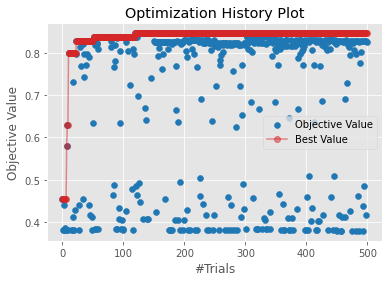

In [157]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_svm);

In [158]:
#from optuna.visualization.matplotlib import plot_param_importances

#plot_param_importances(study_svm);

In [159]:
detailed_objective_svm_cv(study_svm.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,TP,166.200000,7.871185
1,TN,86.600000,5.168279
2,FP,26.800000,3.552777
3,FN,17.500000,3.836955
4,Accuracy,0.850904,0.019053
5,Precision,0.860885,0.019969
6,Sensitivity,0.904600,0.021097
7,Specificity,0.764030,0.025161
8,F1 score,0.882076,0.017169
9,F1 score (weighted),0.849582,0.019037


In [160]:
mat_met_svm_test['ave'] = mat_met_svm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_svm_test['std'] = mat_met_svm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_svm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,TP,328.000000,338.000000,322.000000,344.000000,345.000000,343.000000,328.000000,344.000000,342.000000,341.000000,337.500000,8.329999
1,TN,176.000000,169.000000,171.000000,166.000000,166.000000,171.000000,175.000000,173.000000,159.000000,160.000000,168.600000,5.834762
2,FP,48.000000,65.000000,53.000000,55.000000,59.000000,54.000000,57.000000,48.000000,68.000000,49.000000,55.600000,6.866990
3,FN,43.000000,23.000000,49.000000,30.000000,25.000000,27.000000,35.000000,30.000000,26.000000,45.000000,33.300000,9.250225
4,Accuracy,0.847059,0.852101,0.828571,0.857143,0.858824,0.863866,0.845378,0.868908,0.842017,0.842017,0.850588,0.012001
5,Precision,0.872340,0.838710,0.858667,0.862155,0.853960,0.863980,0.851948,0.877551,0.834146,0.874359,0.858782,0.014518
6,Sensitivity,0.884097,0.936288,0.867925,0.919786,0.932432,0.927027,0.903581,0.919786,0.929348,0.883420,0.910369,0.024124
7,Specificity,0.785700,0.722200,0.763400,0.751100,0.737800,0.760000,0.754300,0.782800,0.700400,0.765600,0.752330,0.026290
8,F1 score,0.878179,0.884817,0.863271,0.890039,0.891473,0.894394,0.877005,0.898172,0.879177,0.878866,0.883539,0.010338
9,F1 score (weighted),0.846708,0.848875,0.828259,0.855171,0.856155,0.861917,0.843804,0.867665,0.838229,0.841661,0.848844,0.011722


In [161]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)


Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_svm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = SVC(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )


        #learn
        
        optimizedCV_svm.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        
        conf_matrix = confusion_matrix(y_test, y_pred_optimized_svm)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        Accuracy_outer.append(accuracy_score(y_test, y_pred_optimized_svm))
        Precision_outer.append(precision_score(y_test, y_pred_optimized_svm))
        Sensitivity_outer.append(recall_score(y_test, y_pred_optimized_svm))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test, y_pred_optimized_svm))
        f1_scores_W_outer.append(f1_score(y_test, y_pred_optimized_svm, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test, y_pred_optimized_svm, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test, y_pred_optimized_svm))
        MCC_outer.append(matthews_corrcoef(y_test, y_pred_optimized_svm))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test, y_pred_optimized_svm))
        
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[ np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [ np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_run0.sort_values(by='y_test_idx0', inplace=True)
svm_run0.reset_index(inplace=True, drop=True)
svm_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_run1.sort_values(by='y_test_idx1', inplace=True)
svm_run1.reset_index(inplace=True, drop=True)
svm_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_run2.sort_values(by='y_test_idx2', inplace=True)
svm_run2.reset_index(inplace=True, drop=True)
svm_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_run3.sort_values(by='y_test_idx3', inplace=True)
svm_run3.reset_index(inplace=True, drop=True)
svm_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_run4.sort_values(by='y_test_idx4', inplace=True)
svm_run4.reset_index(inplace=True, drop=True)
svm_5preds = pd.concat([svm_run0, svm_run1, svm_run2, svm_run3, svm_run4], axis=1)
svm_5preds = svm_5preds[['y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds['y_pred_svm_ave'] = svm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds['y_pred_svm_std'] = svm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
svm_5preds

,y_test_idx0,y_test0,y_pred_svm0,y_pred_svm1,y_pred_svm2,y_pred_svm3,y_pred_svm4,y_pred_svm_ave,y_pred_svm_std
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2966,2966,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2967,2967,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2968,2968,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2969,2969,1.0,1.0,0.0,0.0,0.0,0.0,0.2,0.4


In [162]:
mat_met_optimized_svm.to_csv('mat_met_svm_opt.csv')
svm_5preds.to_csv('svm_5test_CV_result.csv')

In [163]:
#cross valide using this optimized SVC 
svm_baseline_CVscore = cross_val_score(svm_clf, X, Y, cv=10, scoring="f1_macro")
#cv_svm_opt_testSet = cross_val_score(optimized_svm, X, Y, cv=10, scoring="f1_macro")
cv_svm_opt = cross_val_score(optimizedCV_svm, X, Y, cv=10, scoring="f1_macro")
print("SVM baseline model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(svm_baseline_CVscore), np.std(svm_baseline_CVscore, ddof=1)))
#print("SVM optimized model (tested on Y_te) f1_score %0.4f with a standard deviation of %0.4f" % (svm_baseline_CVscore.mean(), svm_baseline_CVscore.std()))
print("SVM optimized model f1_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_svm_opt), np.std(cv_svm_opt, ddof=1)))

SVM baseline model f1_score 0.8293 with a standard deviation of 0.0224
SVM optimized model f1_score 0.8383 with a standard deviation of 0.0240


In [164]:
joblib.dump(svm_clf, "./svm_clf.joblib")
#joblib.dump(optimized_svm, "./optimized_svm.joblib")
joblib.dump(optimizedCV_svm, "./optimizedCV_svm_clf.joblib")

['./optimizedCV_svm_clf.joblib']